# 0.0 IMPORTS

In [1]:
import math
import numpy  as np
import pandas as pd
import inflection
import requests
import json

import seaborn as sns

from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.display       import Image

from scipy                 import stats  as ss
from boruta                import BorutaPy
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor

from sklearn.metrics       import mean_absolute_error
from sklearn.metrics       import mean_squared_error
#from sklearn.metrics       import mean_percentage_error
#from sklearn.metrics       import mean_absolute_percentage_error
from sklearn.linear_model  import LinearRegression
from sklearn.linear_model  import Lasso
import xgboost as xgb
import pickle
import random
import warnings


## 0.1 Funções de Apoio

In [2]:
#ajusta graficos
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
#Funcao cramer V
def cramer_v( x, y ):
    cm = np.asmatrix ( pd.crosstab( x, y ) )
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1) * (r-1) / (n-1) )
    
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)
    
    return np.sqrt( ( chi2corr / n ) / min( kcorr-1, rcorr-1 ) )

#Erro percentual absoluto medio
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( (y - yhat) / y ) )

#Erro percentual medio
def mean_percentage_error( y, yhat ):
    return np.mean( (y - yhat) / y )

# calcula performance do Modelo
def ml_error( model_name, y, yhat ):
    mae  = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y , yhat) )
    
    return pd.DataFrame( { 'Model Name': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse }, index = [0] )

#Retirar notação cientifica
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings('ignore')

#cross Validation
def cross_validation ( x_training, kfold, model_name, model, verbose = False):
    #listas performance real do modelo
    mae_list  = []
    mape_list = []
    rmse_list = []
    
    for k in reversed( range( 1, kfold + 1) ):
        
        #acompanhar iterações 
        if verbose:
            print('\nKfold number: {}'.format(k) )
            
        # intervalos cross-validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days = k * 6 * 7     )
        validation_end_date   = x_training['date'].max() - datetime.timedelta( days = (k-1) * 6 * 7 )
        
        #datasets treino e validacao
        training   = x_training[ ( x_training['date'] < validation_start_date ) ]
        validation = x_training[ (x_training['date'] >= validation_start_date ) & ( x_training['date'] <= validation_end_date ) ]
        
        #datasets cross-validation
        xtraining_cv = training.drop(['sales','date'], axis = 1 )
        ytraining_cv = training['sales']
        
        xvalidation_cv = validation.drop(['sales','date'], axis = 1 )
        yvalidation_cv = validation['sales']
        
        #modeling
        
        #instanciar
        m = model.fit( xtraining_cv, ytraining_cv )
        
        #prediction
        yhat = m.predict( xvalidation_cv )
        
        #performance
        m_result = ml_error( model_name, np.expm1(yvalidation_cv) , np.expm1( yhat) )
        
        #Adicionar Performance do modelo do respectivo kfold
        mae_list.append(  m_result['MAE']  )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        
    # Performance real do modelo
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE_CV':  np.round( np.mean(mae_list) ,2).astype(str) + '+/-' + np.round( np.std(mae_list ), 2 ).astype(str),
                           'MAPE_CV': np.round( np.mean(mape_list),2).astype(str) + '+/-' + np.round( np.std(mape_list), 2 ).astype(str),
                           'RMSE_CV': np.round( np.mean(rmse_list),2).astype(str) + '+/-' + np.round( np.std(rmse_list), 2 ).astype(str) }, index = [0] )


In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Carregando os datasets

In [4]:
#carregar os dados
df_sales_raw = pd.read_csv('/home/deivison/Documentos/projetos/dsrossmann/notebooks/data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('/home/deivison/Documentos/projetos/dsrossmann/notebooks/data/store.csv', low_memory = False)

In [5]:
#merge dos dataframes
df_raw = pd.merge(df_sales_raw,df_store_raw, how='left', on = 'Store')

In [6]:
df_raw.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.00,12.00,2013.00,0,NaN,NaN,NaN
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.00,4.00,2013.00,0,NaN,NaN,NaN
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.00,10.00,2014.00,0,NaN,NaN,NaN
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.00,8.00,2000.00,0,NaN,NaN,NaN
9,10,5,2015-07-31,7185,681,1,1,0,1,a,a,3160.00,9.00,2009.00,0,NaN,NaN,NaN


# 1.0 DESCRIÇÃO DOS DADOS

In [7]:
df1 = df_raw.copy()

## 1.1.1 Descrição das variáveis

In [8]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


DESCRIÇÃO DAS VARIÁVEIS

Id - Id de identificação existentes nos dois datasets Store, Date

Store - ID exclusivo para cada loja

Sales - o volume de negócios para um determinado dia (variável resposta)

Customers - o número de clientes em um determinado dia

Open - um indicador para saber se a loja estava aberta: 0 = fechado, 1 = aberto

StateHoliday - indica um feriado estadual. Normalmente todas as lojas, com poucas exceções, estão fechadas nos feriados estaduais. Observe que todas as escolas estão fechadas nos feriados e fins de semana. a = feriado, b = feriado da páscoa, c = natal, 0 = nenhum

SchoolHoliday - indica se a (Loja, Data) foi afetada pelo fechamento de escolas públicas

StoreType - diferencia entre 4 modelos de loja diferentes: a, b, c, d

Assortment - descreve um nível de sortimento: a = básico, b = extra, c = estendido

CompetitionDistance - distância em metros até a loja concorrente mais próxima

CompetitionOpenSince[Month/Year] - fornece o ano e o mês aproximados em que o concorrente mais próximo foi aberto

Promo - indica se uma loja está executando uma promoção naquele dia

Promo2 - Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando

Promo2Since[Year/Week] - descreve o ano e a semana do calendário em que a loja começou a participar do Promo2

PromoInterval - descreve os intervalos consecutivos em que a Promo2 é iniciada, nomeando os meses em que a promoção é iniciada novamente. Por exemplo. "Fevereiro, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para essa loja

## 1.1.2 Renomear colunas

In [9]:
#nome das colunas do df1 - KamelCase
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
#copiar nomes das colunas em uma lista

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']


In [11]:
#transformar nomes das colunas em snake_case

snakecase = lambda x: inflection.underscore(x)

#mapeando cols_old com snakecase
cols_new = list( map(snakecase,cols_old) )

df1.columns = cols_new

In [12]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Dimensão dos dados

In [13]:
#Numero de linhas
print( 'O numero de linhas  do DataFrame: {}'.format( df1.shape[0]  ) )
#numero de colunas
print( 'O numero de colunas do DataFrame: {}'.format( df1.shape[1] ) )

O numero de linhas  do DataFrame: 1017209
O numero de colunas do DataFrame: 18


## 1.3 Tipo dos dados

In [14]:
#convertendo variavel 'date' para formato datetime
df1['date'] = pd.to_datetime( df1['date'] )

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Verificação de Na

In [16]:
#verificar quais colunas possuem NA e em qual quantidade
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Tratando os Na's

In [17]:
df1.sample(2)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
449877,203,6,2014-05-24,4844,658,1,0,0,0,c,c,490.00,11.00,2002.00,0,NaN,NaN,NaN
845827,328,1,2013-06-03,6706,717,1,1,0,0,a,a,3130.00,7.00,2002.00,0,NaN,NaN,NaN


In [18]:
#Fill Na's Competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000 if math.isnan(x) else x )

#Fill NA's competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1 )

#Fill NA's competition_open_since_month
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1 )

#Fill NA's promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1 )

#Fill NA's promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1 )

#Fill NA's promo_interval
df1['promo_interval'].fillna( 0 , inplace = True )

month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[ [ 'promo_interval', 'month_map'] ].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1 )




In [19]:
df1.sample(10).T

,701050,62274,572963,49138,265763,278868,163156,249531,615167,417787
store,501,950,639,79,473,491,367,73,473,448
day_of_week,5,6,1,3,7,7,6,3,5,7
date,2013-10-11 00:00:00,2015-06-06 00:00:00,2014-02-03 00:00:00,2015-06-17 00:00:00,2014-11-30 00:00:00,2014-11-16 00:00:00,2015-03-07 00:00:00,2014-12-17 00:00:00,2013-12-27 00:00:00,2014-06-22 00:00:00
sales,6400,3887,9116,6353,0,0,4592,7311,3326,0
customers,646,393,761,604,0,0,514,688,536,0
open,1,1,1,1,0,0,1,1,1,0
promo,1,0,1,1,0,0,0,1,0,0
state_holiday,0,0,0,0,0,0,0,0,0,0
school_holiday,0,0,0,0,0,0,0,0,1,0
store_type,a,a,a,a,a,d,d,a,a,a


## 1.6 Alteração dos tipos das variáveis

In [20]:
#verificar se os tipos dos dados estão adequado para as informações armazenadas nas features
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [21]:
#Alterar feature competition_open_since_month para int64
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )

#Alterar feature competition_open_since_year para int64
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

#Alterar feature promo2_since_week para int64
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int ) 

#Alterar feature promo2_since_year para int64
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

In [22]:
#verificando alteração
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Estatística Descritiva

In [23]:
#dataset variaveis numericas
num_attributes = df1.select_dtypes(include = ['int64','float64'])

#dataset variaveis categoricas
cat_attributes = df1.select_dtypes( exclude = ['int64','float64','datetime64[ns]' ] )

## 1.7.1 Variáveis Numericas

In [24]:
# Medidas de tendencia central - media
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T

# Medidas de tendencia central - mediana
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersao

# desvio padrao
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T

# minimo
d2 = pd.DataFrame( num_attributes.apply( min ) ).T

#maximo
d3 = pd.DataFrame( num_attributes.apply( max ) ).T

#range
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T

#assimetria - Skew
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T

#Curtose - Kurtosis
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T


#Tabela
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07


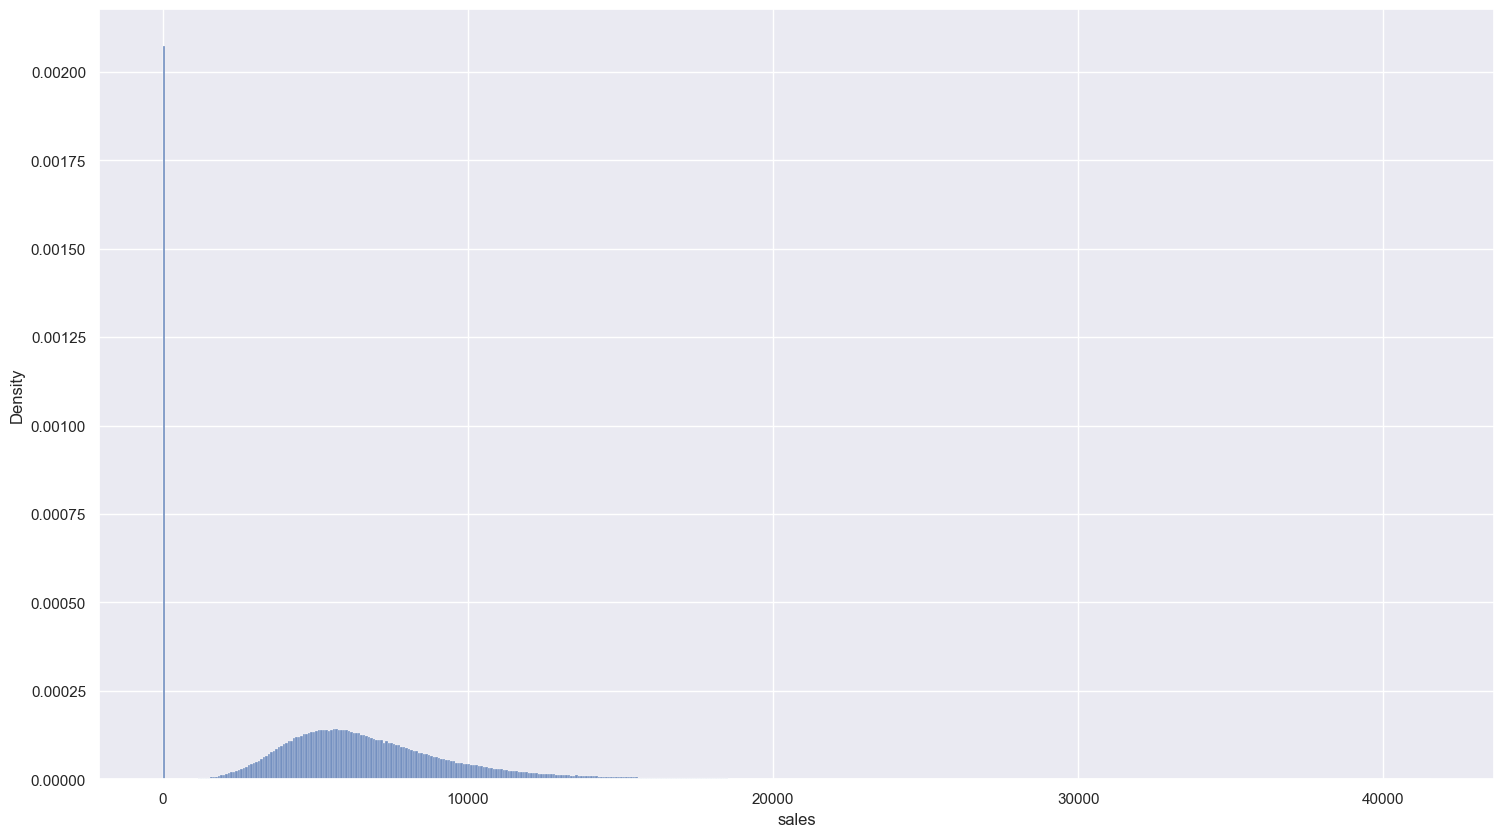

In [25]:
# Distribuição das vendas
plt.figure(figsize = (18,10))
sns.histplot( data = df1, x = 'sales', stat = 'density');

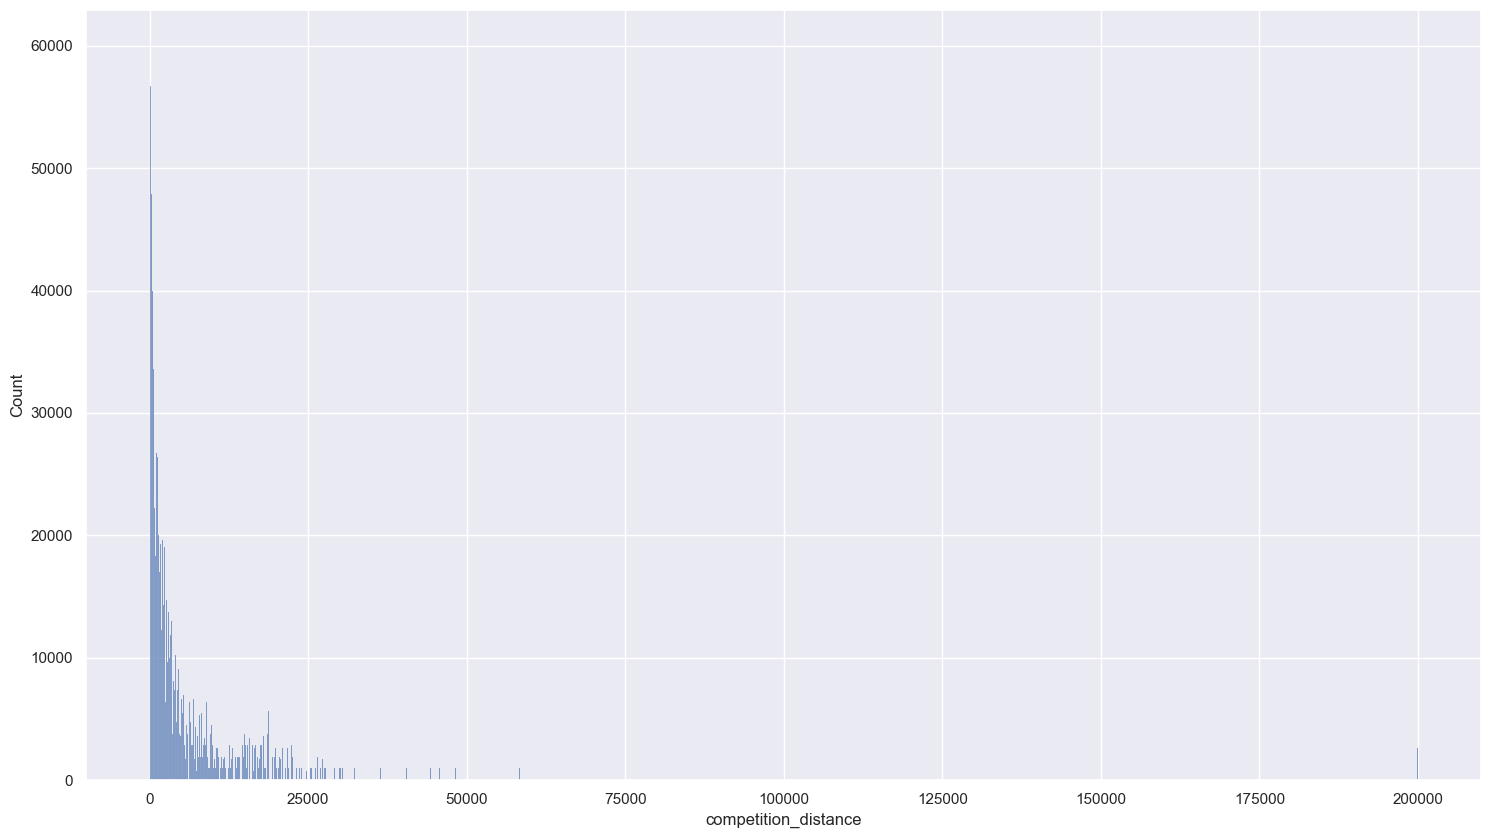

In [26]:
# Distribuicao da Distancia dos concorrentes mais proximo
plt.figure(figsize = (18,10))
sns.histplot( data = df1, x = 'competition_distance', stat = 'count' );

## 1.7.2 Variáveis Categoricas

In [27]:
# quantidade de categorias de cada variavel categorica
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

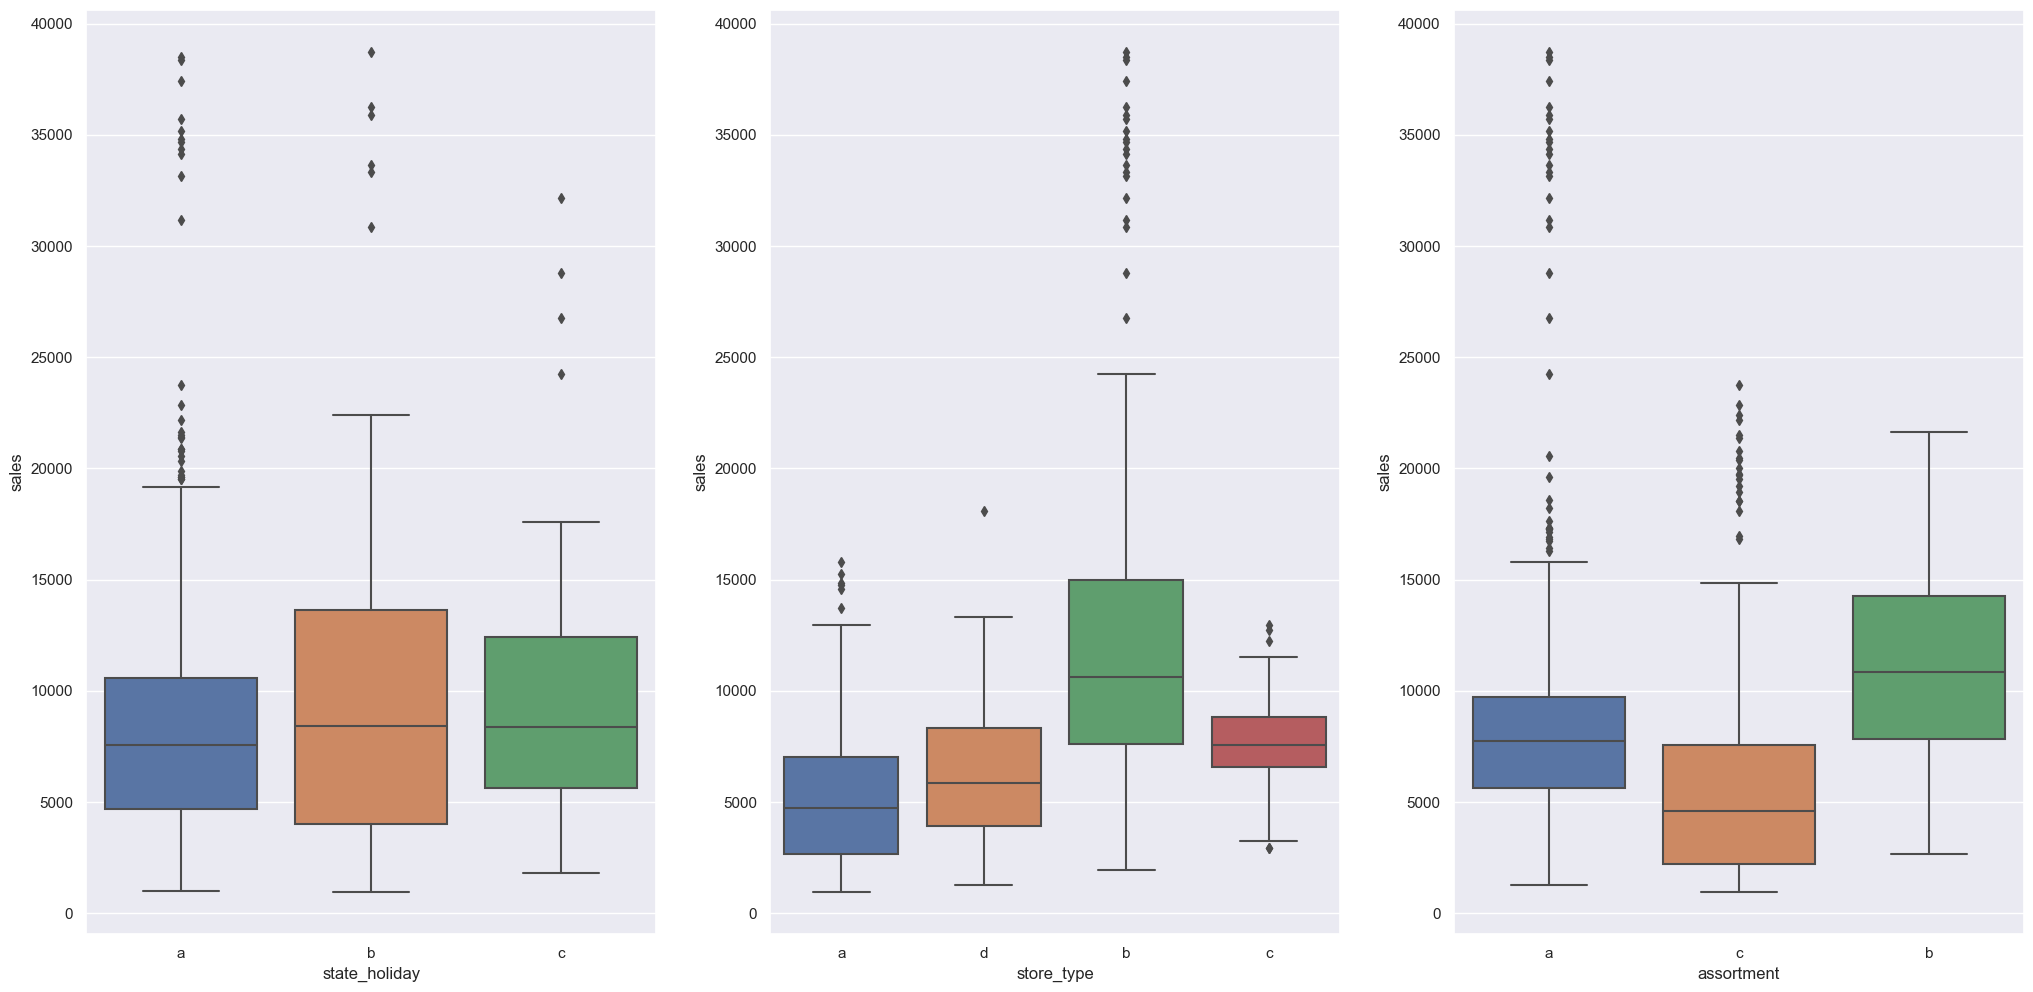

In [28]:
#Dados filtrados - state_holiday
aux1 = df1[ ( df1[ 'state_holiday' ] != '0' ) & ( df1['sales'] > 0 ) ]

#boxplot state_holyday
plt.subplot( 1, 3, 1 )
sns.boxplot( x = 'state_holiday' , y = 'sales' , data = aux1 );

#boxplot store_type
plt.subplot( 1, 3, 2 )
sns.boxplot( x = 'store_type' ,    y = 'sales' , data = aux1 );

#boxplot assortment
plt.subplot( 1, 3, 3 )
sns.boxplot( x = 'assortment' ,    y = 'sales' , data = aux1 );


# 2.0 FEATURE ENGINEERING

In [29]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

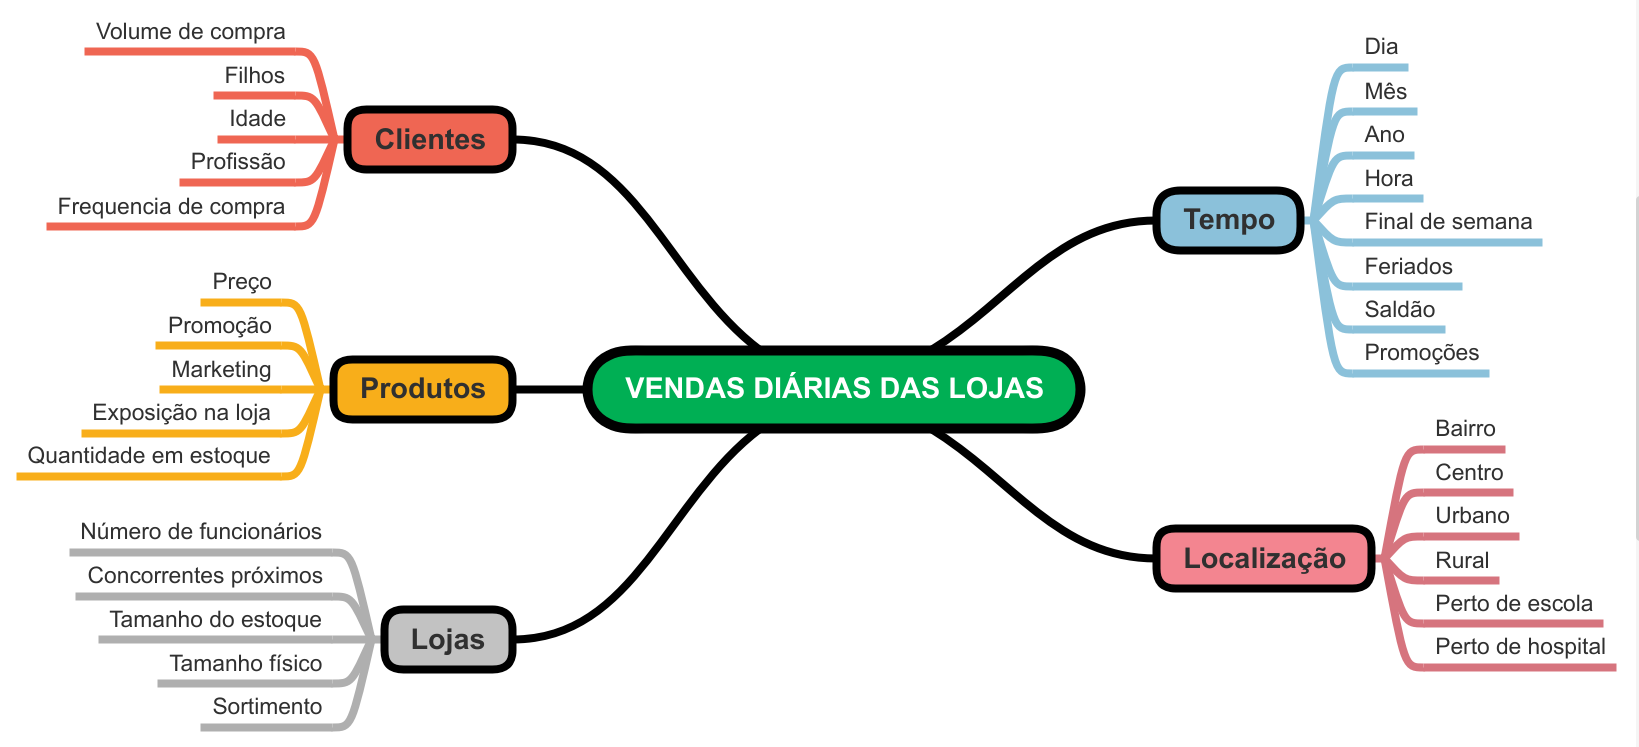

In [30]:
#Image( '/home/deivison/Documentos/projetos/dsrossmann/notebooks/images/DAILY_STORE_SALES.png')
Image( '/home/deivison/Documentos/projetos/dsrossmann/notebooks/images/mapa_mental_1.png')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses Loja

1. Lojas com número maior de funcionários deveriam vender mais.

2. Lojas com maior capacidade de estoque deveriam vender mais.

3. Lojas com maior porte deveriam vender mais.

4. Lojas com maior sortimentos deveriam vender mais.

5. Lojas com competidores mais próximos deveriam vender menos.

6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipóteses Produto

1. Lojas que investem mais em Marketing deveriam vender mais.

2. Lojas com maior exposição de produto deveriam vender mais.

3. Lojas com produtos com preço menor deveriam vender mais.

4. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

5. Lojas com promoções ativas por mais tempo deveriam vender mais.

6. Lojas com mais dias de promoção deveriam vender mais.

7. Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

1. Lojas abertas durante o feriado de Natal deveriam vender mais.

2. Lojas deveriam vender mais ao longo dos anos.

3. Lojas deveriam vender mais no segundo semestre do ano.

4. Lojas deveriam vender mais depois do dia 10 de cada mês.

5. Lojas deveriam vender menos aos finais de semana.

6. Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista Final de Hipóteses

Seleção das hipóteses - Ciclo 1 CRISP

#Lojas

4. Lojas com maior sortimentos deveriam vender mais.

5. Lojas com competidores mais próximos deveriam vender menos.

6. Lojas com competidores à mais tempo deveriam vendem mais.

#produto

5. Lojas com promoções ativas por mais tempo deveriam vender mais.

6. Lojas com mais dias de promoção deveriam vender mais.

7. Lojas com mais promoções consecutivas deveriam vender mais.

#Tempo

1. Lojas abertas durante o feriado de Natal deveriam vender mais.

2. Lojas deveriam vender mais ao longo dos anos.

3. Lojas deveriam vender mais no segundo semestre do ano.

4. Lojas deveriam vender mais depois do dia 10 de cada mês.

5. Lojas deveriam vender menos aos finais de semana.

6. Lojas deveriam vender menos durante os feriados escolares.

Seleção final organizada

1. Lojas com maior sortimentos deveriam vender mais.

2. Lojas com competidores mais próximos deveriam vender menos.

3. Lojas com competidores à mais tempo deveriam vendem mais.

4. Lojas com promoções ativas por mais tempo deveriam vender mais.

5. Lojas com mais dias de promoção deveriam vender mais.

6. Lojas com mais promoções consecutivas deveriam vender mais.

7. Lojas abertas durante o feriado de Natal deveriam vender mais.

8. Lojas deveriam vender mais ao longo dos anos.

9. Lojas deveriam vender mais no segundo semestre do ano.

10. Lojas deveriam vender mais depois do dia 10 de cada mês.

11. Lojas deveriam vender menos aos finais de semana.

12. Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

### Variáveis associadas as datas e a intervalos de tempo

In [31]:
# ano
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week_of_year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year_week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition_time_month
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1 ), axis =1  )
df2['competition_time_month'] = ( (df2['date']-df2['competition_since']) / 30 ).apply(lambda x: x.days).astype(int)

#promo_time_week
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1' , '%Y-%W-%w' ) - datetime.timedelta( days = 7 ) )
df2['promo_time_week'] = ( ( df2['date']- df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype(int)

### Variáveis associadas ao 'assortment' e 'state_holiday'

In [32]:
#assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

#state_holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 FILTRAGEM DE VARIÁVEIS

In [33]:
df3 = df2.copy()

## 3.1 Filtragem de linhas

In [34]:
df3 = df3[ ( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2 Filtragem de colunas

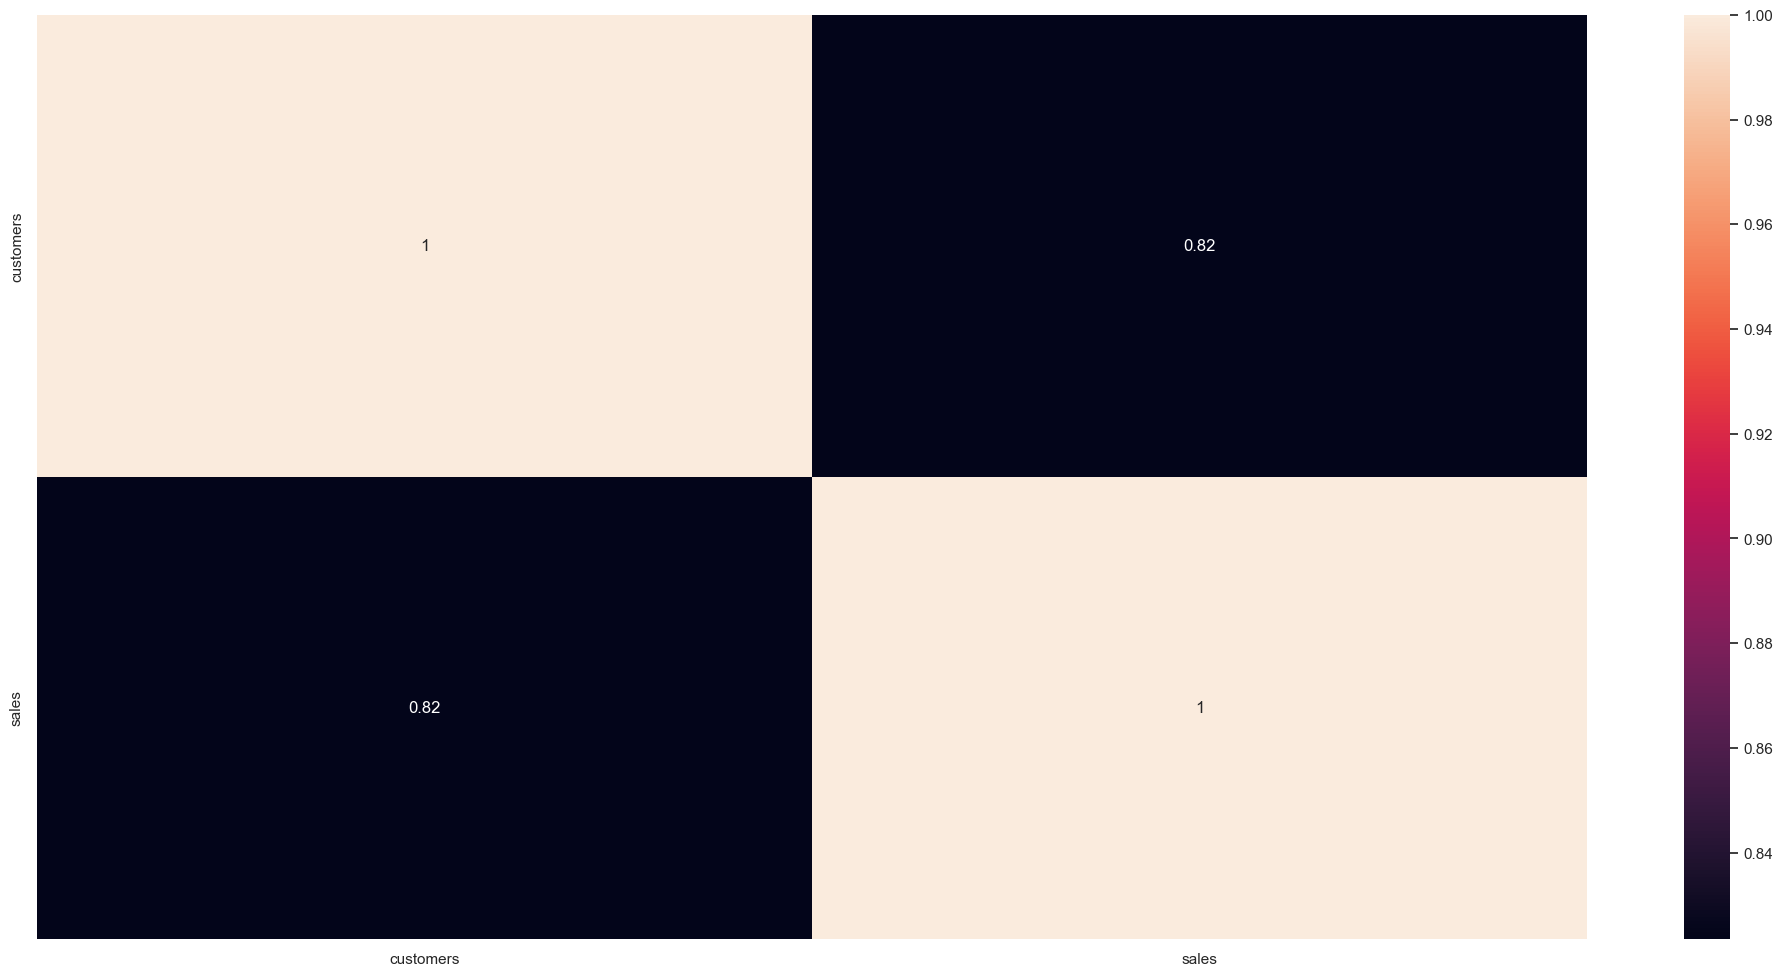

In [35]:
#mapa de calor - customers
aux1 = df3[['customers','sales']]
x = sns.heatmap( aux1.corr( method = 'pearson'), annot = True)

In [36]:
cols_drop = ['customers', 'open','promo_interval', 'month_map' ]
df3 = df3.drop(cols_drop, axis = 1)

In [37]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS - EDA

In [38]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Variável Resposta

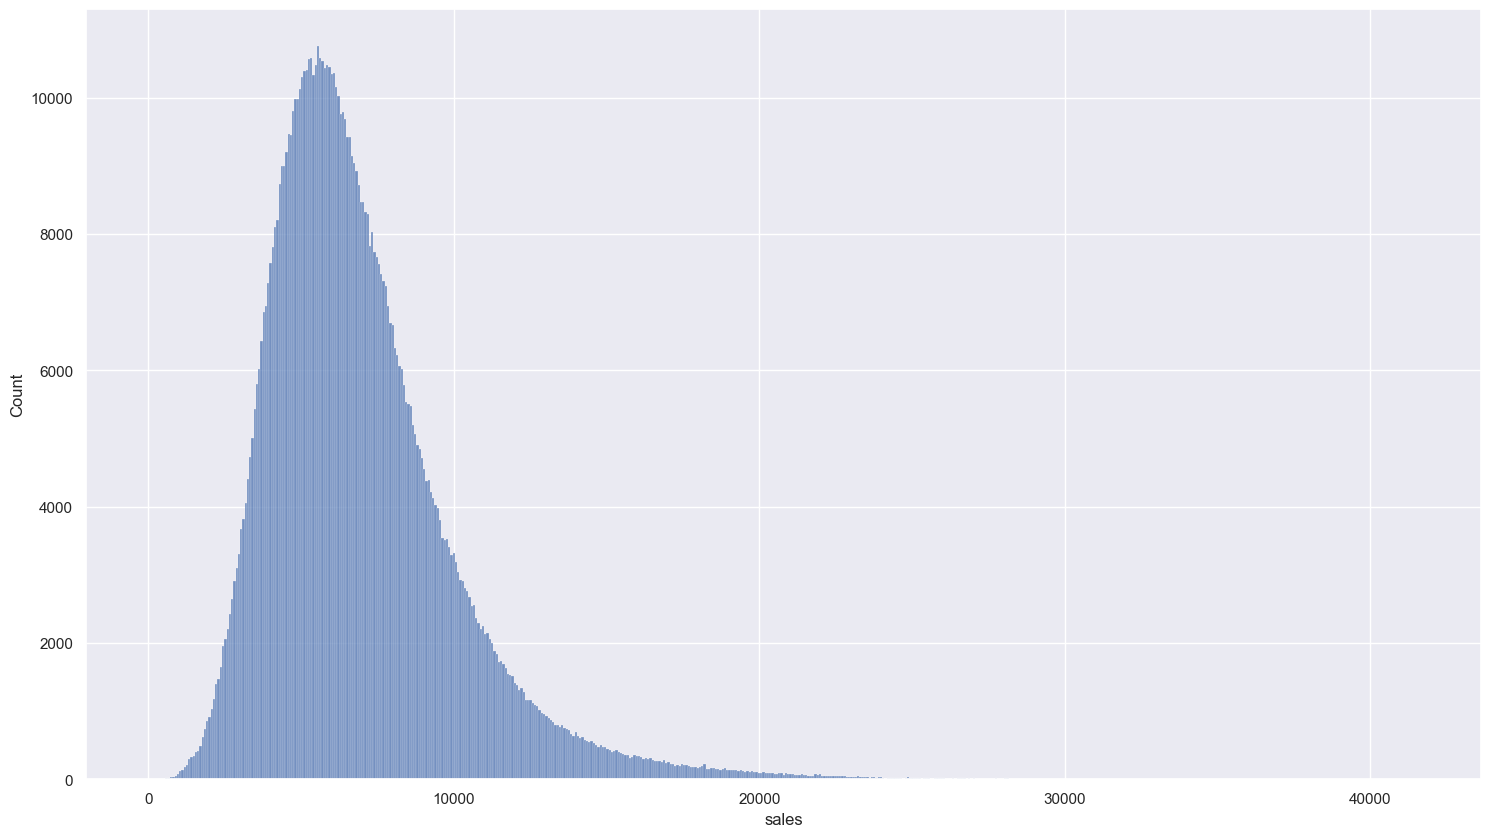

In [39]:
plt.figure( figsize = (18,10) );
sns.histplot( df4['sales'], kde = False );

### 4.1.2 Variáveis Numéricas

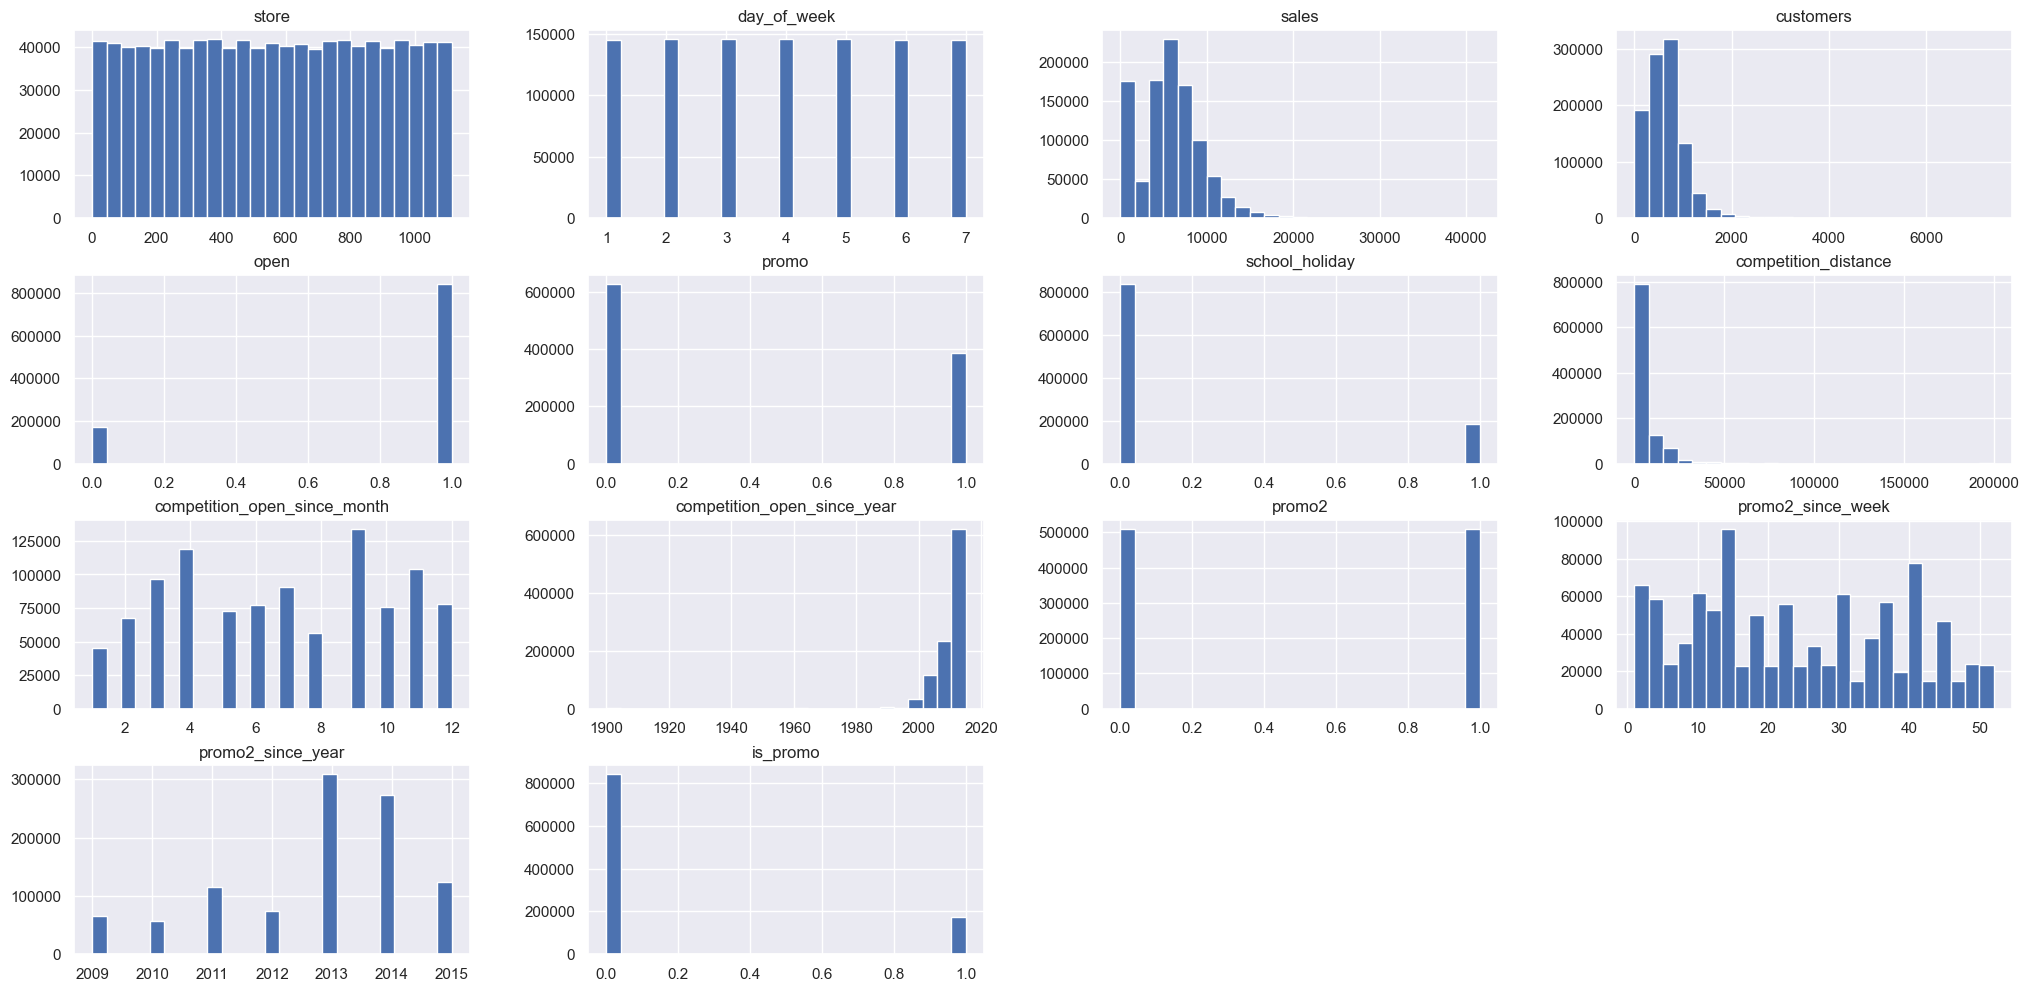

In [40]:
num_attributes.hist(bins=25);

### 4.1.3 Variáveis Categoricas

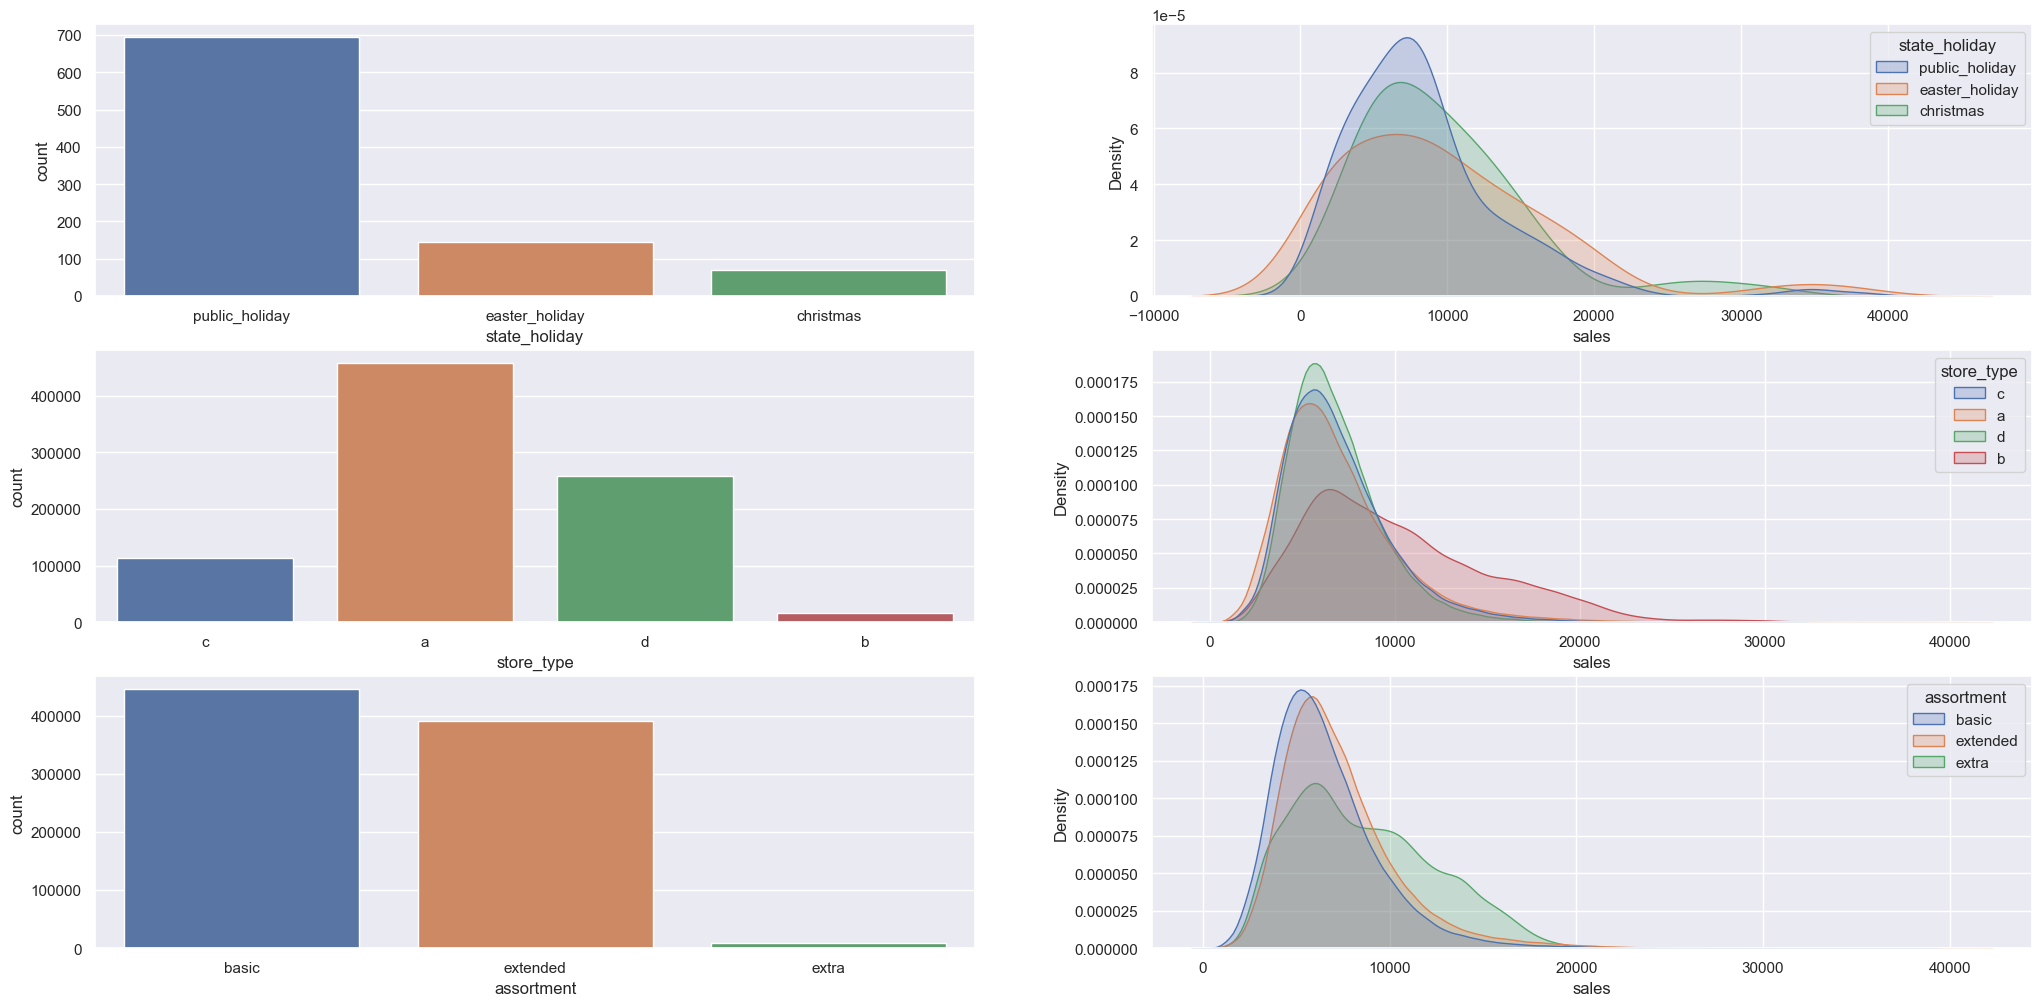

In [41]:
#state_holiday 
a = df4 [ df4['state_holiday'] != 'regular_day' ]
plt,subplot(3,2,1)
sns.countplot(x='state_holiday', data = a );

plt.subplot(3,2,2)
sns.kdeplot(data = a, x= 'sales', hue ='state_holiday',fill = True, common_norm = False  );

#store_type
plt.subplot(3,2,3)
sns.countplot(x = 'store_type', data = df4);

plt.subplot(3,2,4)
sns.kdeplot(data = df4, x= 'sales', hue = 'store_type',fill = True, common_norm = False );

#assortment
plt.subplot(3,2,5)
sns.countplot( x = 'assortment', data = df4 );

plt.subplot(3,2,6)
sns.kdeplot(data = df4, x='sales', hue = 'assortment',fill = True, common_norm = False );

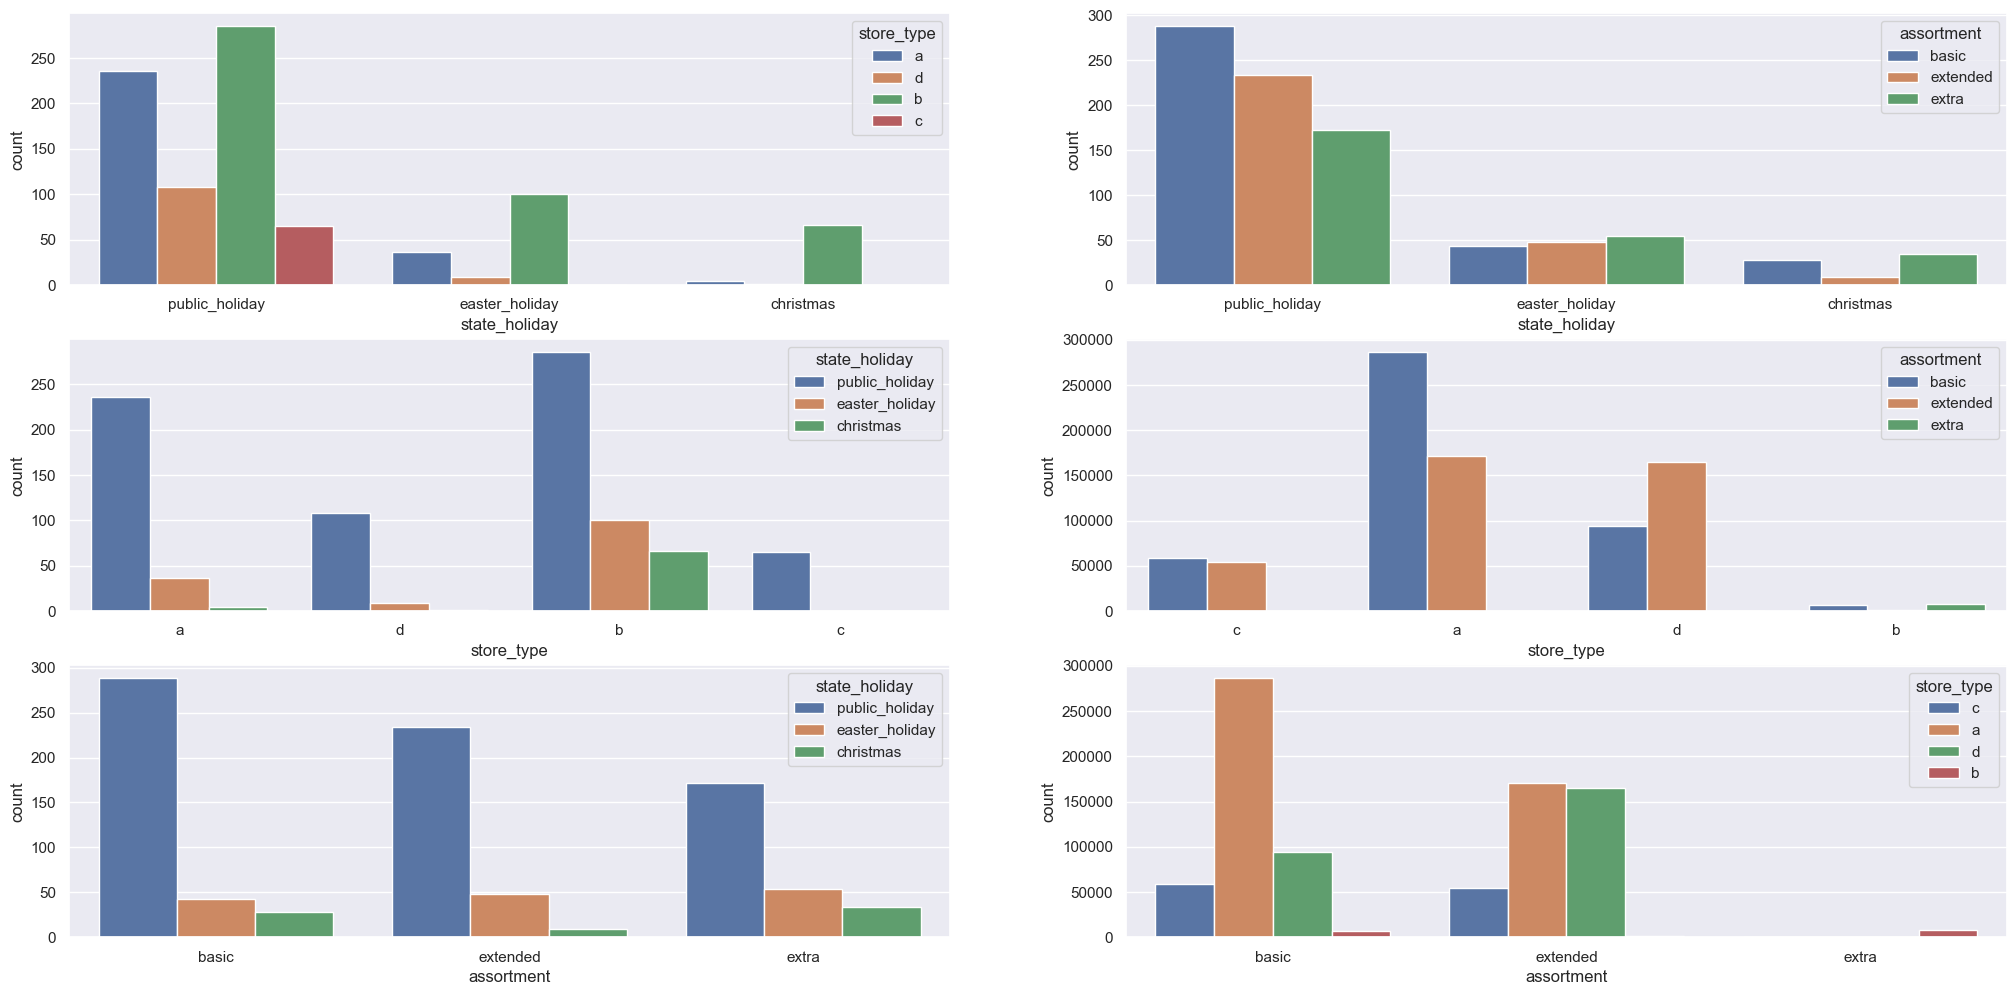

In [42]:
#state_holiday
a=df4 [ df4['state_holiday'] != 'regular_day']
plt.subplot(3,2,1)
sns.countplot(x= "state_holiday", hue = "store_type", data = a );

plt.subplot(3,2,2)
sns.countplot(x = 'state_holiday', hue = 'assortment', data = a );

#store_type
plt.subplot(3,2,3)
sns.countplot(x = 'store_type', hue = 'state_holiday', data = a);

plt.subplot(3,2,4)
sns.countplot( x = 'store_type', hue = 'assortment', data = df4);

#assortment
plt.subplot(3,2,5)
sns.countplot( x = 'assortment', hue = 'state_holiday', data = a );
plt.subplot(3,2,6)
sns.countplot( x= 'assortment', hue = 'store_type', data = df4 );

## 4.2 Análise Bivariada

### 4.2.1 Hipótese 1: Lojas com maior sortimento deveriam vender mais

Verdadeira: Lojas com maior sortimento vendem mais

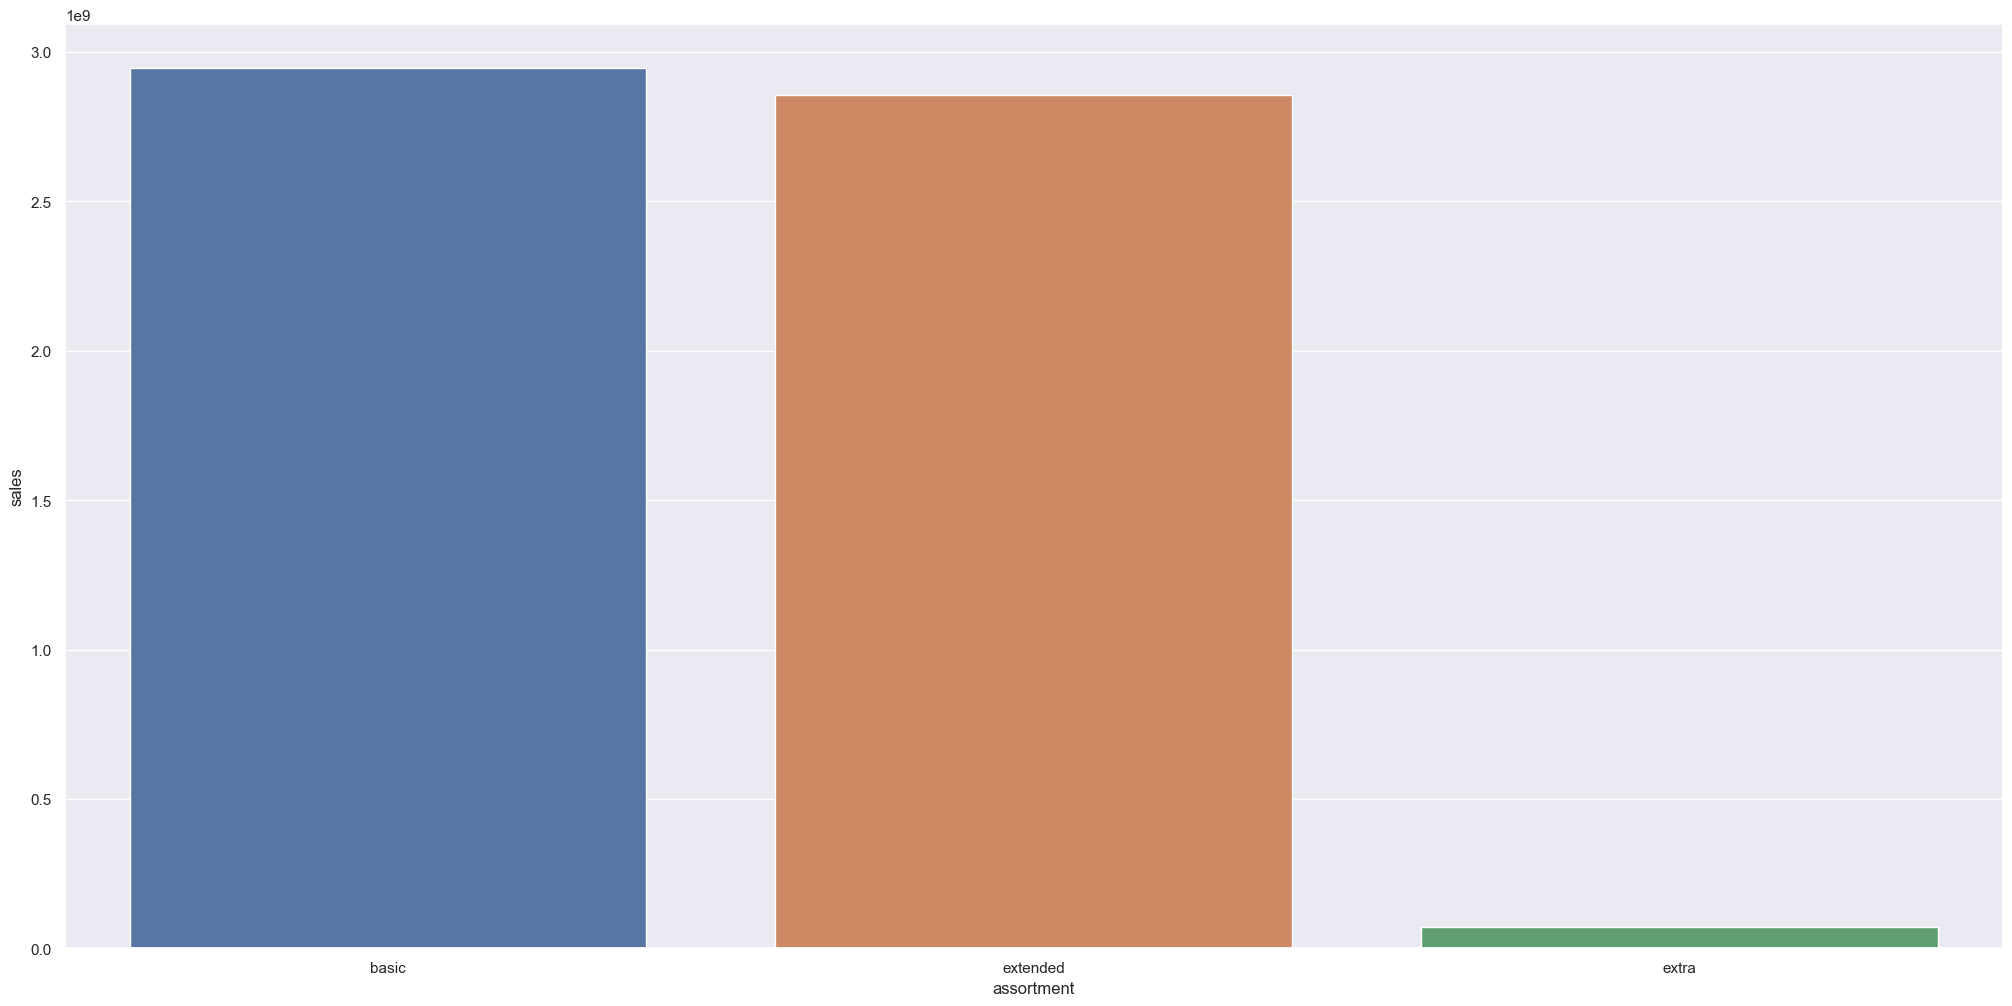

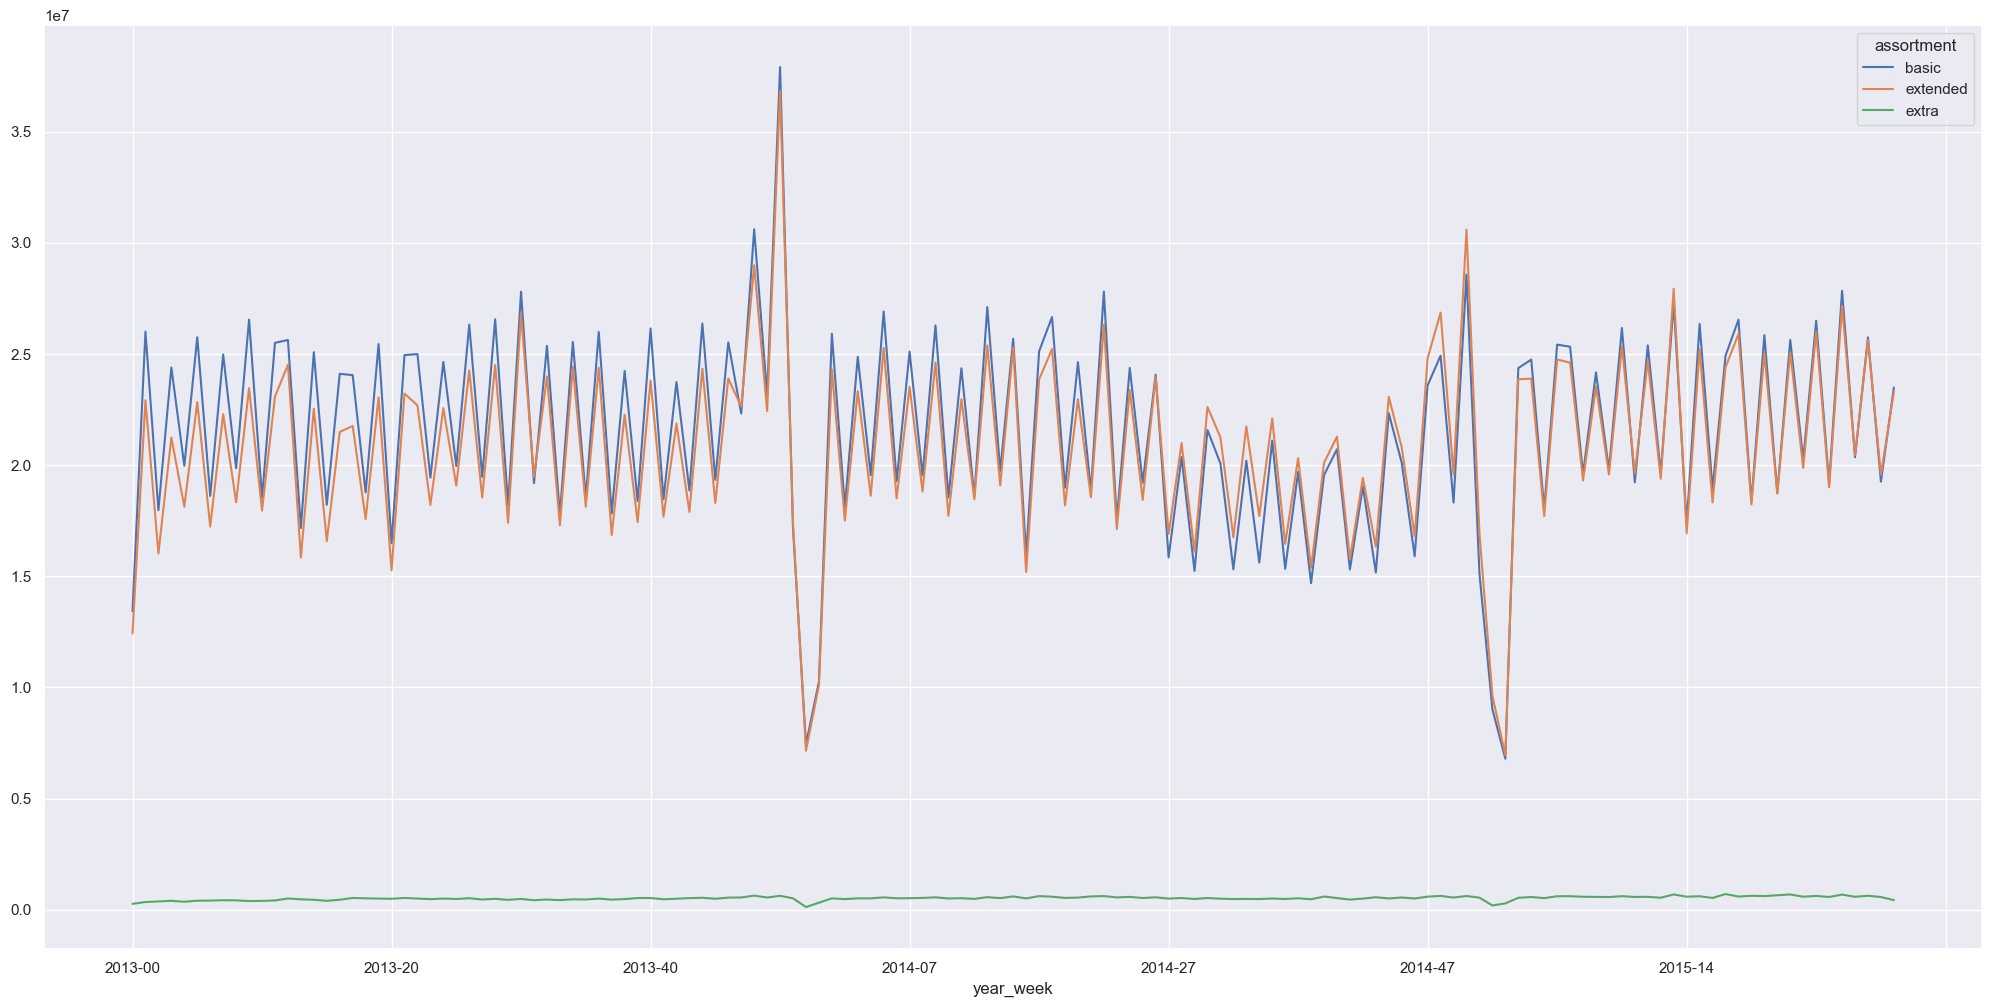

In [43]:
#Quantidade de vendas por categoria de assorment
aux1 = df4[ [ 'assortment', 'sales' ] ].groupby('assortment').sum().reset_index()
sns.barplot( x = 'assortment', y = 'sales', data = aux1 );

#Quantidade de vendas por categoria de assorment semanal
aux2 = df4[ [ 'year_week', 'assortment','sales' ] ].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot();

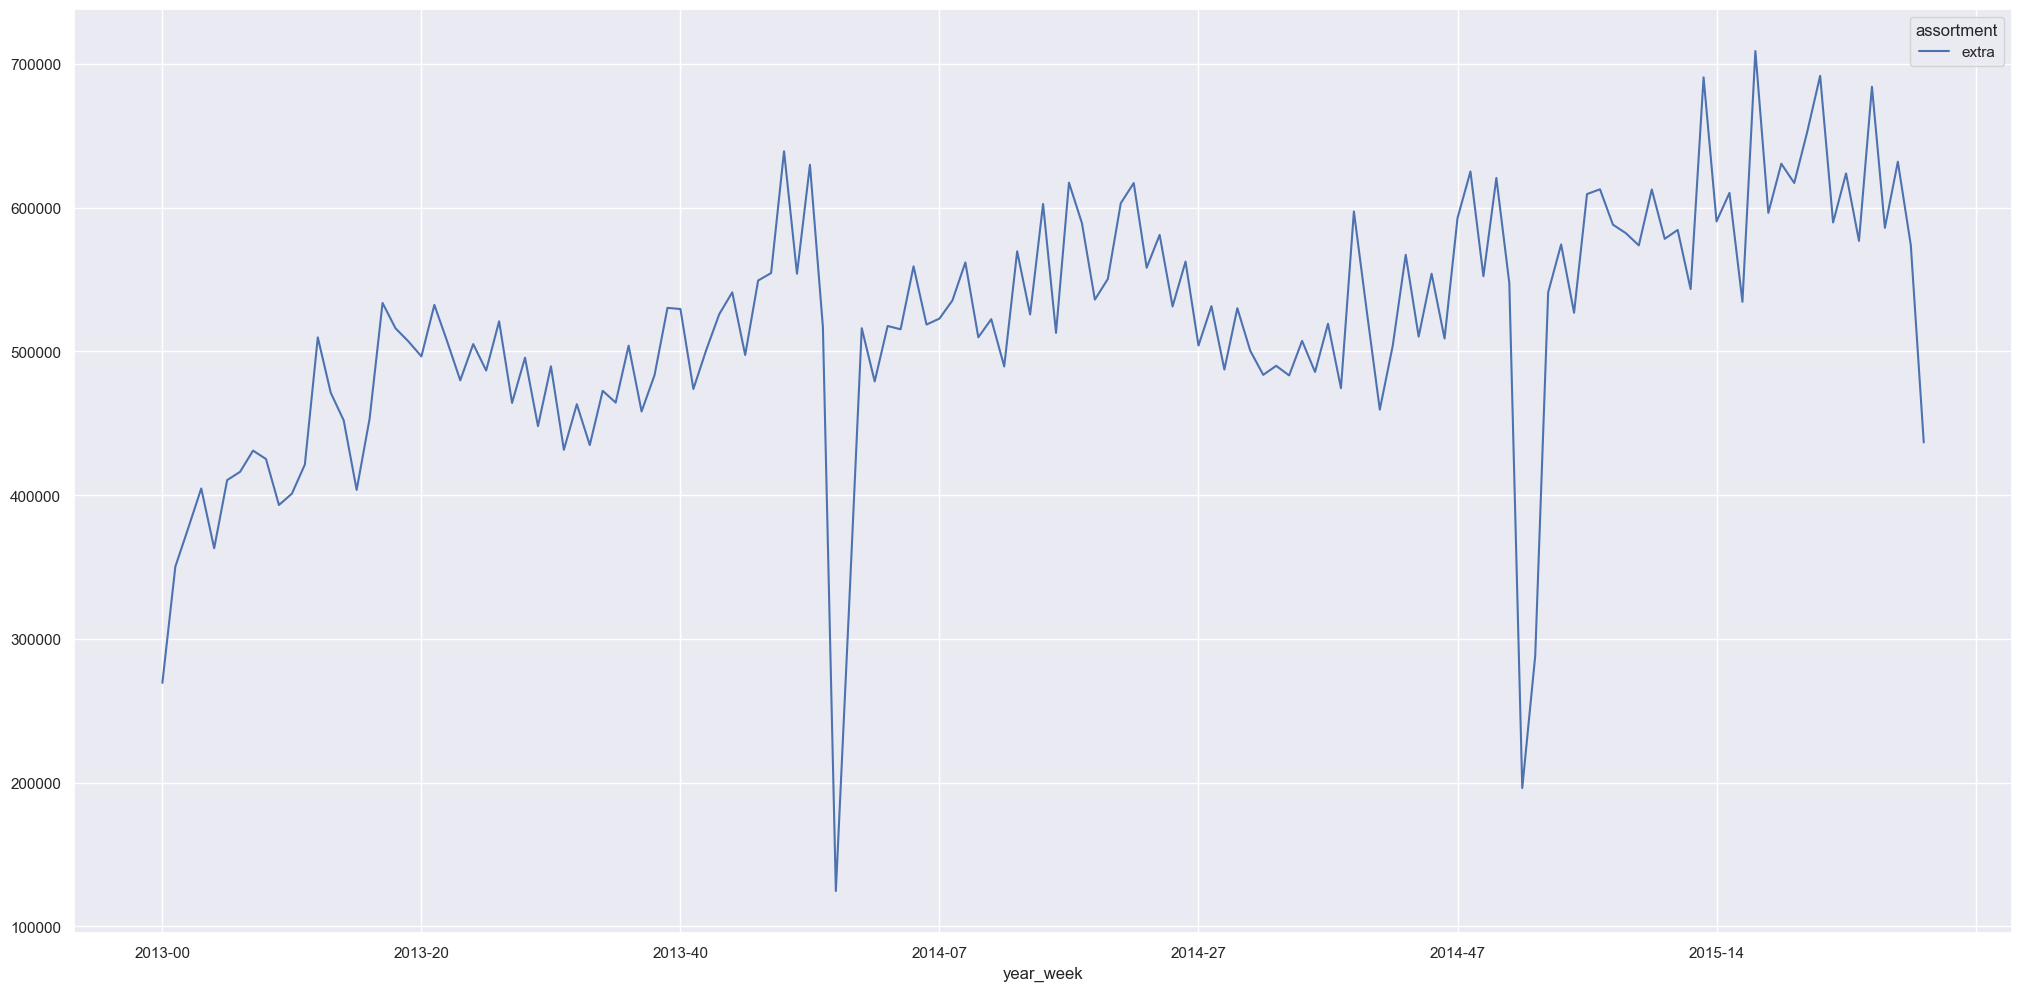

In [44]:
#quantidade de vendas da categoria 'extra' de assortment
aux3 = aux2[ (aux2['assortment'] == 'extra') ]
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales' ).plot();

### 4.2.2 Hipótese 2: Lojas com competidores mais próximos deveriam vender menos
FALSA: Lojas com competidores mais próximos vendem MAIS

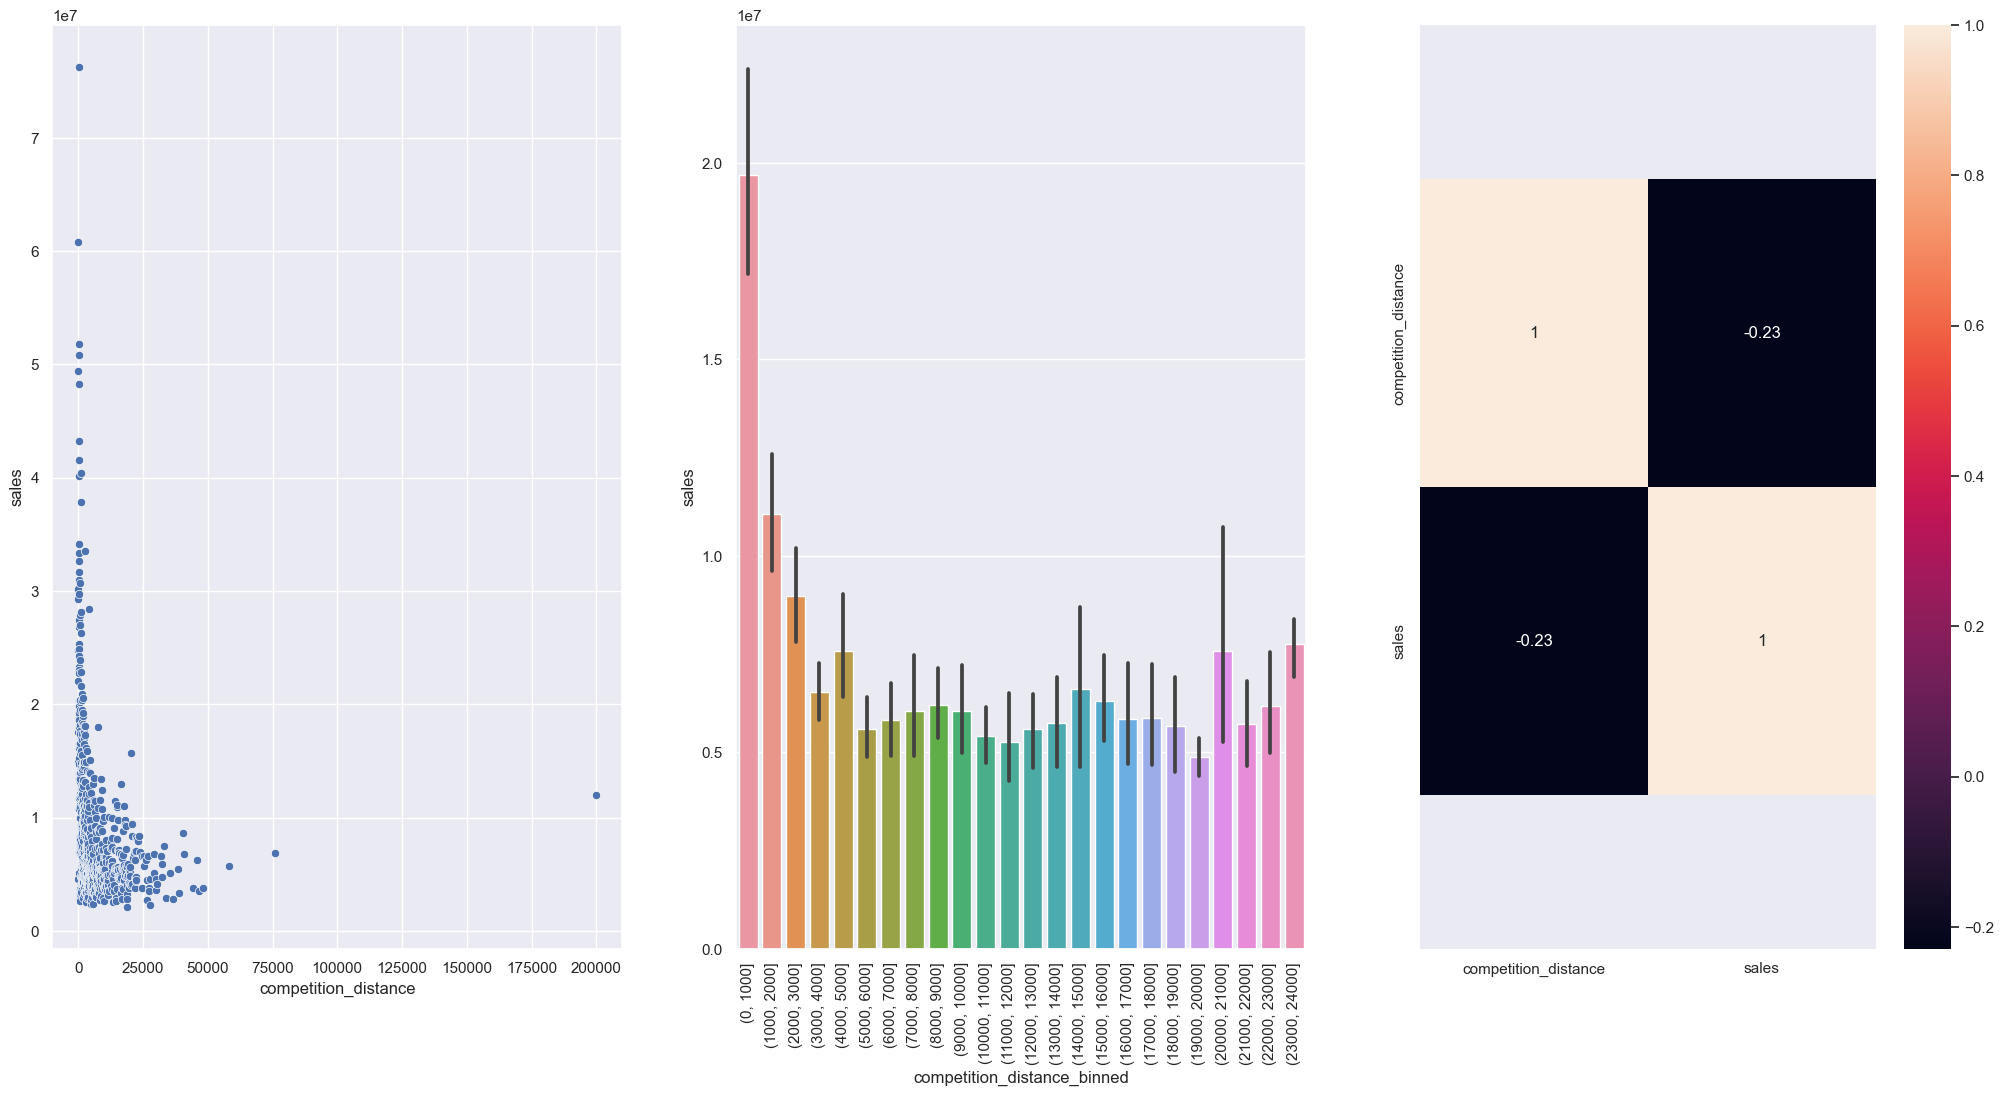

In [45]:
#Vendas das lojas agrupadas pelas distancias dos concorrentes
aux5 = df4[ [ 'competition_distance','sales' ] ].groupby('competition_distance').sum().reset_index()

#Grafico de pontos - scatterplot
plt.subplot(1,3,1)
sns.scatterplot( x = 'competition_distance', y = 'sales' , data = aux5);

#grafico de barras - barplot
bins = np.arange(0, 25000, 1000 )
aux5['competition_distance_binned'] = pd.cut( aux5['competition_distance'], bins = bins)
aux6 = aux5[ ['competition_distance_binned', 'sales' ]].groupby('competition_distance_binned').sum().reset_index()
plt.subplot(1,3,2)
sns.barplot( x = 'competition_distance_binned', y = 'sales', data = aux5);
plt.xticks(rotation = 'vertical');

#mapa de calor - heatmap
plt.subplot(1,3,3)
x = sns.heatmap( aux5.corr( method = 'pearson'), annot = True)
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5,top-0.5);

### 4.2.3 Hipótese 3: Lojas com competidores a mais tempo vendem mais
FALSO: Lojas com competidores a mais tempo vendem MENOS

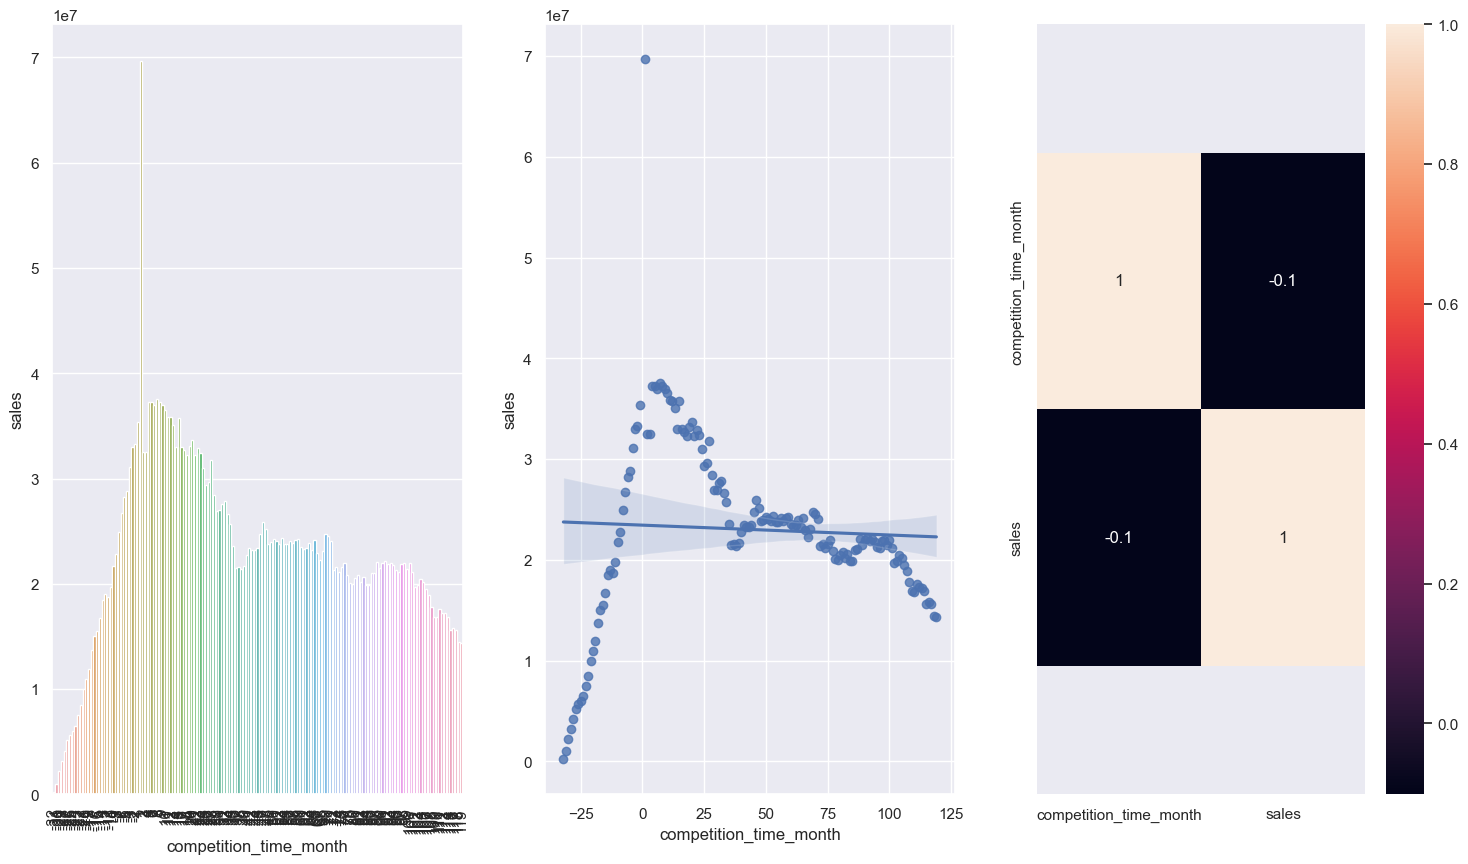

In [46]:
plt.figure( figsize = (18,10) )
#grafico de Barras - barplot
aux1 = df4[ [ 'competition_time_month','sales' ] ].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[ ( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 ) ]
plt.subplot(1,3,1)
sns.barplot( x = 'competition_time_month', y = 'sales', data = aux2 );
plt.xticks(rotation = 90 );

#grafico de tendencia
plt.subplot(1,3,2)
sns.regplot( x = 'competition_time_month', y = 'sales', data = aux2 );

#Grafico mapa de calor - heatmap
plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

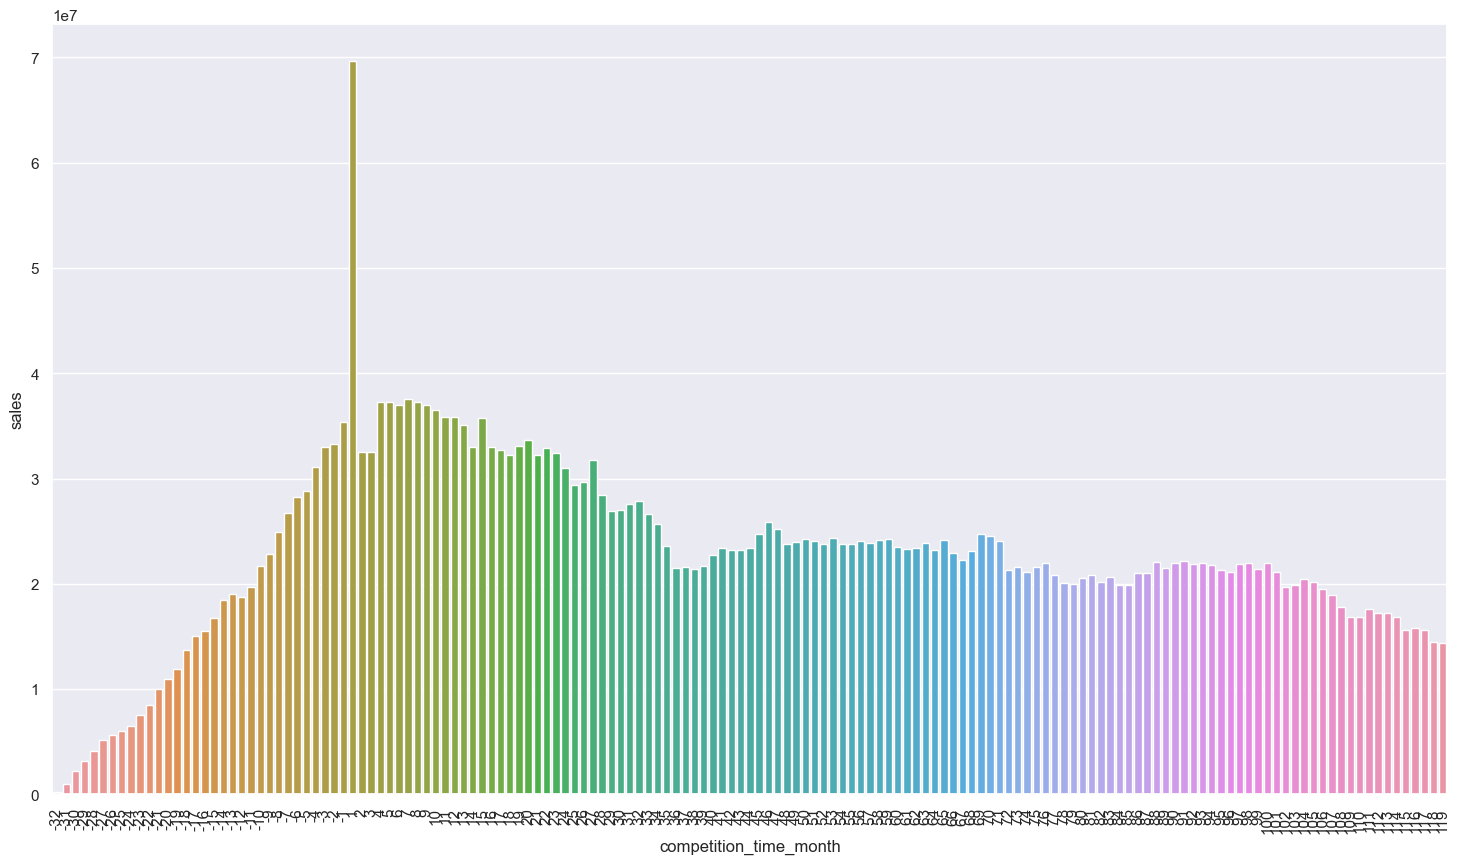

In [47]:
plt.figure( figsize = (18,10) )
#grafico de Barras - barplot
aux1 = df4[ [ 'competition_time_month','sales' ] ].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[ ( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 ) ]
sns.barplot( x = 'competition_time_month', y = 'sales', data = aux2 );
plt.xticks(rotation = 90 );

### 4.2.4 Hipótese 4: Lojas com promoções ativas por mais tempo vendem mais
FALSO: Lojas com promoções ativas por mais tempo vendem MENOS

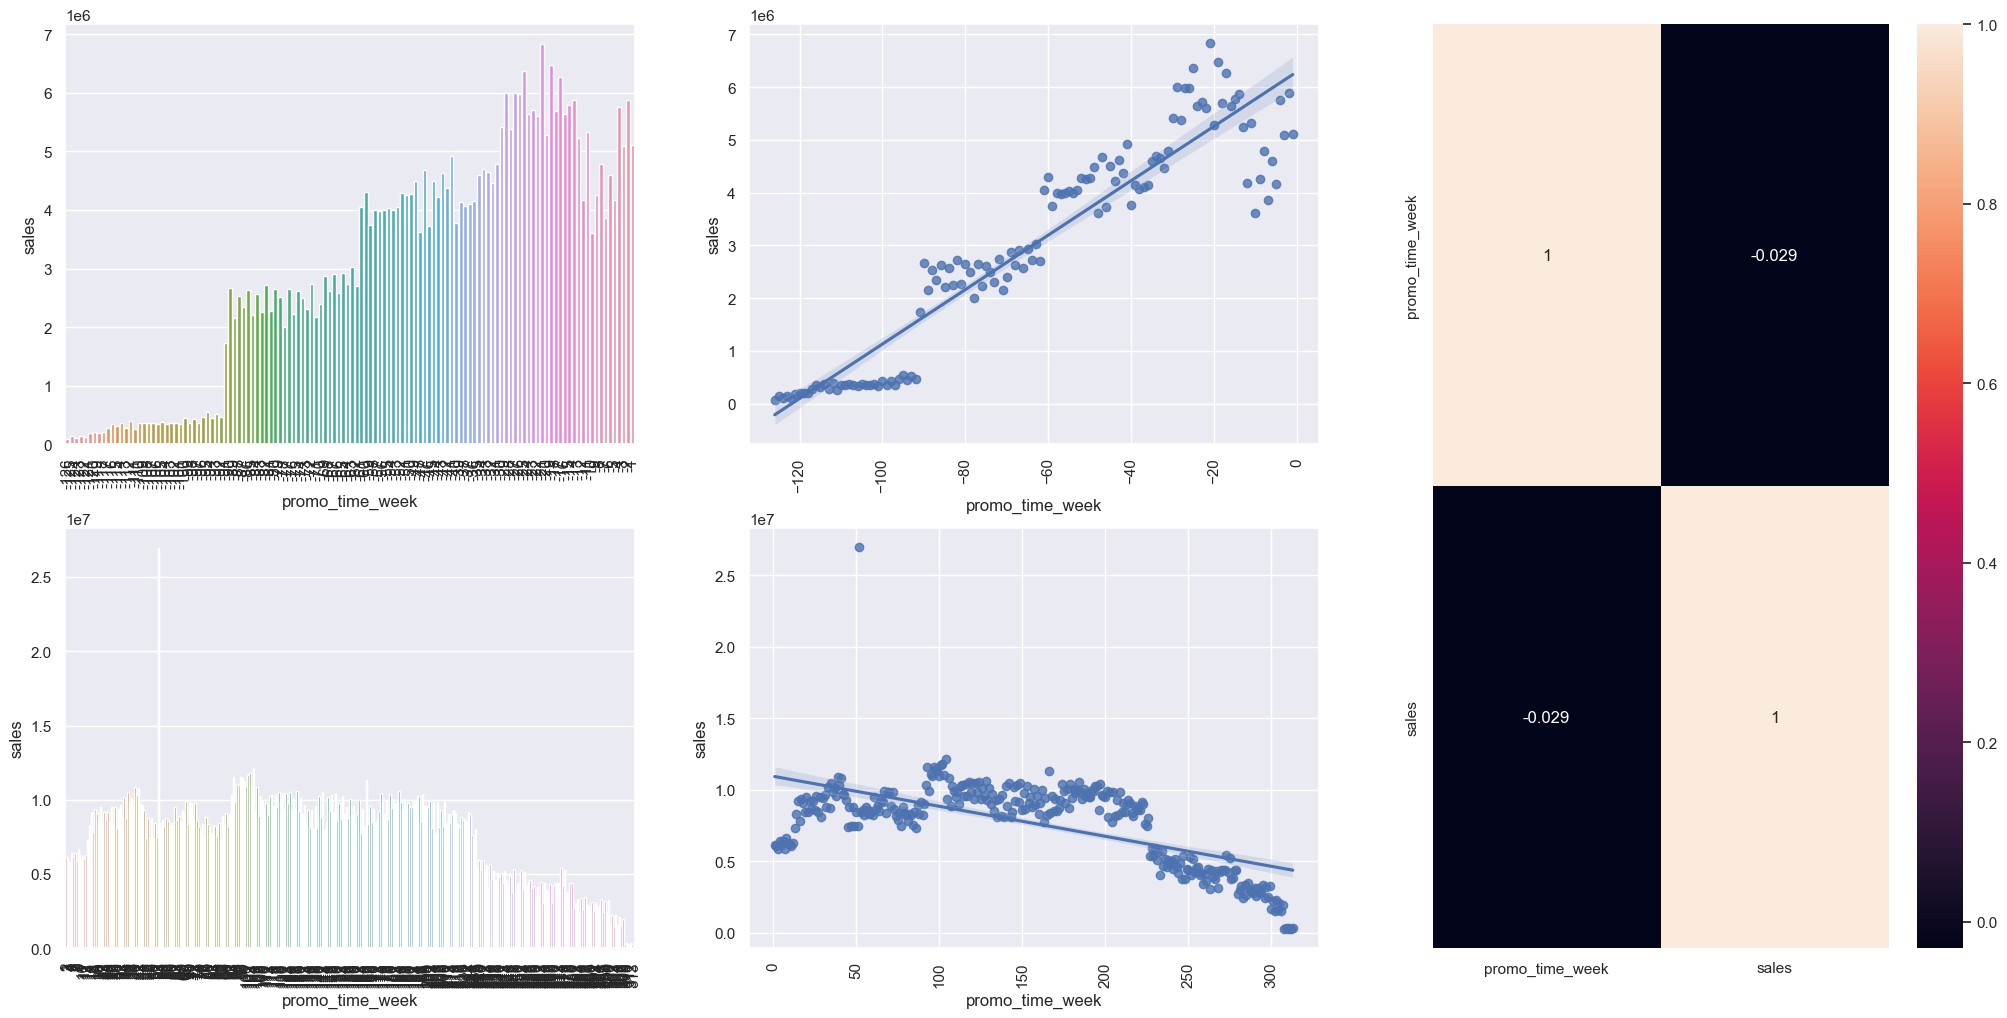

In [48]:
aux1 = df4[ ['promo_time_week', 'sales'] ].groupby('promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

#Promocao datas negativas
plt.subplot( grid[0,0] )
aux2 = aux1[ aux1['promo_time_week'] < 0 ]
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks( rotation = 90 );

plt.subplot( grid[0,1] )
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux2 );
plt.xticks( rotation = 90 );

#Promocao datas positivas
plt.subplot( grid[1,0] )
aux3 = aux1[ (aux1['promo_time_week'] > 0) ]
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux3 );
plt.xticks( rotation = 90 );

plt.subplot( grid[1,1] )
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux3 );
plt.xticks( rotation = 90 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method = 'pearson'), annot = True );

### 4.2.5 Hipótese 5: Lojas com mais dias de promoção deveriam vender mais
Próximo ciclo do CRISP

### 4.2.6 Lojas com mais promoções consecutivas deveriam vender mais.
Falso: Lojas com promoções consecutivas vendem menos

In [49]:
df4[ ['promo','promo2','sales']].groupby(['promo','promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


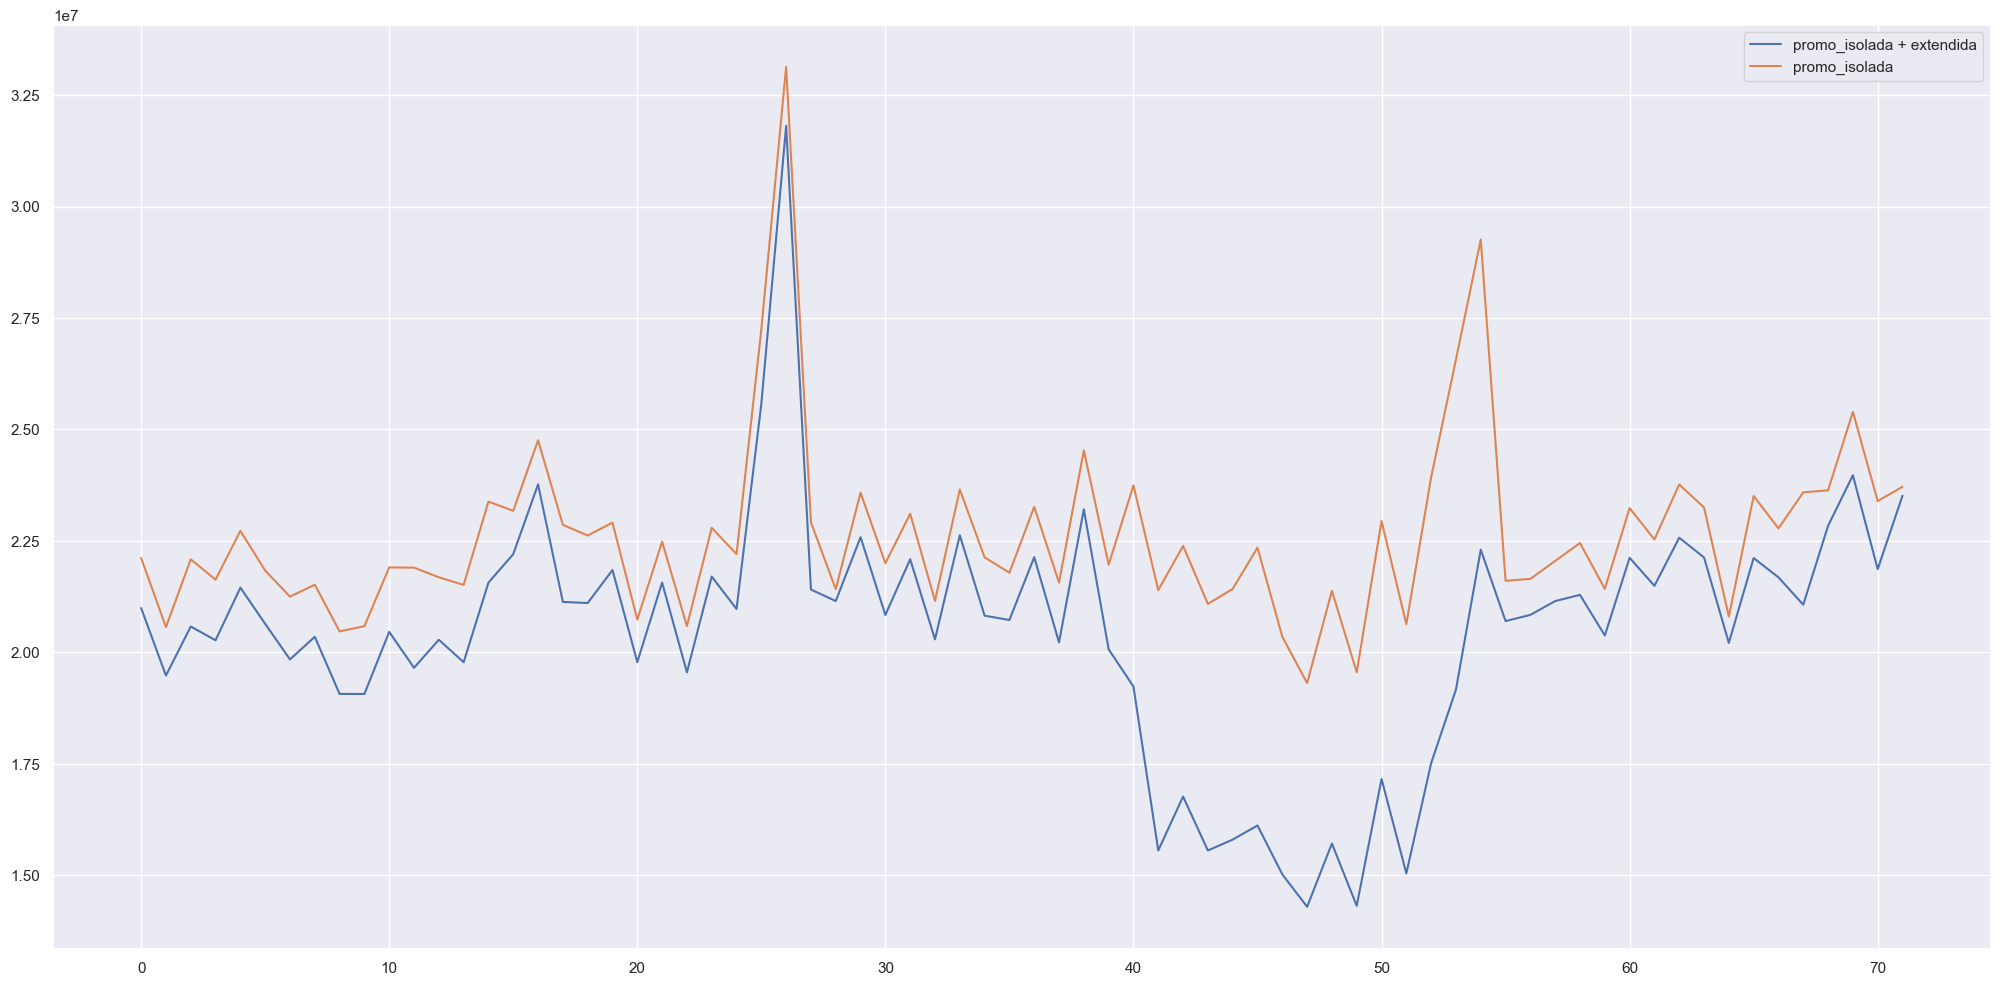

In [50]:
aux1 = df4[ (df4['promo'] == 1 ) & ( df4['promo2'] == 1 ) ][ ['year_week','sales'] ].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[ (df4['promo'] == 1 ) & (df4['promo2'] == 0 ) ][ ['year_week','sales'] ].groupby('year_week').sum().reset_index()

aux2.plot( ax = ax );
ax.legend( labels = [ 'promo_isolada + extendida','promo_isolada'] );

### 4.2.7 Hipótese 7: Lojas que abrem no feriado de natal vendem mais
Falso: Lojas que abrem no natal não vendem mais que os outros feriados

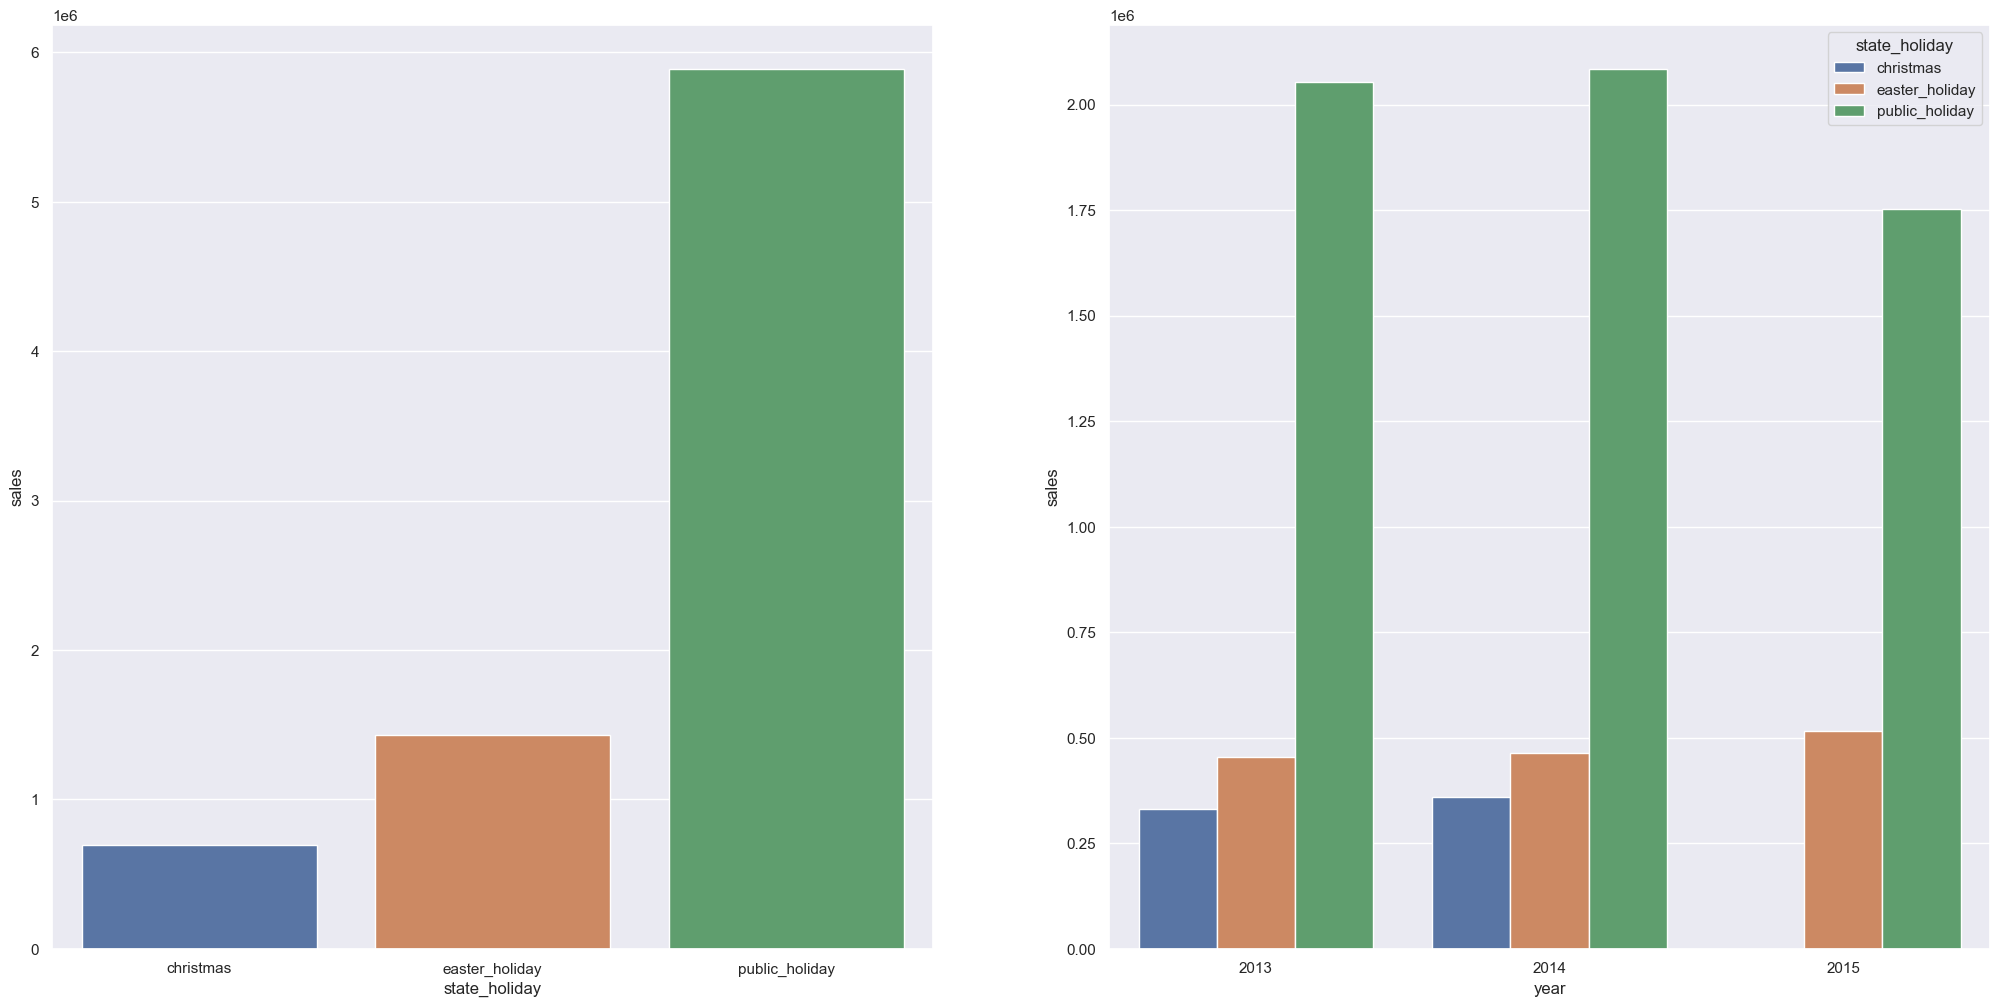

In [51]:
#filtro - remove dias regulares
aux0 = df4[ df4['state_holiday'] != 'regular_day' ]

#Agrupar vendas pelo feriados
plt.subplot( 1, 2, 1 )
aux1 = aux0[ ['state_holiday','sales'] ].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y = 'sales', data = aux1);

plt.subplot( 1, 2, 2 )
aux2 = aux0[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### 4.2.8 Hipótese 8: Lojas deveriam vender menos durante os feriados escolares
Verdadeiro: Lojas vendem menos durante as ferias escolares

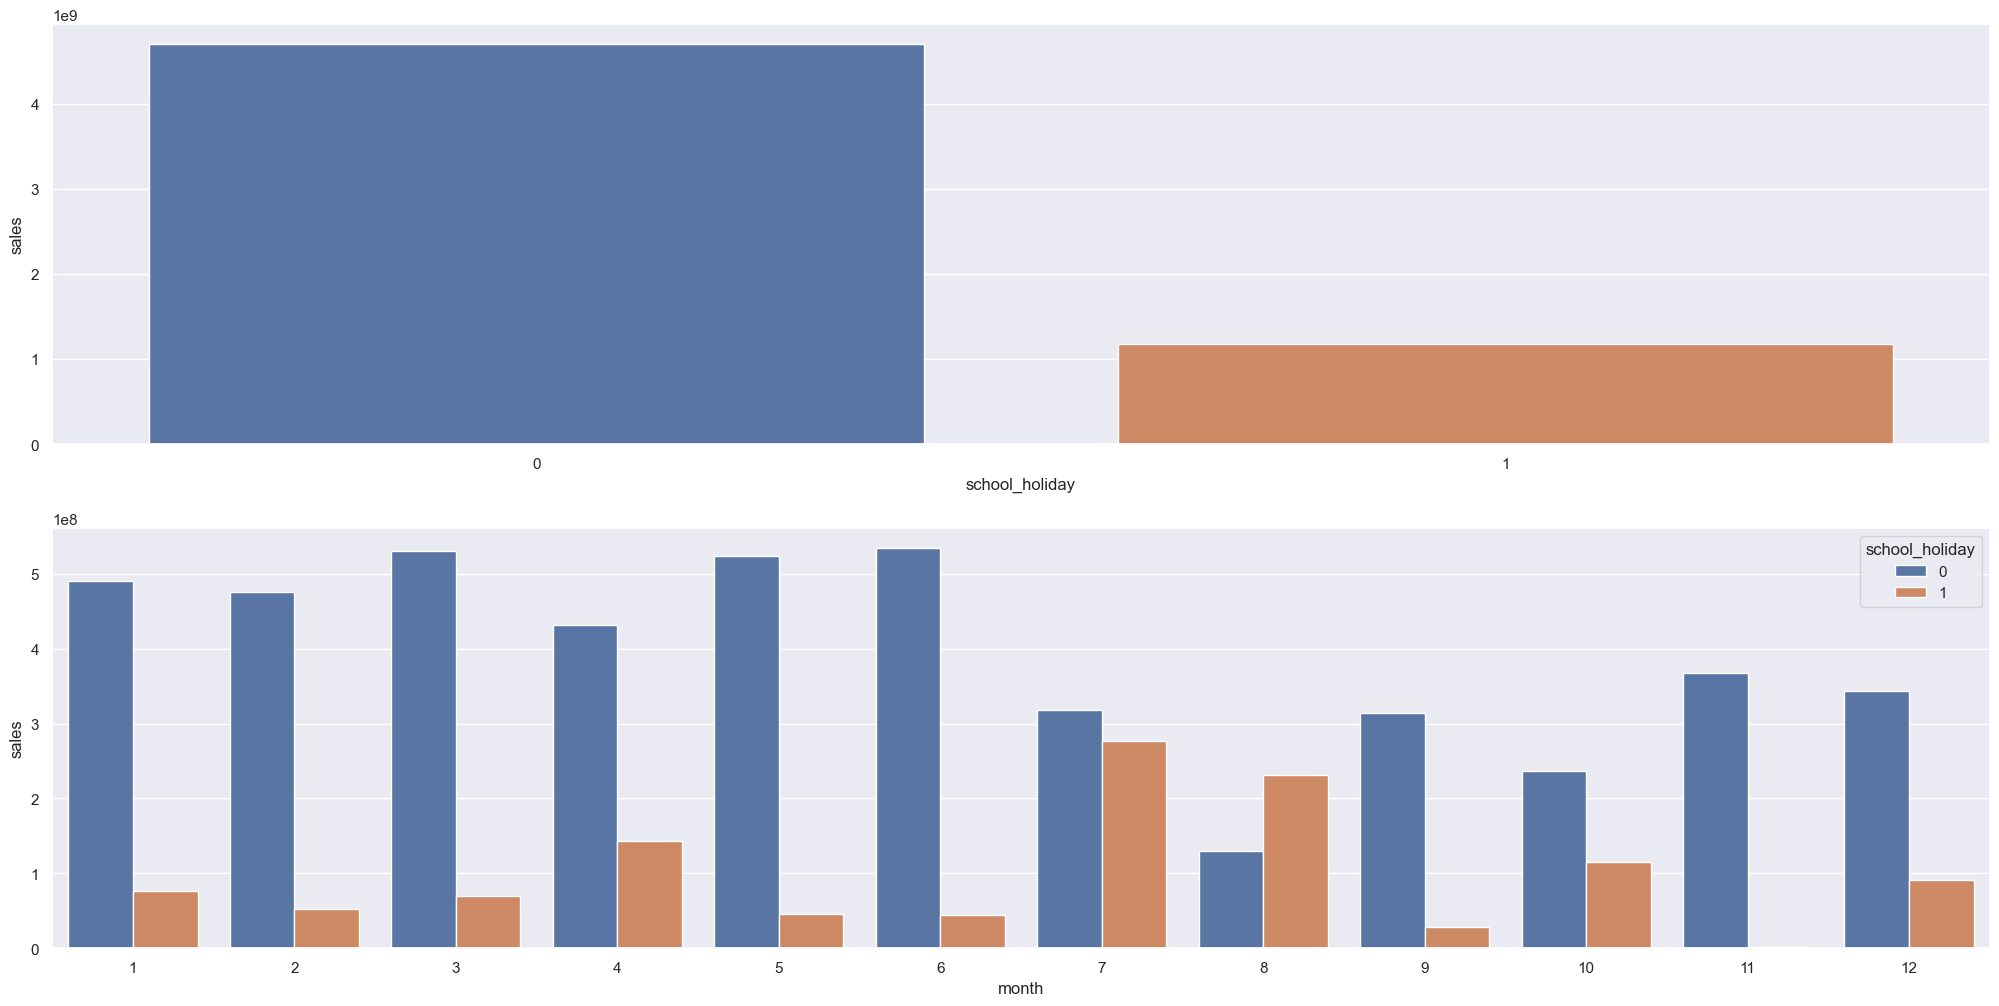

In [52]:
#agrupar ferias escolares e vendas 
plt.subplot(2,1,1)
aux1 = df4[ ['school_holiday','sales'] ].groupby('school_holiday').sum().reset_index()
sns.barplot( x = 'school_holiday', y = 'sales', data = aux1);

#agrupar ferias escolares e vendas mes a mes
plt.subplot(2,1,2)
aux2 = df4[ ['school_holiday','sales', 'month'] ].groupby(['school_holiday', 'month'] ).sum().reset_index()
sns.barplot( x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);

### 4.2.9 Hipótese 9: Lojas deveriam vender mais ao longo dos anos
Falso: Lojas vendem menos ao longo dos anos

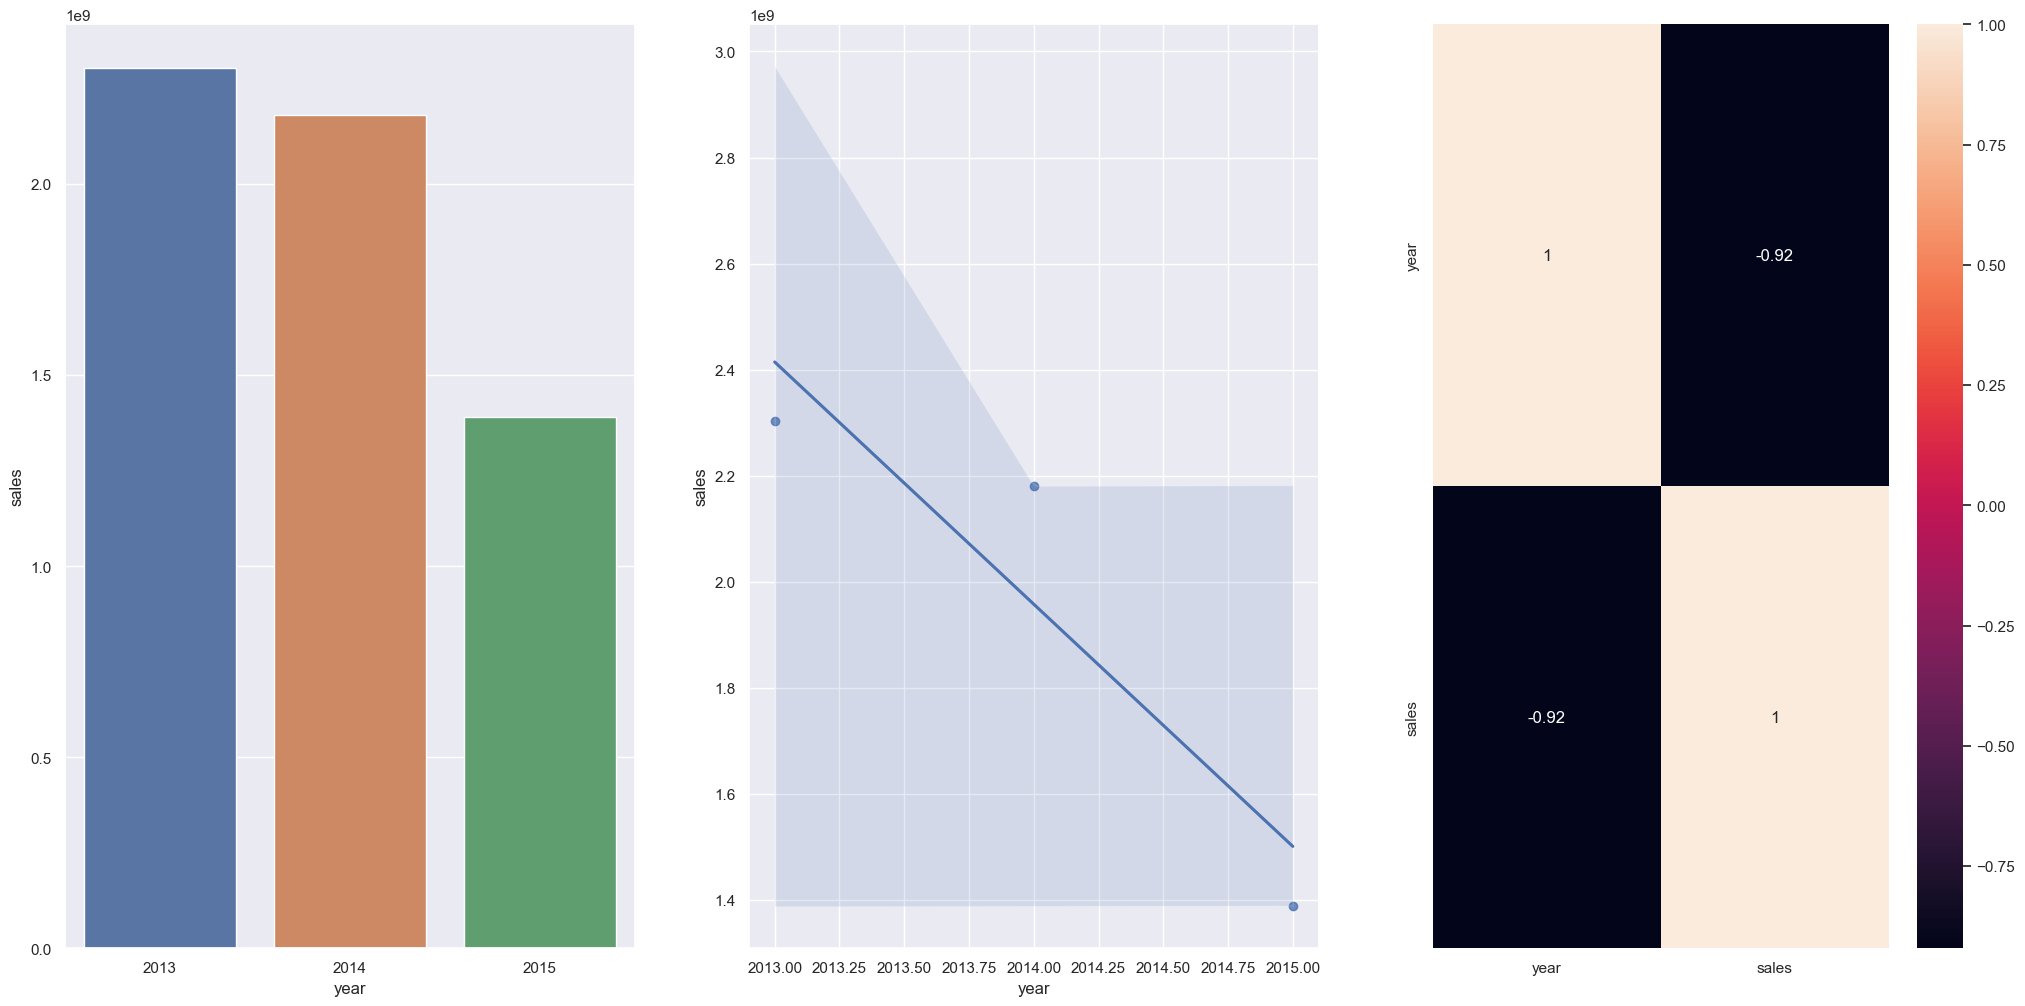

In [53]:
#agrupar ano e vendas
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

#grafico de barras
plt.subplot(1,3,1)
sns.barplot( x= 'year', y= 'sales', data = aux1);

#Grafico de tendencia
plt.subplot(1,3,2)
sns.regplot( x = 'year',y = 'sales', data = aux1);

#mapa de calor - heatmap
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True );

### 4.2.10 Hipótese 10: Lojas deveriam vender mais no segundo semetre do ano
Falso: Lojas vendem menos no segundo semetre do ano

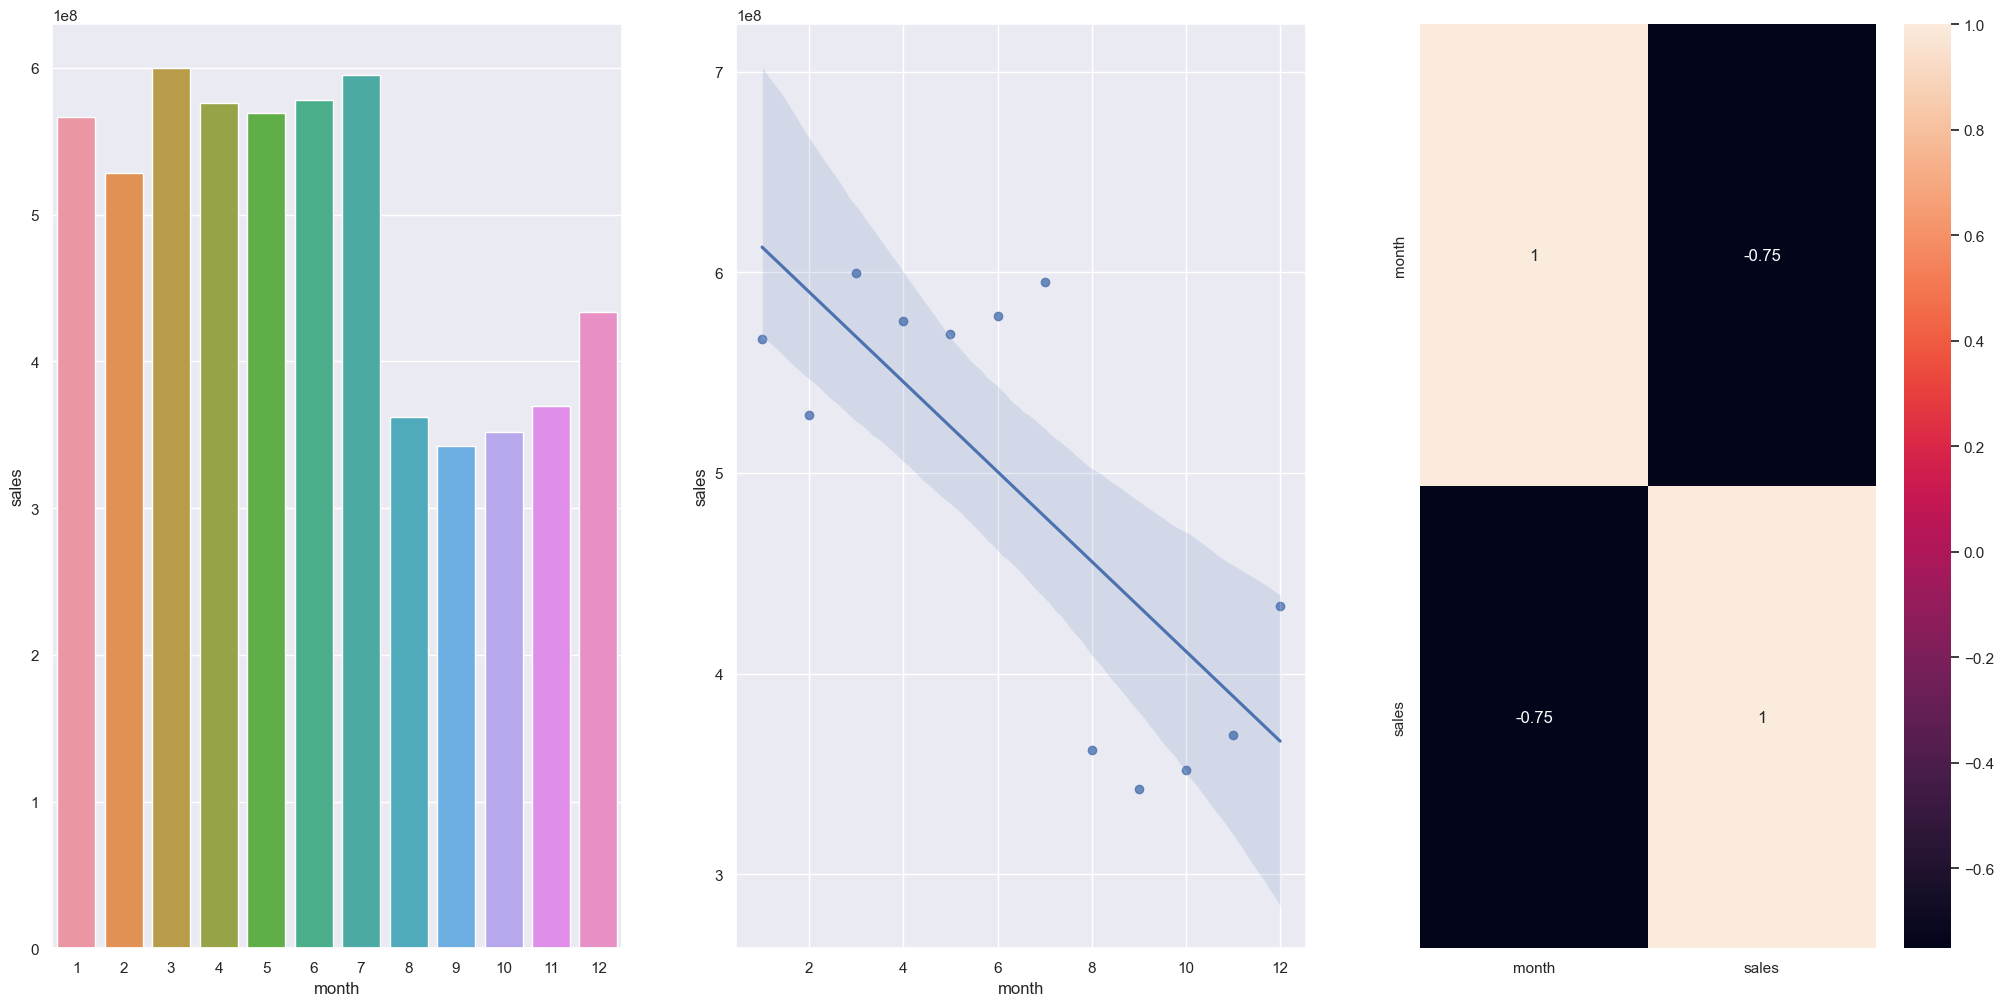

In [54]:
#agrupamento mes e vendas
aux1 = df4[ ['month','sales'] ].groupby('month').sum().reset_index()

plt.subplot( 1,3,1)
sns.barplot( x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot( x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method = 'pearson'), annot = True);

### 4.2.11 Hipótese 11: Lojas deviram vender mais depois do dia 10 de cada mês
Verdadeiro: Lojas vendem mais depois do dia 10 de cada mês

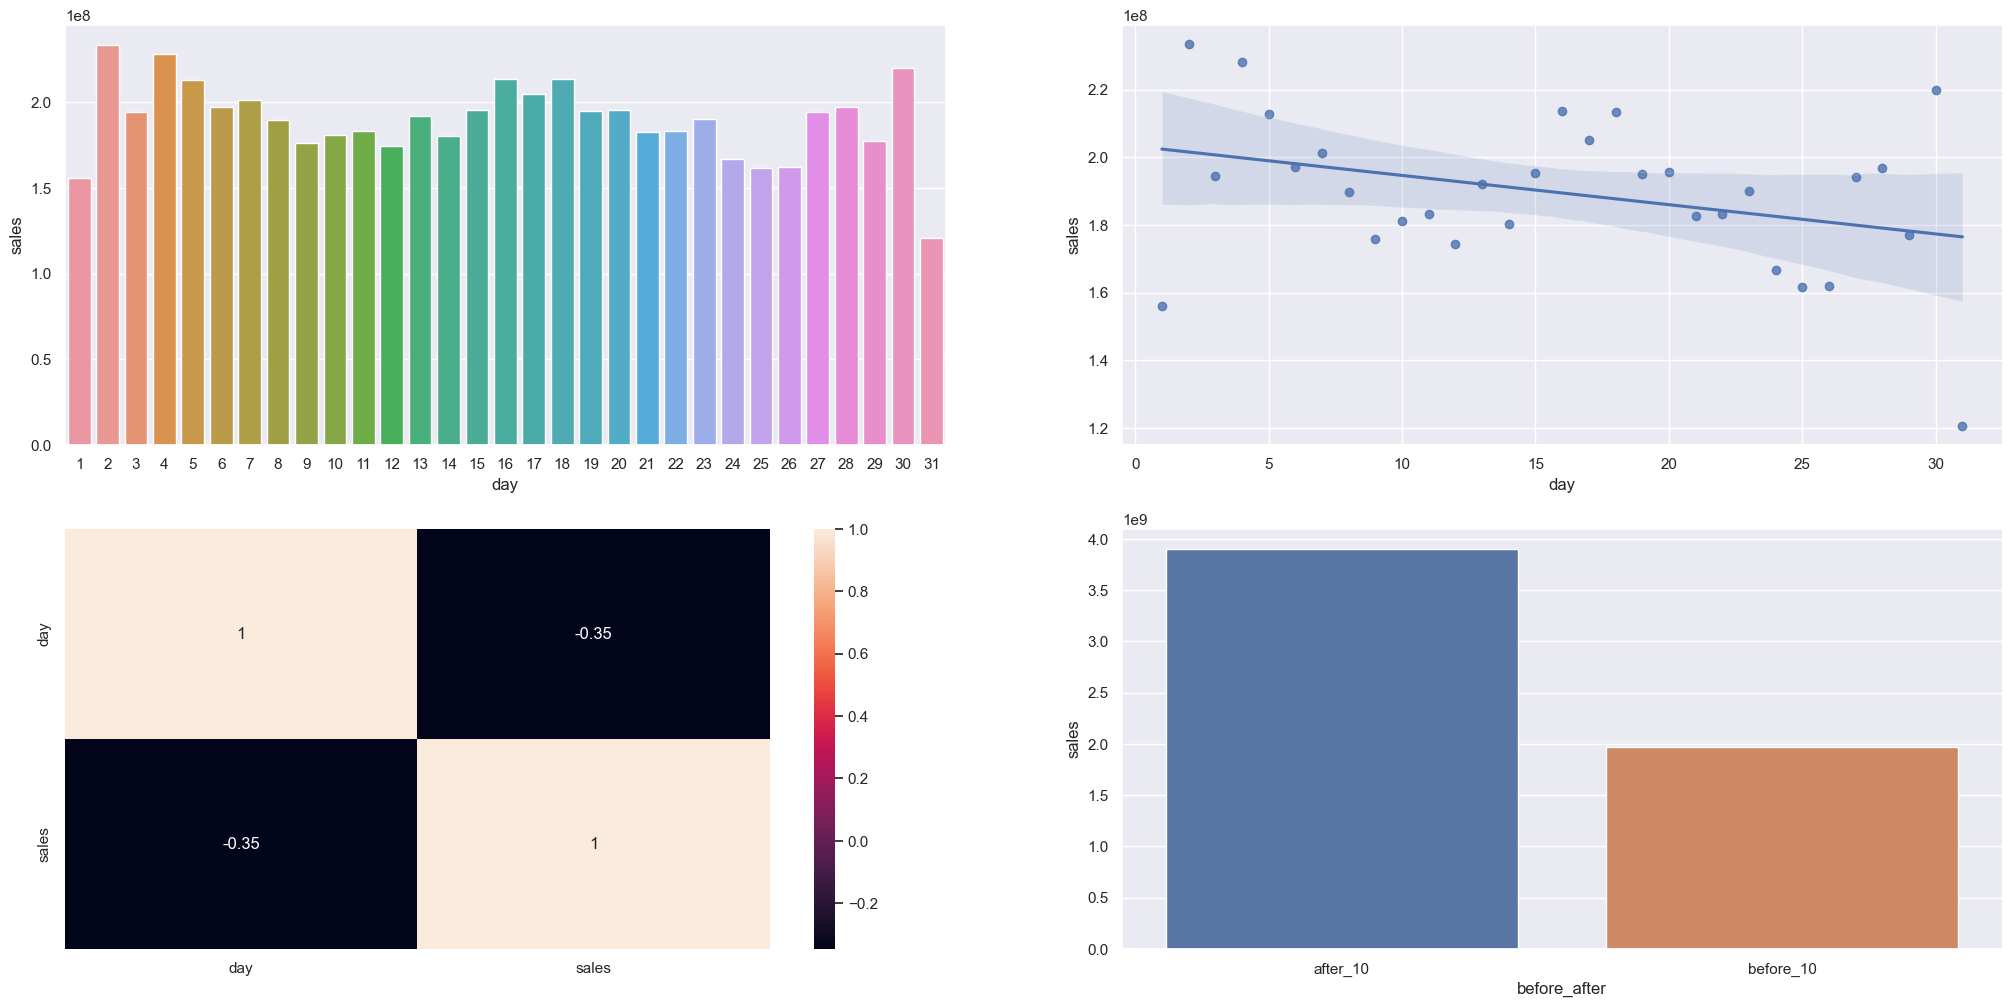

In [55]:
#agrupar vendas por dia 
aux1 = df4[ [ 'day','sales'] ].groupby('day').sum().reset_index()

#grafico de barras
plt.subplot(2,2,1)
sns.barplot(x = 'day',y='sales', data = aux1);

#grafico de tendencia
plt.subplot(2,2,2)
sns.regplot( x ='day',y = 'sales',data = aux1);

#Mapa de calor -Heatmap
plt.subplot(2,2,3)
sns.heatmap( aux1.corr(method = 'pearson'), annot = True );

#Inserir coluna que recebe antes e depois do dia 10 
aux1['before_after'] = aux1[ 'day'].apply( lambda x: 'before_10' if x <= 10 else 'after_10' )

aux2 = aux1[ ['before_after','sales'] ].groupby( 'before_after' ).sum().reset_index()
plt.subplot(2,2,4)
sns.barplot(x = 'before_after',y= 'sales', data = aux2);

### 4.2.12 Hipótese 12: Lojas deveriam vender menos aos finais de semana
Verdadeira: Lojas vendem menos aos finais de semana

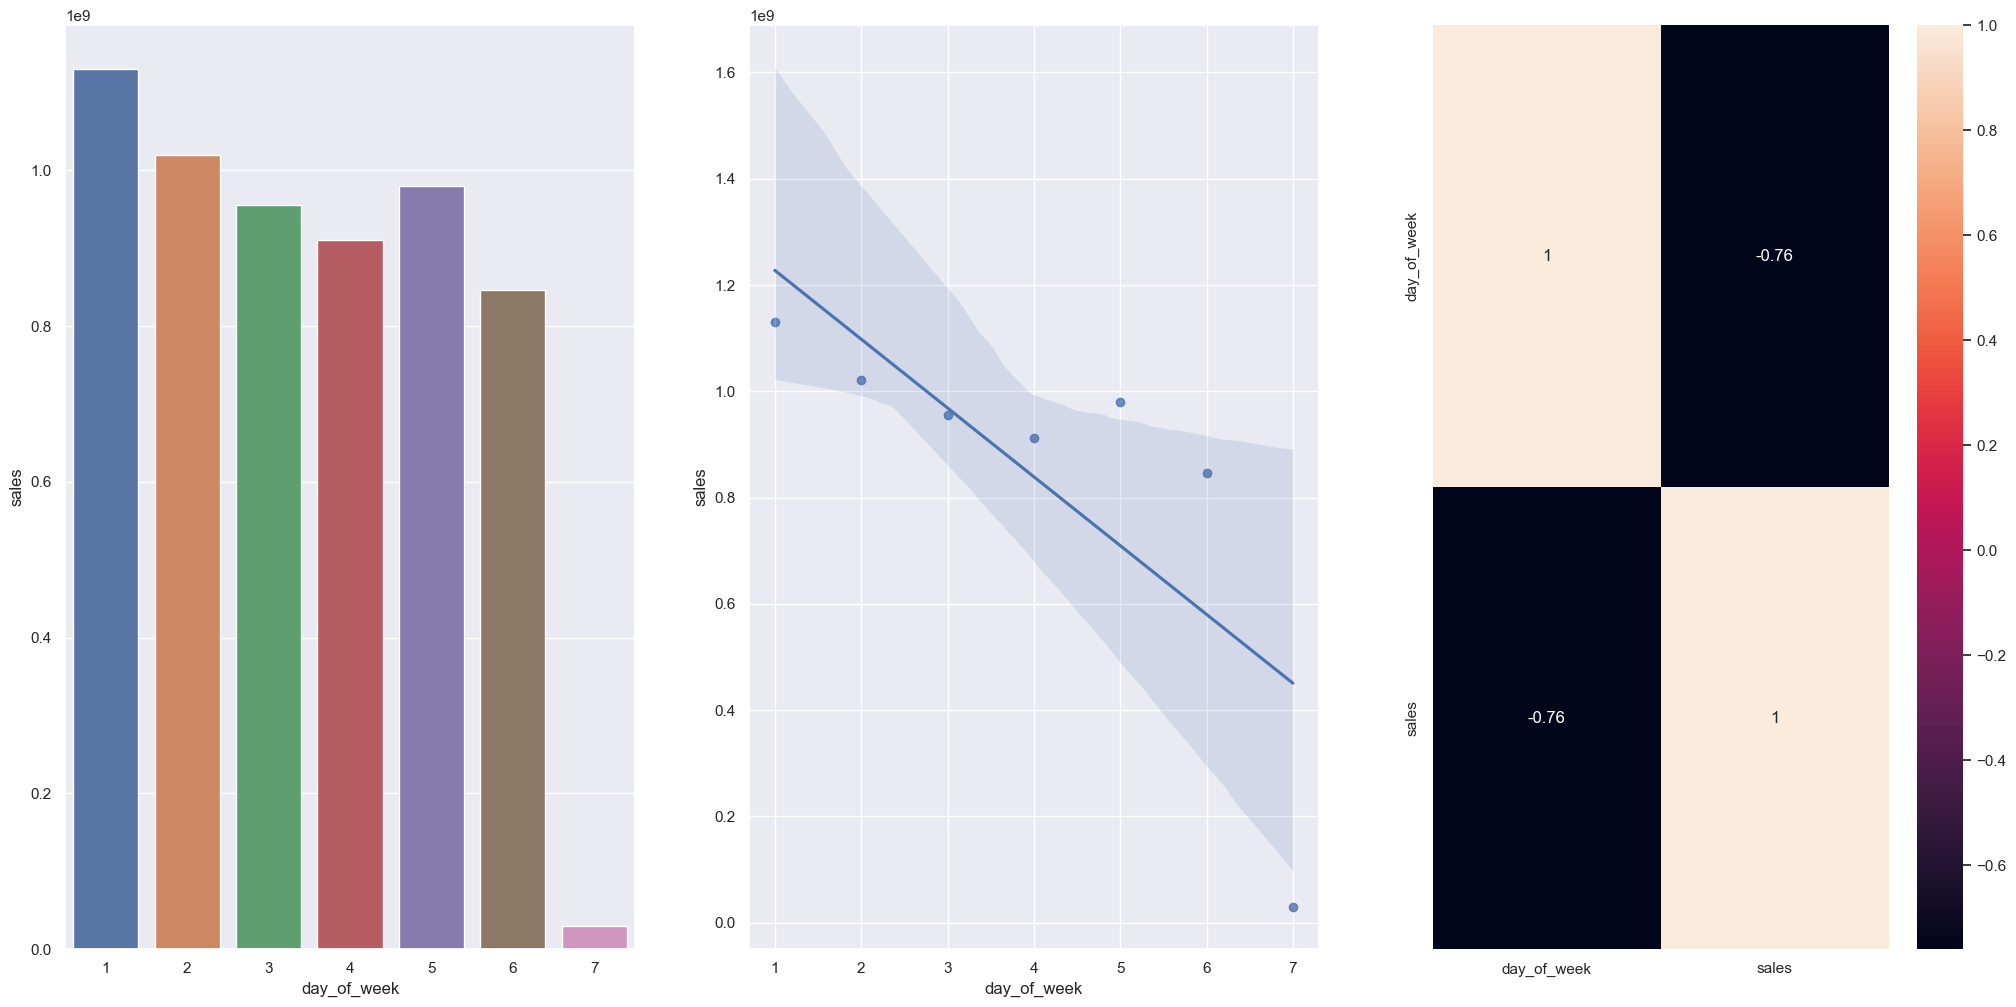

In [56]:
#agrupar vendas por dia da semana
aux1 = df4[ ['day_of_week','sales'] ].groupby('day_of_week').sum().reset_index()

#grafico de barras
plt.subplot(1,3,1)
sns.barplot( x = 'day_of_week', y = 'sales', data = aux1 );

#grafico de tendencia
plt.subplot(1,3,2)
sns.regplot( x = 'day_of_week', y = 'sales', data = aux1);

#Mapa de calor - heatmap - grafico de correlacao
plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True );


### 4.3.1 Resumo Análise Bivariada

In [57]:
from tabulate import tabulate

In [58]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia', 'Variavel'    ],
      ['H1',  'Verdadeira', 'Baixa', 'assortment'            ],  
      ['H2',  'Falsa',      'Media', 'competition_distance'  ],  
      ['H3',  'Falsa',      'Media', 'competition_time_month'],
      ['H4',  'Falsa',      'Baixa', 'promo_time_week'       ],
      ['H5',  '-',          '-'    , '-'                     ],
      ['H6',  'Falsa',      'Baixa', 'promo - promo2'        ],
      ['H7',  'Falsa',      'Media', 'state_holiday'         ],
      ['H8',  'Verdadeira', 'Alta',  'school_holiday'        ],
      ['H9',  'Falsa',      'Alta',  'year'                  ],
      ['H10', 'Falsa',      'Alta',  'month'                 ],
      ['H11', 'Verdadeira', 'Alta',  'day'                   ],
      ['H12', 'Verdadeira', 'Alta',  'day_of_week'           ],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia    Variavel
-----------  -----------  ------------  ----------------------
H1           Verdadeira   Baixa         assortment
H2           Falsa        Media         competition_distance
H3           Falsa        Media         competition_time_month
H4           Falsa        Baixa         promo_time_week
H5           -            -             -
H6           Falsa        Baixa         promo - promo2
H7           Falsa        Media         state_holiday
H8           Verdadeira   Alta          school_holiday
H9           Falsa        Alta          year
H10          Falsa        Alta          month
H11          Verdadeira   Alta          day
H12          Verdadeira   Alta          day_of_week


## 4.3 Análise Multivariada 

### 4.3.1 Variáveis Numéricas

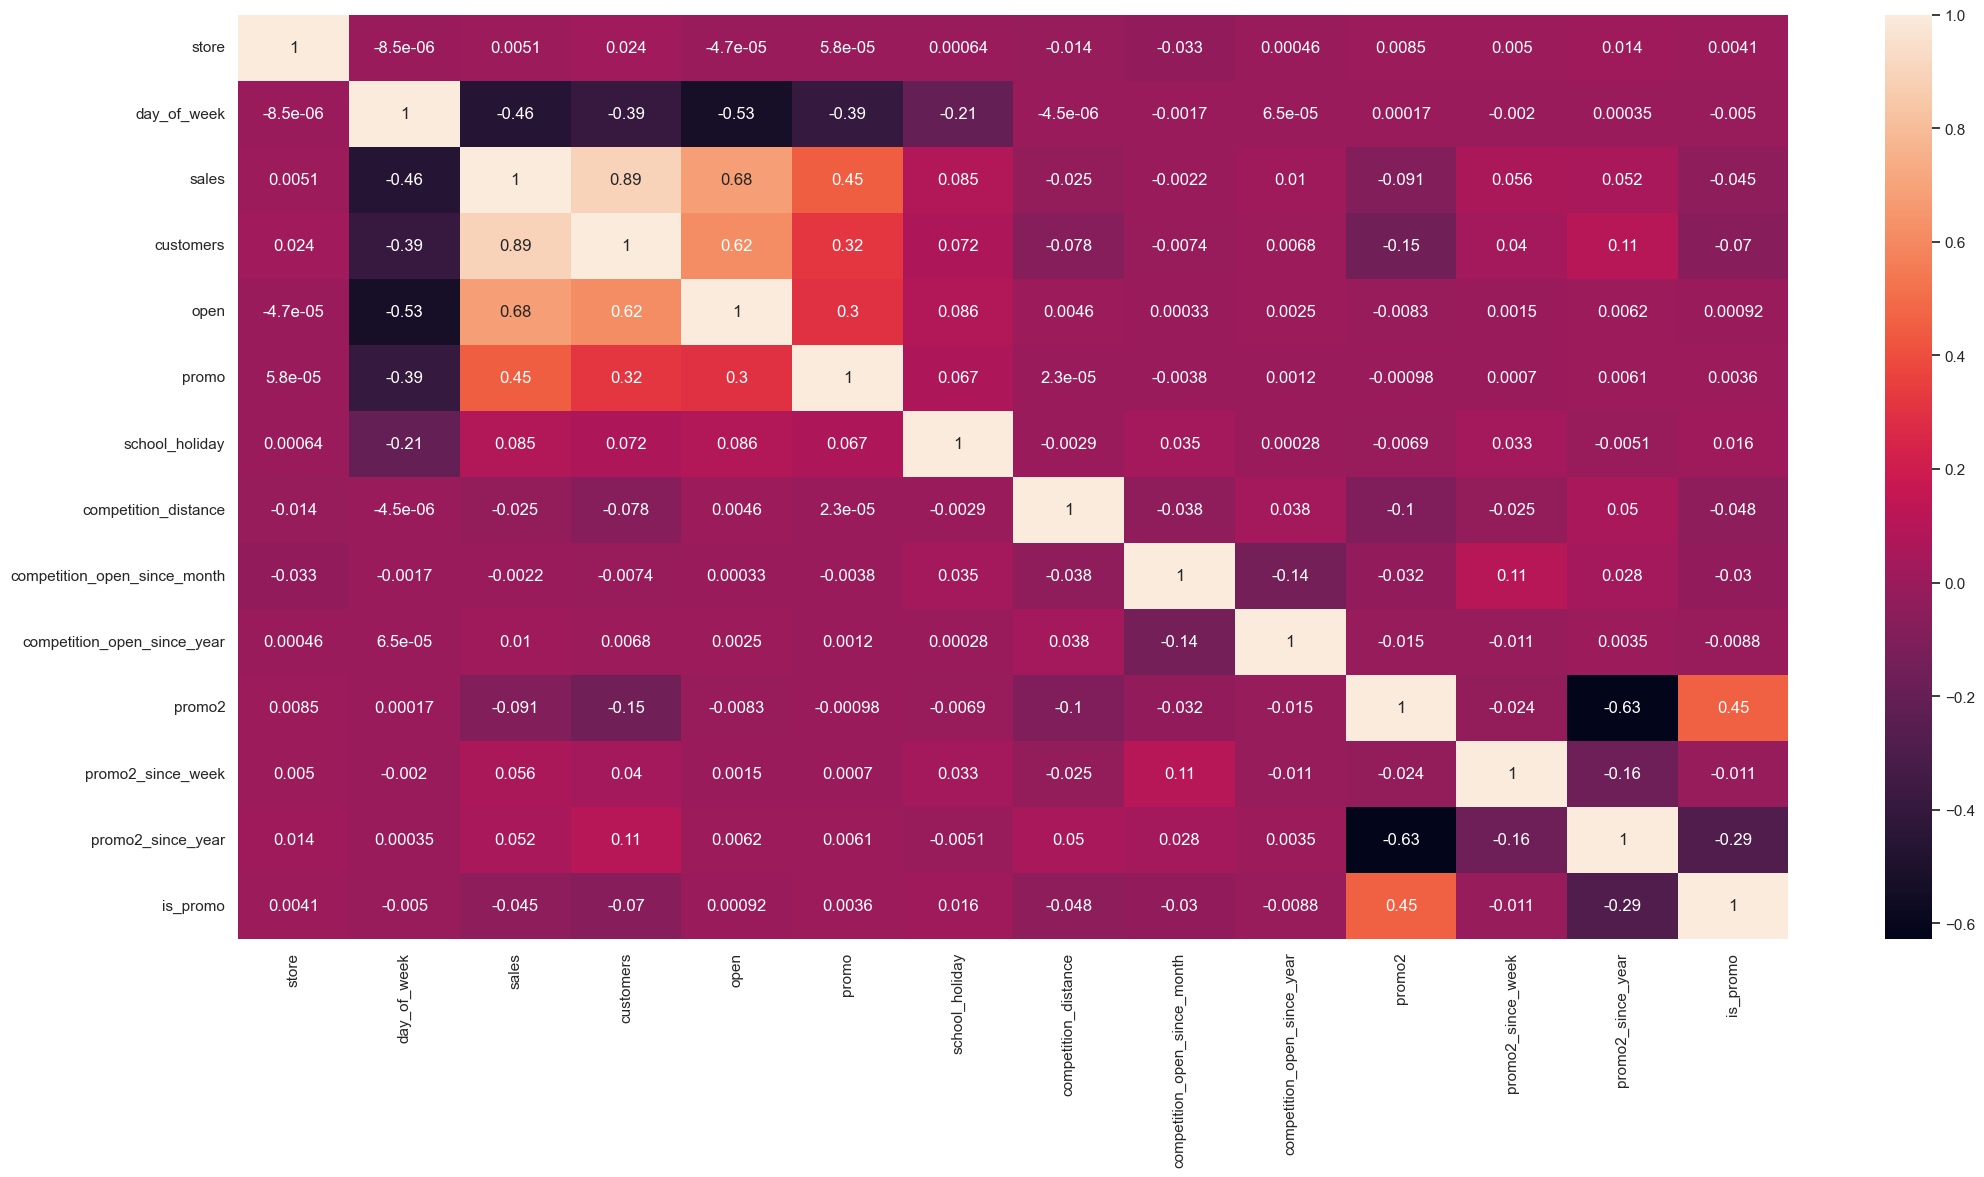

In [59]:
correlation = num_attributes.corr( method = 'pearson' )
sns.heatmap( correlation, annot = True );

### 4.3.2 Variáveis Categoricas

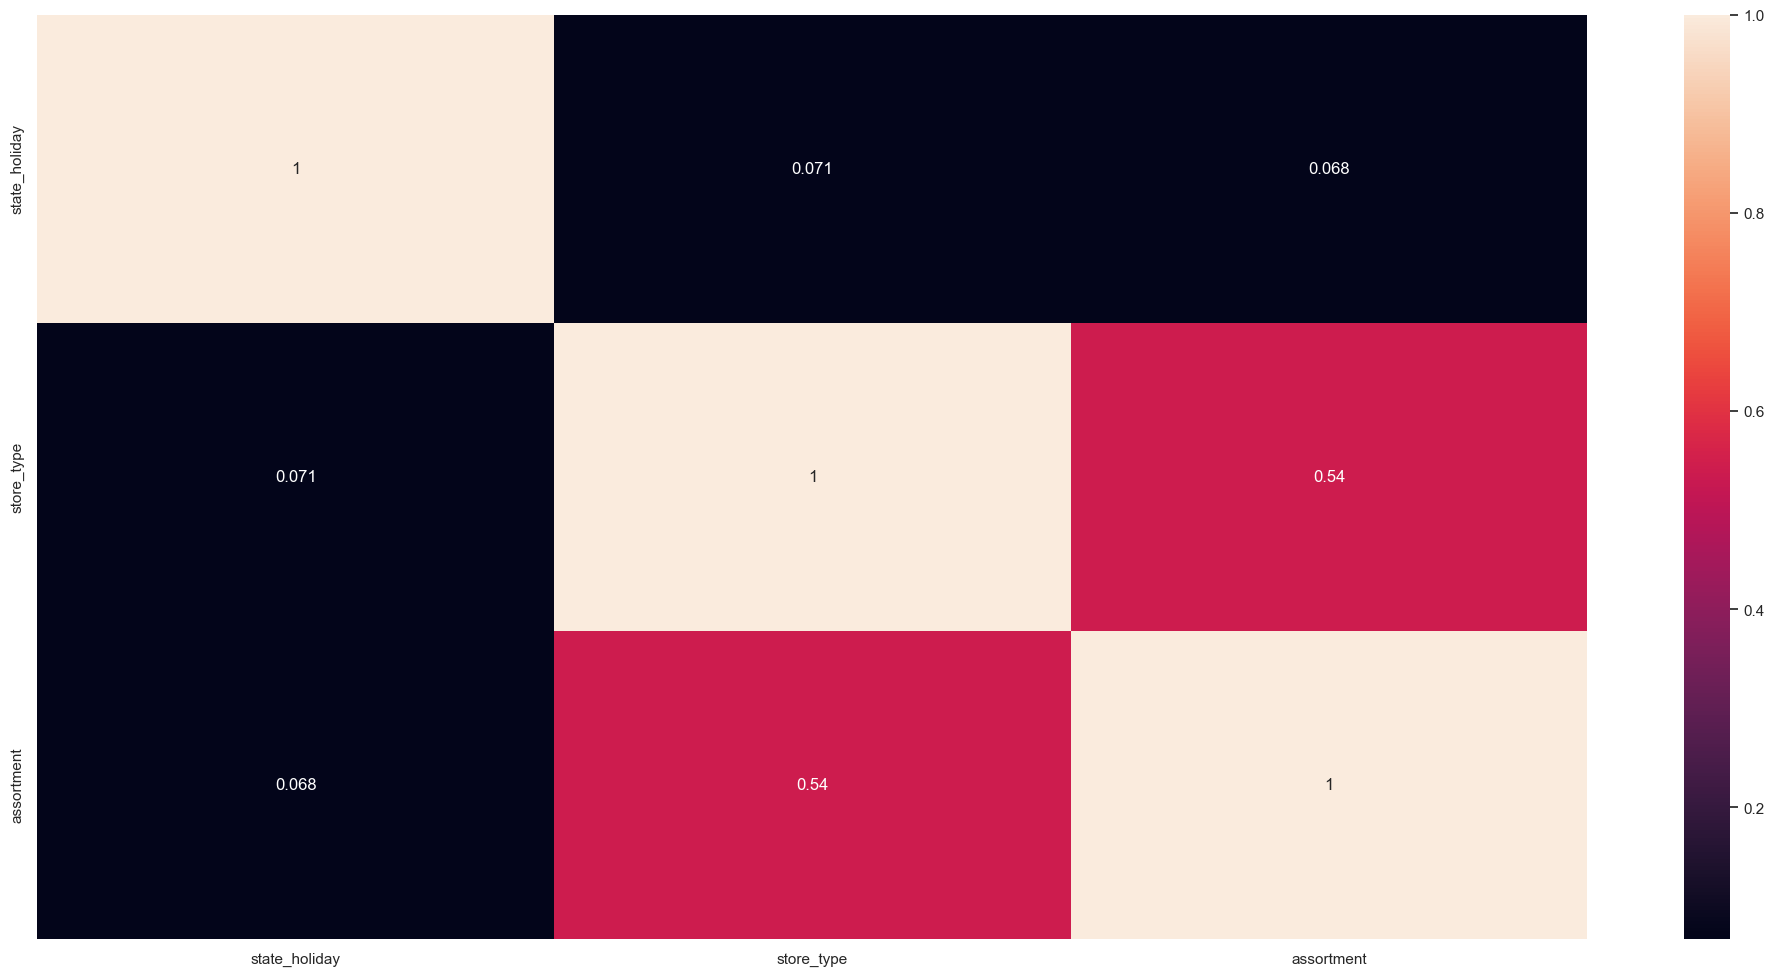

In [60]:
# Somente variaveis categoricas
a = df4.select_dtypes( include = ['object'] )

#calculo cramer v (forca de associacao) para cada variavel categorica

#state_holiday
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type']    )
a3 = cramer_v( a['state_holiday'], a['assortment']    )

#store_type
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type']    )
a6 = cramer_v( a['store_type'], a['assortment']    )

#assortment

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type']    )
a9 = cramer_v( a['assortment'], a['assortment']    )

#criando tabela
aux1 = pd.DataFrame( { 'state_holiday': [ a1, a2, a3 ],
                       'store_type':    [ a4, a5, a6 ],
                       'assortment':    [ a7, a8, a9 ] } )

aux1 = aux1.set_index( aux1.columns )

#Heatmap 
sns.heatmap( aux1, annot = True );

# 5.0 PREPARAÇÃO DOS DADOS

In [61]:
df5 = df4.copy()

## 5.1 Variáveis Numéricas

### 5.1.1 Normalization

In [62]:
# Não há variaveis com caracteristicas de distribuição normal

### 5.1.2 Rescaling

In [63]:
aux1 = df5.select_dtypes( include = ['int64','float64'] )
aux1.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.00,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.00,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.00,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.00,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.00,4,2015,0,31,2015,0,2015,7,31,31,4,0


In [64]:
# atribuir metodos de Rescaling a novas variaveis
rs  = RobustScaler()
mms = MinMaxScaler()

#Calcular Robust Scaler
df5['competition_distance']   = rs.fit_transform( df5[ ['competition_distance'  ] ].values )
#pickle
pickle.dump( rs, open( '/home/deivison/Documentos/projetos/dsrossmann/notebooks/parameters/competition_distance_scaler.pkl','wb' ) )

df5['competition_time_month'] = rs.fit_transform( df5[ ['competition_time_month'] ].values )
#pickle
pickle.dump( rs, open( '/home/deivison/Documentos/projetos/dsrossmann/notebooks/parameters/competition_time_month_scaler.pkl','wb' ) )

#calcular Min-Max Scaler
df5['promo_time_week'] = mms.fit_transform( df5[ [ 'promo_time_week'] ].values )
#pickle
pickle.dump( mms, open( '/home/deivison/Documentos/projetos/dsrossmann/notebooks/parameters/promo_time_week_scaler.pkl','wb' ) )

df5['year']            = mms.fit_transform( df5[ [ 'year'           ] ].values )
#pickle
pickle.dump( mms, open( '/home/deivison/Documentos/projetos/dsrossmann/notebooks/parameters/year_scaler.pkl','wb' ) )

## 5.2 Enconding

In [65]:
#state_holiday - One Hot Enconding
df5 = pd.get_dummies( df5, prefix = ['state_holiday'], columns = ['state_holiday'] )

# Store_type - Label Enconding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
#pickle
pickle.dump( le, open( '/home/deivison/Documentos/projetos/dsrossmann/notebooks/parameters/store_type_scaler.pkl','wb' ) )

# Assortment - Ordinal Enconding
assortment_dict = { 'basic':1, 'extra':2, 'extended':3 }
df5['assortment'] = df5['assortment'].map( assortment_dict)

## 5.3 Transformação

### 5.3.1 Variável Resposta

In [66]:
df5['sales'] = np.log1p( df5['sales'] )

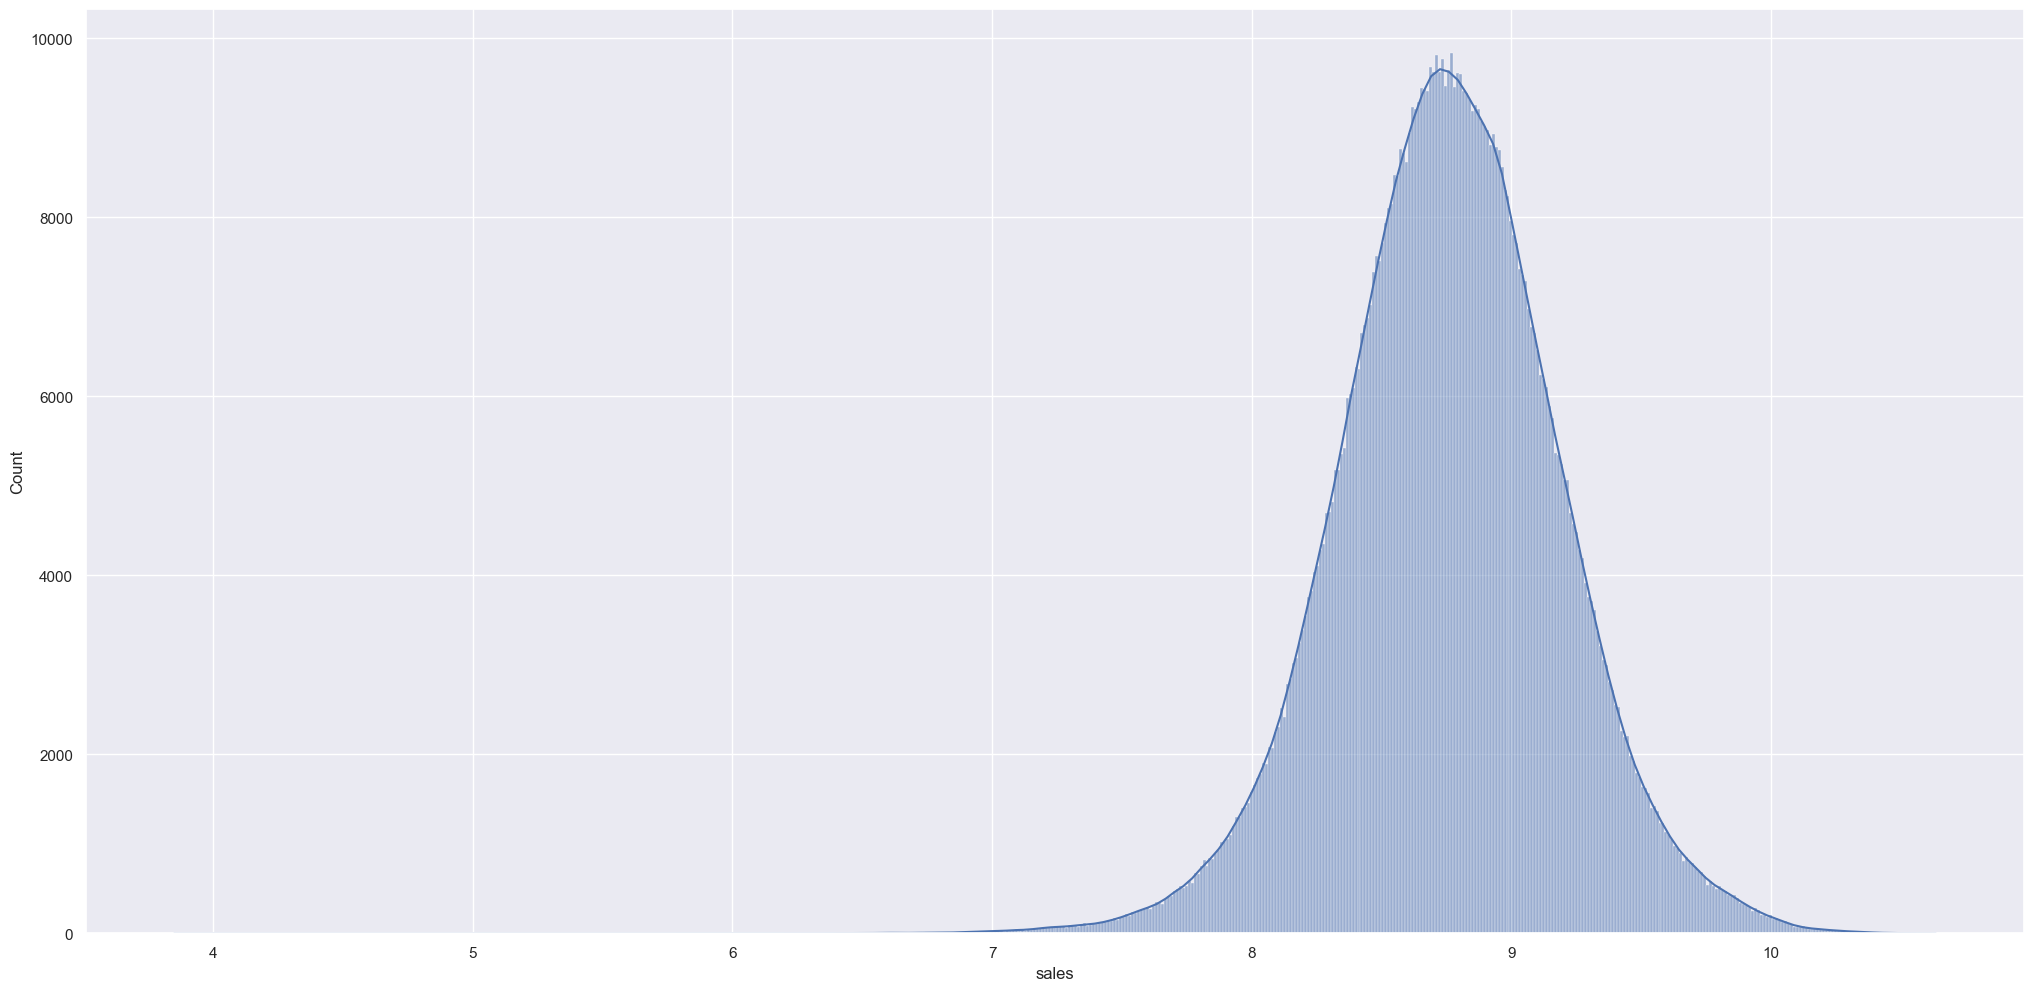

In [67]:
sns.histplot(df5['sales'], kde = True);

### 5.3.2 Transformação de Natureza

In [68]:
#month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2 * np.pi / 12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2 * np.pi / 12 ) ) )

#day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2 * np.pi / 7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2 * np.pi / 7 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2 * np.pi / 30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2 * np.pi / 30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2 * np.pi / 52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2 * np.pi / 52 ) ) )


In [69]:
df5.head(10)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.57,1,1,2,1,-0.17,9,2008,0,31,2015,0,1.00,7,31,31,2015-30,2008-09-01,0.92,2015-07-27,0.29,0,0,0,1,-0.50,-0.87,-0.97,-0.22,0.21,0.98,-0.57,-0.82
1,2,5,2015-07-31,8.71,1,1,0,1,-0.28,11,2007,1,13,2010,1,1.00,7,31,31,2015-30,2007-11-01,1.05,2010-03-22,0.92,0,0,0,1,-0.50,-0.87,-0.97,-0.22,0.21,0.98,-0.57,-0.82
2,3,5,2015-07-31,9.03,1,1,0,1,1.90,12,2006,1,14,2011,1,1.00,7,31,31,2015-30,2006-12-01,1.20,2011-03-28,0.80,0,0,0,1,-0.50,-0.87,-0.97,-0.22,0.21,0.98,-0.57,-0.82
3,4,5,2015-07-31,9.55,1,1,2,3,-0.28,9,2009,0,31,2015,0,1.00,7,31,31,2015-30,2009-09-01,0.74,2015-07-27,0.29,0,0,0,1,-0.50,-0.87,-0.97,-0.22,0.21,0.98,-0.57,-0.82
4,5,5,2015-07-31,8.48,1,1,0,1,4.45,4,2015,0,31,2015,0,1.00,7,31,31,2015-30,2015-04-01,-0.16,2015-07-27,0.29,0,0,0,1,-0.50,-0.87,-0.97,-0.22,0.21,0.98,-0.57,-0.82
5,6,5,2015-07-31,8.64,1,1,0,1,-0.33,12,2013,0,31,2015,0,1.00,7,31,31,2015-30,2013-12-01,0.05,2015-07-27,0.29,0,0,0,1,-0.50,-0.87,-0.97,-0.22,0.21,0.98,-0.57,-0.82
6,7,5,2015-07-31,9.64,1,1,0,3,3.50,4,2013,0,31,2015,0,1.00,7,31,31,2015-30,2013-04-01,0.16,2015-07-27,0.29,0,0,0,1,-0.50,-0.87,-0.97,-0.22,0.21,0.98,-0.57,-0.82
7,8,5,2015-07-31,9.05,1,1,0,1,0.84,10,2014,0,31,2015,0,1.00,7,31,31,2015-30,2014-10-01,-0.08,2015-07-27,0.29,0,0,0,1,-0.50,-0.87,-0.97,-0.22,0.21,0.98,-0.57,-0.82
8,9,5,2015-07-31,9.06,1,1,0,3,-0.05,8,2000,0,31,2015,0,1.00,7,31,31,2015-30,2000-08-01,2.24,2015-07-27,0.29,0,0,0,1,-0.50,-0.87,-0.97,-0.22,0.21,0.98,-0.57,-0.82
9,10,5,2015-07-31,8.88,1,1,0,1,0.13,9,2009,0,31,2015,0,1.00,7,31,31,2015-30,2009-09-01,0.74,2015-07-27,0.29,0,0,0,1,-0.50,-0.87,-0.97,-0.22,0.21,0.98,-0.57,-0.82


# 6.0 SELEÇÃO DE VARIÁVEIS

In [70]:
df6 = df5.copy()

## 6.1 Separar Dataframes de treino e teste

In [71]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [72]:
#Data Training
X_train = df6[ df6['date'] < '2015-06-19' ]
Y_train = X_train['sales']

#data test
X_test =  df6[ df6['date'] >= '2015-06-19' ]
Y_test = X_test['sales']

#check dates
print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta - Seleção de Variáveis

In [73]:
# # Training dataset -- Test dataset -- for boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# Y_train_n = Y_train.values.ravel()

# #Define random forest
# rf = RandomForestRegressor(n_jobs = -1 )

# #define Boruta
# boruta = BorutaPy( rf, n_estimators= 'auto', verbose = 2, random_state = 42).fit( X_train_n, Y_train_n)


### 6.2.1 Melhores variáveis selecionadas pelo Boruta

In [74]:
# #transfomar resultado boruta em uma lista
# cols_selected = boruta.support_.tolist()

# #Best Features
# Xtrain_fs = X_train.drop( ['date','sales'] , axis = 1 )
# cols_selected_boruta = X_train_fs.iloc[ :, cols_selected ].columns.to_list()

# #Colunas nao selecionadas pelo Boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta) )


In [75]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia', 'Variavel', 'Boruta'    ],
      ['H1',  'Verdadeira', 'Baixa', 'assortment'            , 'Alta'  ],  
      ['H2',  'Falsa',      'Media', 'competition_distance'  , 'Alta'  ],  
      ['H3',  'Falsa',      'Media', 'competition_time_month', 'Alta'  ],
      ['H4',  'Falsa',      'Baixa', 'promo_time_week'       , 'Alta'  ],
      ['H5',  '-',          '-'    , '-'                     , ''      ],
      ['H6',  'Falsa',      'Baixa', 'promo - promo2'        , 'Alta'  ],
      ['H7',  'Falsa',      'Media', 'state_holiday'         , 'Baixa' ],
      ['H8',  'Verdadeira', 'Alta',  'school_holiday'        , 'Baixa' ],
      ['H9',  'Falsa',      'Alta',  'year'                  , 'Baixa' ],
      ['H10', 'Falsa',      'Alta',  'month'                 , 'Alta'  ],
      ['H11', 'Verdadeira', 'Alta',  'day'                   , 'Alta'  ],
      ['H12', 'Verdadeira', 'Alta',  'day_of_week'           , 'Alta'  ],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia    Variavel                Boruta
-----------  -----------  ------------  ----------------------  --------
H1           Verdadeira   Baixa         assortment              Alta
H2           Falsa        Media         competition_distance    Alta
H3           Falsa        Media         competition_time_month  Alta
H4           Falsa        Baixa         promo_time_week         Alta
H5           -            -             -
H6           Falsa        Baixa         promo - promo2          Alta
H7           Falsa        Media         state_holiday           Baixa
H8           Verdadeira   Alta          school_holiday          Baixa
H9           Falsa        Alta          year                    Baixa
H10          Falsa        Alta          month                   Alta
H11          Verdadeira   Alta          day                     Alta
H12          Verdadeira   Alta          day_of_week             Alta


## 6.3 Seleção Manual das Variáveis Selecionadas

In [76]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

#colunas para adicionar
feat_to_add = ['date','sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [77]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

In [78]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

# 7.0 Machine Learning Modelling

In [79]:
x_train = X_train[cols_selected_boruta]
x_test  = X_test[cols_selected_boruta]
y_train = Y_train
y_test = Y_test
x_training = X_train[cols_selected_boruta_full]

## 7.1 Modelo de Média

In [80]:
#criando dataset de test
aux1 = x_test.copy()

#adicionando variavel vendas 'sales' no dataset de test
aux1['sales'] = Y_test.copy()

#calculando valor predito(media de vendas por loja)
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename( columns = {'sales':'predictions'} )

#juntar dataset de treino com dataset com o valor predito
aux1 = pd.merge( aux1, aux2, how = 'left', on = 'store')

#criar variavel y predito (yhat) e armazenar somente os valores preditos
yhat_baseline = aux1['predictions']

#calcular performance
baseline_result = ml_error( 'Modelo de Media', np.expm1( Y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Modelo de Media,1354.80,0.46,1835.14


In [81]:
baseline_result_cv = baseline_result.copy()
baseline_result_cv.columns = [ 'Model Name','MAE_CV','MAPE_CV', 'RMSE_CV' ]
baseline_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Modelo de Media,1354.80,0.46,1835.14


## 7.2 Regressão Linear

### 7.2.1 Regressão Linear - Modelo Simples

In [82]:
# instanciar modelo de Regressão linear
lr = LinearRegression().fit( x_train, y_train)

#calcular valor predito
yhat = lr.predict(x_test)

#calcular performance
lr_result = ml_error( 'Regressao Linear', np.expm1( y_test ), np.expm1( yhat ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Regressao Linear,1867.09,0.29,2671.05


### 7.2.2 Regressão Linear - Cross Validation

In [83]:
lr_result_cv = cross_validation( x_training, 5, 'Regressao Linear', lr, verbose=False )
lr_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Regressao Linear,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37


## 7.3 Regressão Lasso

### 7.3.1 Regressão Lasso - Modelo Simples

In [84]:
#Instanciar 
lrr = Lasso( alpha = 0.01 ).fit(x_train,y_train)

#prediction
yhat = lrr.predict(x_test)

#performance
lrr_result = ml_error('Regressao Linear - Lasso', np.expm1( y_test), np.expm1( yhat) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Regressao Linear - Lasso,1891.70,0.29,2744.45


### 7.3.2 Regressão Lasso - Cross Validation

In [85]:
lrr_result_cv = cross_validation( x_training, 5, 'Regressao Linear -Lasso', lrr, verbose= False )
lrr_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Regressao Linear -Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


## 7.4 Random Forest Regressor 

### 7.4.1 Random Forest Regressor - Modelo simples 

In [86]:
#instanciar modelo
rf = RandomForestRegressor( n_estimators = 60, n_jobs = -1, random_state = 42 ).fit( x_train, y_train )

#prediction
yhat = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat) )

In [87]:
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,684.80,0.10,1018.64


### 7.4.2 Random Forest Regressor - Cross Validation

In [88]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose = True )


Kfold number: 5

Kfold number: 4

Kfold number: 3

Kfold number: 2

Kfold number: 1


In [89]:
rf_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Random Forest Regressor,841.2+/-219.92,0.12+/-0.02,1261.96+/-322.53


## 7.5 XGboost Regressor

### 7.5.1 XGboost Regressor - Modelo Simples

In [90]:
#instanciar modelo
model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                          n_estimators = 1500,
                          eta = 0.03,
                          max_depth = 5,
                          subsample = 0.7,
                          colsample_bytree = 0.9 ).fit( x_train, y_train )

#predictions
yhat = model_xgb.predict(x_test)

#performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test), np.expm1( yhat) )

In [91]:
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,910.05,0.14,1311.89


### 7.5.2 XGboost Regressor - Cross Validation

In [92]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True )


Kfold number: 5

Kfold number: 4

Kfold number: 3

Kfold number: 2

Kfold number: 1


In [93]:
xgb_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,XGBoost Regressor,1076.19+/-138.01,0.15+/-0.01,1553.2+/-177.57


## 7.6 Comparando os modelos

### 7.6.1 Performance - Modelo Simples

In [94]:
modelling_result = pd.concat( [ baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,684.80,0.10,1018.64
0,XGBoost Regressor,910.05,0.14,1311.89
0,Modelo de Media,1354.80,0.46,1835.14
0,Regressao Linear,1867.09,0.29,2671.05
0,Regressao Linear - Lasso,1891.70,0.29,2744.45


### 7.6.2 Performance real - 5 kfold

In [95]:
modelling_result_cv = pd.concat( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv, baseline_result_cv ] )
modelling_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Regressao Linear,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37
0,Regressao Linear -Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26
0,Random Forest Regressor,841.2+/-219.92,0.12+/-0.02,1261.96+/-322.53
0,XGBoost Regressor,1076.19+/-138.01,0.15+/-0.01,1553.2+/-177.57
0,Modelo de Media,1354.80,0.46,1835.14


# 8.0 HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [96]:
param = {
   'n_estimators': [1500, 1700, 2000, 2500, 3000],
   'eta': [0.01, 0.03],
   'max_depth': [3, 5, 6],
   'subsample': [0.1, 0.5, 0.7],
   'colsample_bytree': [0.3, 0.7, 0.9],
   'min_child_weight': [3, 8, 15]
       }

MAX_EVAL = 5

In [97]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    #hp = { k: random.sample( v, 1 )[0] for k, v in param.items() } DEPRECATION IN VERSION 3.9 --> change to random.choice()
    hp = { k: random.choice( v, 1 )[0] for k, v in param.items() } 
    print( hp )
   
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'], 
                                 eta=hp['eta'], 
                                 max_depth=hp['max_depth'], 
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'] )

    # performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] )
       
final_result

{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 6, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}

Kfold number: 5

Kfold number: 4

Kfold number: 3

Kfold number: 2

Kfold number: 1
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15}

Kfold number: 5

Kfold number: 4

Kfold number: 3

Kfold number: 2

Kfold number: 1
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}

Kfold number: 5

Kfold number: 4

Kfold number: 3

Kfold number: 2

Kfold number: 1
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}

Kfold number: 5

Kfold number: 4

Kfold number: 3

Kfold number: 2

Kfold number: 1
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3}

Kfold number: 5

Kfold number: 4

Kfold number: 3

Kfold number: 2



,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,XGBoost Regressor,866.87+/-116.36,0.12+/-0.01,1240.77+/-163.28
0,XGBoost Regressor,1424.36+/-147.14,0.2+/-0.01,2065.09+/-200.89
0,XGBoost Regressor,1787.11+/-188.79,0.25+/-0.01,2560.5+/-256.54
0,XGBoost Regressor,1443.21+/-151.32,0.2+/-0.01,2086.99+/-195.67
0,XGBoost Regressor,1661.26+/-174.23,0.23+/-0.01,2392.65+/-226.25


## 8.2 Modelo Final

In [98]:
param_tuned = {'n_estimators': 3000,
                'eta': 0.03,
                'max_depth': 5,
                'subsample': 0.7,
                'colsample_bytree': 0.7,
                'min_child_weight': 3  }

In [99]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,764.98,0.11,1100.73


In [100]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.01759492443152097

In [101]:
pickle.dump(model_xgb_tuned, open('/home/deivison/Documentos/projetos/dsrossmann/notebooks/model/model_rossmann.pkl', 'wb') )

# 9.0 RESULTADOS E INTERPRETAÇÃO DOS ERROS

In [102]:
df9 = X_test[cols_selected_boruta_full]

#rescaling
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1( yhat_xgb_tuned )

In [103]:
df9.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,date,sales,predictions
0,1,1,2,1,-0.17,9,2008,0,31,2015,0.92,0.29,-0.97,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82,2015-07-31,5263.00,5736.36
1,2,1,0,1,-0.28,11,2007,1,13,2010,1.05,0.92,-0.97,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82,2015-07-31,6064.00,5914.20
2,3,1,0,1,1.90,12,2006,1,14,2011,1.20,0.80,-0.97,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82,2015-07-31,8314.00,9394.95
3,4,1,2,3,-0.28,9,2009,0,31,2015,0.74,0.29,-0.97,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82,2015-07-31,13995.00,11596.35
4,5,1,0,1,4.45,4,2015,0,31,2015,-0.16,0.29,-0.97,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82,2015-07-31,4822.00,6324.43


## 9.1 Business Performance

### 9.1.1 Análise Loja 1 

In [104]:
loja = df9.copy()

#Selecionando todas as predições da loja 1
loja1 = loja[['store','date','sales','predictions']][loja['store'] == 1 ]

#calculo das metricas de erros da loja 1
loja1['absolut_error'] = np.abs(loja1['sales'] - loja1['predictions'] )
loja1['mae_loja1'] = mean_absolute_error( loja1['sales'], loja1['predictions'] )
loja1['mae_model']  = mean_absolute_error( loja['sales'], loja['predictions'] )
loja1['mape_loja1'] = mean_absolute_percentage_error( loja1['sales'], loja1['predictions'] )
loja1['mape_model'] = mean_absolute_percentage_error( loja['sales'], loja['predictions'] )
loja1['rmse_loja1'] = np.sqrt( mean_squared_error( loja1['sales'], loja1['predictions'] ) )
loja1['rmse_model'] = np.sqrt( mean_squared_error( loja['sales'], loja['predictions'] ) )

loja1.head(10)

,store,date,sales,predictions,absolut_error,mae_loja1,mae_model,mape_loja1,mape_model,rmse_loja1,rmse_model
0,1,2015-07-31,5263.00,5736.36,473.36,312.84,764.98,0.07,0.11,396.94,1100.73
1115,1,2015-07-30,5020.00,5319.93,299.93,312.84,764.98,0.07,0.11,396.94,1100.73
2230,1,2015-07-29,4782.00,5298.15,516.15,312.84,764.98,0.07,0.11,396.94,1100.73
3345,1,2015-07-28,5011.00,5189.02,178.02,312.84,764.98,0.07,0.11,396.94,1100.73
4460,1,2015-07-27,6102.00,5862.17,239.83,312.84,764.98,0.07,0.11,396.94,1100.73
6690,1,2015-07-25,4364.00,4091.71,272.29,312.84,764.98,0.07,0.11,396.94,1100.73
7805,1,2015-07-24,3706.00,3831.54,125.54,312.84,764.98,0.07,0.11,396.94,1100.73
8920,1,2015-07-23,3769.00,3543.85,225.15,312.84,764.98,0.07,0.11,396.94,1100.73
10035,1,2015-07-22,3464.00,3624.73,160.73,312.84,764.98,0.07,0.11,396.94,1100.73
11150,1,2015-07-21,3558.00,3653.08,95.08,312.84,764.98,0.07,0.11,396.94,1100.73


### 9.2.2 Business Performance Table

In [105]:
# somatorio das predictions nas 6 semanas
aux1 = loja[['store', 'sales', 'predictions']].groupby( 'store' ).sum().reset_index()
aux1.columns = ['store','sales_6_weeks','predictions_6_weeks']

# somatorio dos mae nas 6 semanas
aux2 = loja[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] )* x['store'].shape[0]).reset_index().rename( columns={0:'mae_6_weeks'})
aux3 = pd.merge( aux1, aux2, how='inner', on='store' )

#cenários
aux3['worst_scenario'] = aux3['predictions_6_weeks'] - aux3['mae_6_weeks']
aux3['best_scenario']  = aux3['predictions_6_weeks'] + aux3['mae_6_weeks']

#mape de cada loja
aux4 = loja[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'mape_store'})
aux4['mape_store'] = aux4['mape_store'].map( '{:,.3f}'.format )
aux5 = pd.merge( aux3, aux4, how='inner', on='store' )

#mape_modelo
aux5['mape_model'] = mean_absolute_percentage_error(loja['sales'], loja['predictions'])
aux5['mape_model'] = aux5['mape_model'].map( '{:,.3f}'.format )

#rmse de cada loja
aux6 = loja[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_squared_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'rmse_store'}) 
aux6['rmse_store'] = aux6.apply( lambda x: np.sqrt( x['rmse_store']), axis = 1)
b_table = pd.merge( aux5, aux6, how='inner', on='store' )
b_table['rmse_model'] = np.sqrt( mean_squared_error( loja['sales'], loja['predictions'] ) )
b_table.head()

,store,sales_6_weeks,predictions_6_weeks,mae_6_weeks,worst_scenario,best_scenario,mape_store,mape_model,rmse_store,rmse_model
0,1,162320.00,168687.34,11574.96,157112.39,180262.30,0.072,0.115,396.94,1100.73
1,2,182936.00,181478.25,16192.86,165285.39,197671.11,0.088,0.115,615.42,1100.73
2,3,254190.00,264653.25,22480.04,242173.21,287133.29,0.084,0.115,826.60,1100.73
3,4,369378.00,346129.09,31577.83,314551.26,377706.93,0.082,0.115,1085.14,1100.73
4,5,166905.00,173316.08,14777.12,158538.95,188093.20,0.091,0.115,519.66,1100.73


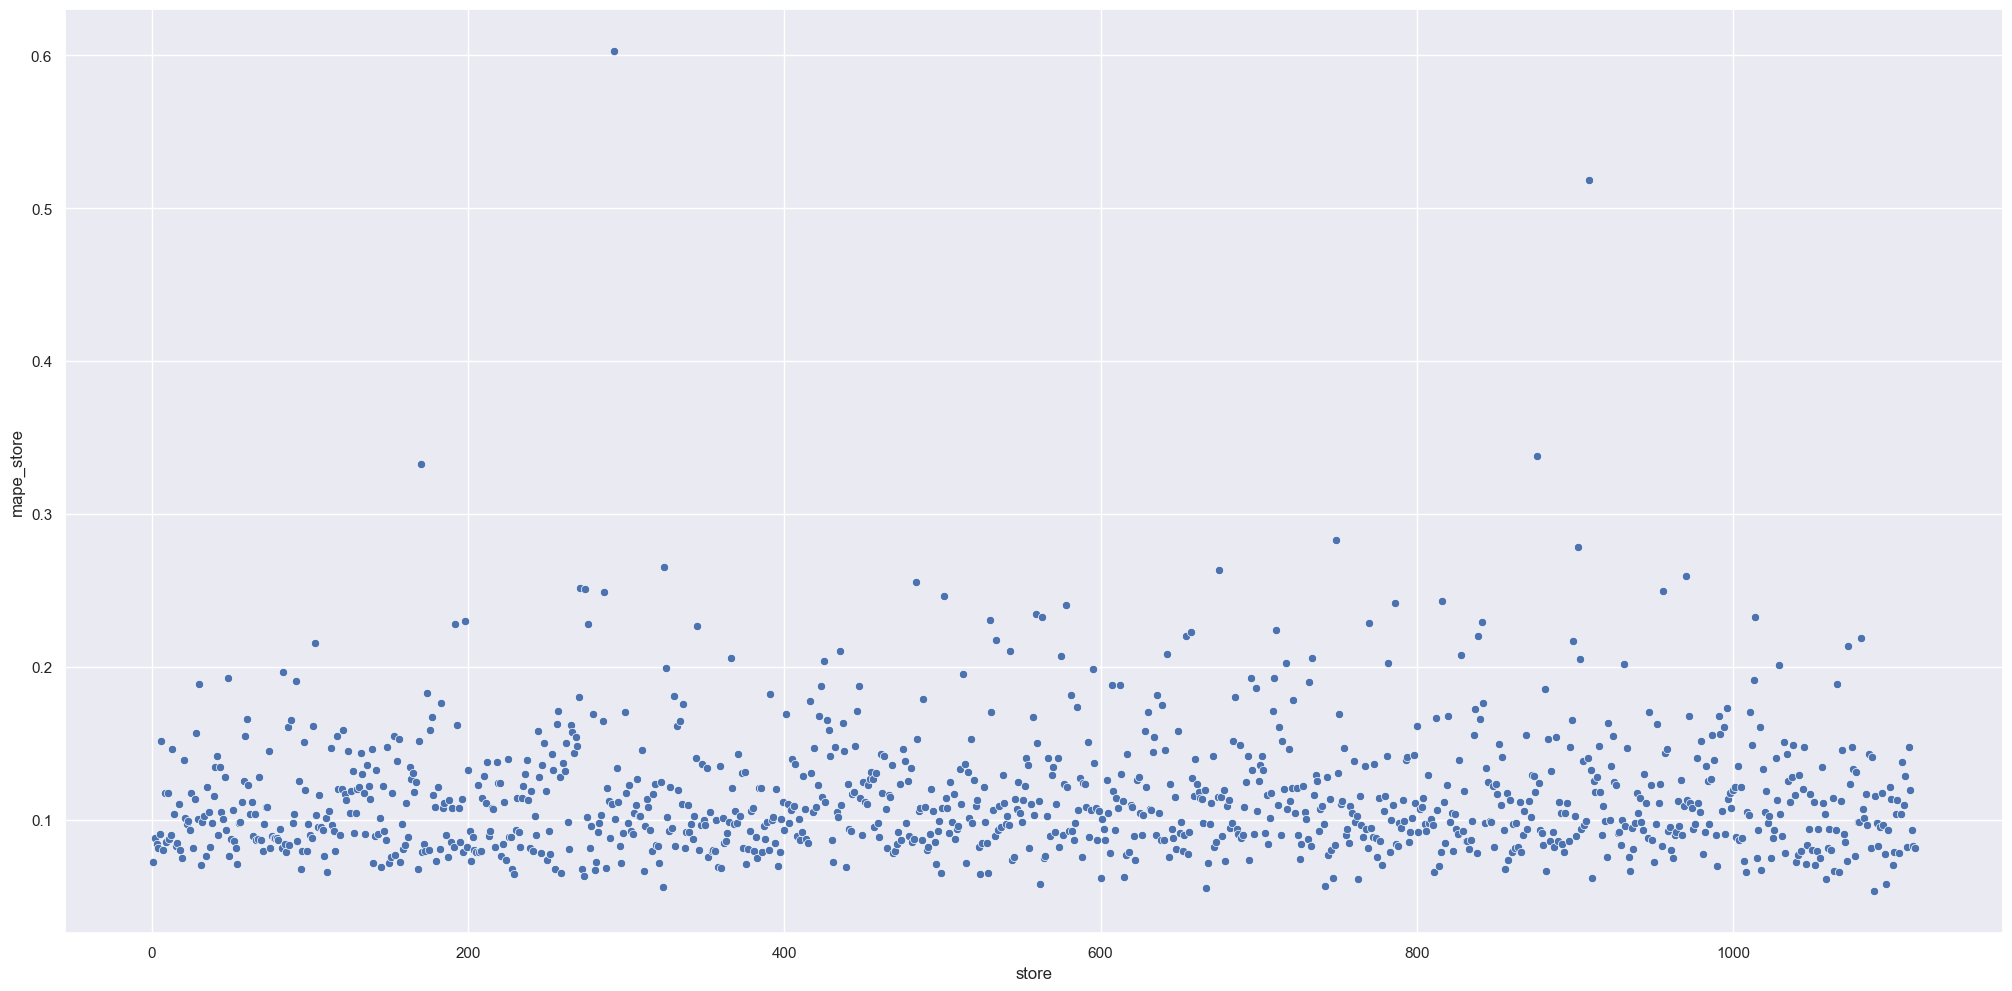

In [106]:
#grafico de dispersao mape de cada loja
aux1 = loja[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'mape_store'})

sns.scatterplot( x= 'store', y = 'mape_store', data = aux1);
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes',  labelsize=20)

## 9.2 Total Business Performance

In [107]:
tbp = b_table[['predictions_6_weeks','worst_scenario','best_scenario']].apply( lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index': 'scenarios', 0: 'values'})
tbp['values'] = tbp['values'].map( '${:,.2f}'.format )
tbp

,scenarios,values
0,predictions_6_weeks,"$286,435,616.00"
1,worst_scenario,"$254,768,674.15"
2,best_scenario,"$318,102,537.29"


## 9.3 Machine Learning Performance

In [108]:
# Erro percentual do modelo
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.01759492443152097

In [109]:
#erro e taxa de erro
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

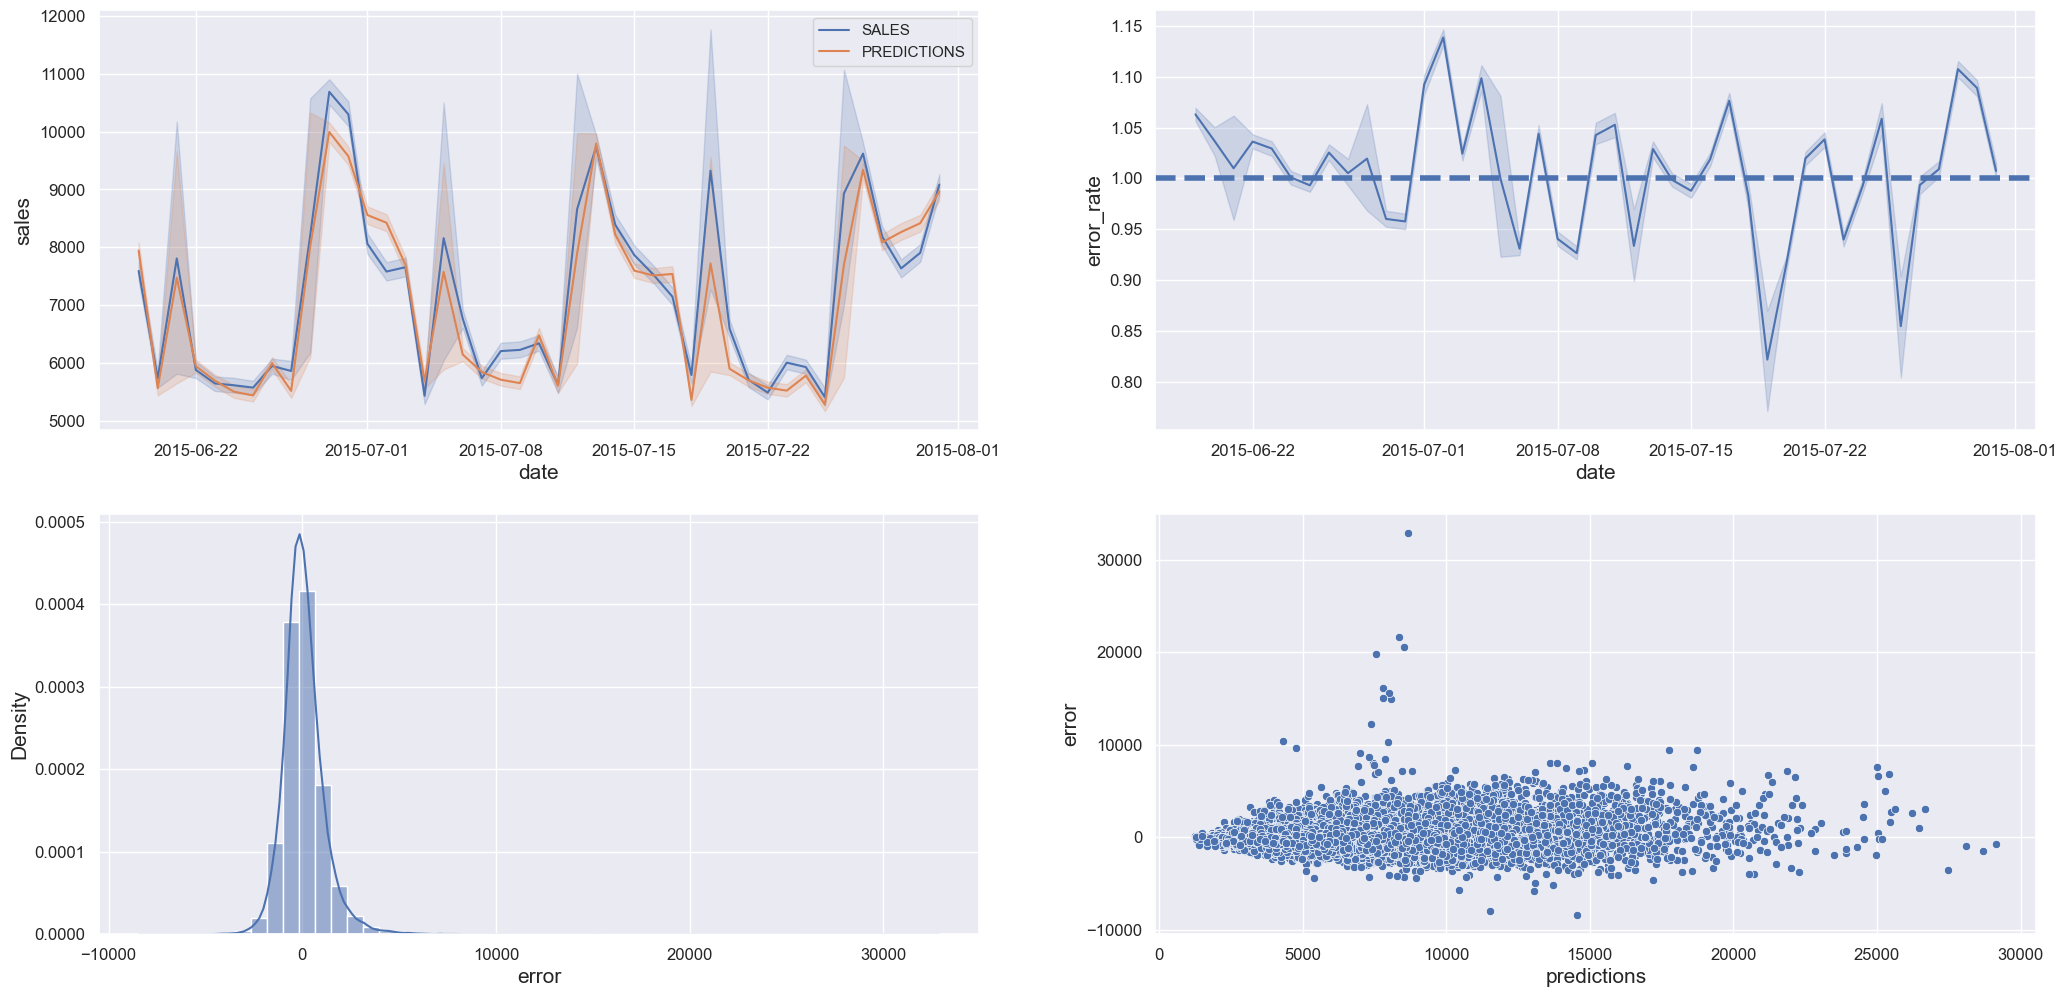

In [110]:
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=15)
# grafico de vendas dia a dia nas 6 semanas
plt.subplot(2,2,1)
sns.lineplot( x = 'date', y = 'sales', data =df9, label = 'SALES')
sns.lineplot( x = 'date', y = 'predictions', data =df9, label = 'PREDICTIONS')

#Gráfico taxa de erro dia a dia nas 6 semanas
plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linewidth=4, linestyle='--')

# Histograma da distribuição do erro
plt.subplot( 2, 2, 3 )
sns.histplot( x = 'error', data = df9, stat = 'density', bins = 50, kde = True);

# Gráfico de Dispersão do erro com relação aos valores preditos
plt.subplot( 2, 2, 4 )
sns.scatterplot( x ='predictions', y = 'error', data = df9 );

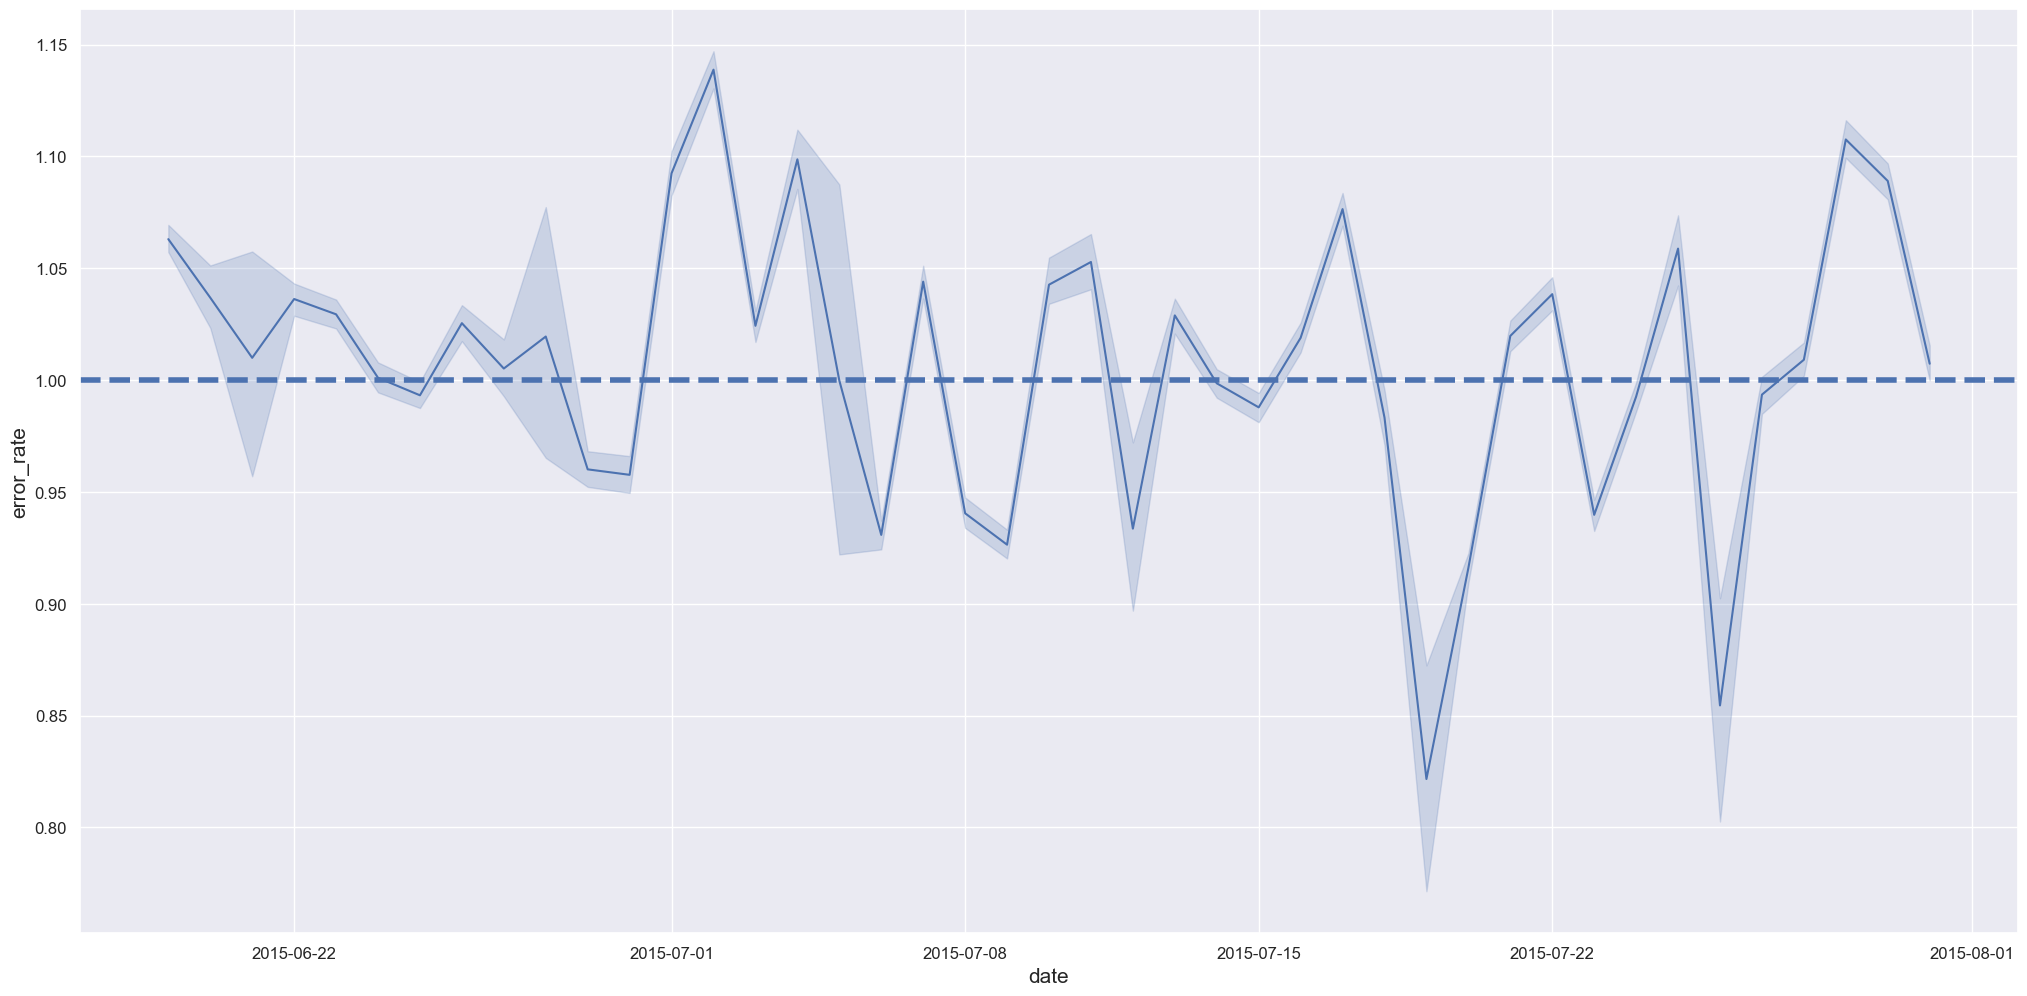

In [111]:
# Gráfico de Dispersão do erro com relação aos valores preditos
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linewidth=4, linestyle='--')

# 10.0 DEPLOY DO MODELO EM PRODUÇÃO

In [112]:
# save Trained Model
#pickle.dump( model_xgb_tuned, open( '/home/deivison/Documentos/projetos/dsrossmann/notebooks/model/model_rossmann.pkl', 'wb'))

#salvando transformações do modulo 5 - Data Preparation

## 10.1 Rossmann Class

In [113]:
# import pickle
# import inflection
# import pandas as pd
# import numpy as np
# import math
# import datetime



# class Rossmann( object ):
    
#     def __init__( self ):
#         self.home_path = '/home/deivison/Documentos/projetos/dsrossmann/notebooks/'
#         self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameters/competition_distance_scaler.pkl','rb' ) )
#         self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameters/competition_time_month_scaler.pkl','rb' ) )
#         self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameters/promo_time_week_scaler.pkl','rb' ) )
#         self.year_scaler                   = pickle.load( open( self.home_path + 'parameters/year_scaler.pkl','rb' ) )
#         self.store_type_scaler             = pickle.load( open( self.home_path + 'parameters/store_type_scaler.pkl','rb' ) )
        
        
#     def data_cleaning( self, df1 ):
        
#         ## 1.1 Rename Columns

#         #copiar nomes das colunas em uma lista

#         cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
#                     'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
#                     'Promo2SinceYear', 'PromoInterval']


#         #transformar nomes das colunas em snake_case

#         snakecase = lambda x: inflection.underscore(x)

#         #mapeando cols_old com snakecase
#         cols_new = list( map(snakecase,cols_old) )

#         df1.columns = cols_new

#         ## 1.3 Data Type

#         #convertendo feature date para formato data
#         df1['date'] = pd.to_datetime( df1['date'] )

#         ## 1.5 Fill NA's

#         #Fill Na's Competition_distance
#         df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000 if math.isnan(x) else x )

#         #Fill NA's competition_open_since_month
#         df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1 )

#         #Fill NA's competition_open_since_month
#         df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1 )

#         #Fill NA's promo2_since_week
#         df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1 )

#         #Fill NA's promo2_since_year
#         df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1 )

#         #Fill NA's promo_interval
#         df1['promo_interval'].fillna( 0 , inplace = True )

#         month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

#         df1['month_map'] = df1['date'].dt.month.map(month_map)

#         df1['is_promo'] = df1[ [ 'promo_interval', 'month_map'] ].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1 )


#         ## 1.6 Change Type

#         #verificar se os tipos dos dados estão adequado para as informações armazenadas nas features
#         df1.dtypes

#         #Alterar feature competition_open_since_month para int64
#         df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )

#         #Alterar feature competition_open_since_year para int64
#         df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

#         #Alterar feature promo2_since_week para int64
#         df1['promo2_since_week'] = df1['promo2_since_week'].astype( int ) 

#         #Alterar feature promo2_since_year para int64
#         df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
#         return df1

#     def featuring_engineering( self, df2 ): 
        
#         ## 2.4 Feature Engineering

#         #year
#         df2['year'] = df2['date'].dt.year

#         #month
#         df2['month'] = df2['date'].dt.month

#         #day
#         df2['day'] = df2['date'].dt.day

#         #week_of_year
#         df2['week_of_year'] = df2['date'].dt.weekofyear

#         #year_week
#         df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#         #competition_time_month
#         df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1 ), axis =1  )
#         df2['competition_time_month'] = ( (df2['date']-df2['competition_since']) / 30 ).apply(lambda x: x.days).astype(int)

#         #promo_time_week
#         df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
#         df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1' , '%Y-%W-%w' ) - datetime.timedelta( days = 7 ) )
#         df2['promo_time_week'] = ( ( df2['date']- df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype(int)

#         #assortment
#         df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

#         #state_holiday
#         df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

#         # 3.0 FILTRAGEM DE VARIAVEIS

#         ## 3.1 Filtragem de linhas

#         df2 = df2[ df2['open'] != 0 ]

#         ## 3.2 Filtragem de colunas

#         cols_drop = [ 'open','promo_interval', 'month_map' ]
#         df2 = df2.drop(cols_drop, axis = 1)
        
#         return df2

#     def data_preparation( self, df5 ):

#         ## 5.1.2 Rescaling

#         #Calcular Robust Scaler
#         df5['competition_distance']   = self.competition_distance_scaler.transform( df5[ ['competition_distance'  ] ].values )
#         df5['competition_time_month'] = self.competition_time_month_scaler.transform( df5[ ['competition_time_month'] ].values )
        
#         #calcular Min-Max Scaler
#         df5['promo_time_week']        = self.promo_time_week_scaler.transform( df5[ [ 'promo_time_week'] ].values )       
#         df5['year']                   = self.year_scaler.transform( df5[ [ 'year'           ] ].values )

#         ## 5.2 Enconding

#         #state_holiday - One Hot Enconding
#         df5 = pd.get_dummies( df5, prefix = ['state_holiday'], columns = ['state_holiday'] )

#         # Store_type - Label Enconding
#         df5['store_type'] = self.store_type_scaler.transform( df5['store_type'] )

#         # Assortment - Ordinal Enconding
#         assortment_dict = { 'basic':1, 'extra':2, 'extended':3 }
#         df5['assortment'] = df5['assortment'].map( assortment_dict)

#         ## 5.3 Transformacao

#         ### 5.3.2 Nature Transformation

#         #month
#         df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2 * np.pi / 12 ) ) )
#         df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2 * np.pi / 12 ) ) )

#         #day of week
#         df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2 * np.pi / 7 ) ) )
#         df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2 * np.pi / 7 ) ) )

#         # day
#         df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2 * np.pi / 30 ) ) )
#         df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2 * np.pi / 30 ) ) )

#         # week of year
#         df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2 * np.pi / 52 ) ) )
#         df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2 * np.pi / 52 ) ) )
        
#         cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
#                          'competition_open_since_year','promo2','promo2_since_week','promo2_since_year',
#                          'competition_time_month','promo_time_week','day_of_week_sin','day_of_week_cos',
#                          'month_sin','month_cos','day_sin','day_cos','week_of_year_sin','week_of_year_cos']
        
#         return df5[ cols_selected ]
    
#     def get_prediction( self, model, original_data, test_data ):
        
#         #prediction
#         pred = model.predict( test_data )
        
#         #join pred into the original data
#         original_data['prediction'] = np.expm1( pred )
        
#         return original_data.to_json( orient = 'records', date_format = 'iso' )

## 10.2 API Handler

In [114]:
# import pickle
# import pandas as pd
# from flask             import Flask, request, Response
# from rossmann.Rossmann import Rossmann

# #loading model
# model = pickle.load( open( '/home/deivison/Documentos/projetos/dsrossmann/notebooks/model/model_rossmann.pkl', 'rb' ) )

# # iniciar API
# app = Flask( __name__ )

# #criar endpoint
# @app.route( '/rossmann/predict', methods = ['POST'] )

# def rossmann_predict():
#     test_json = request.get_json()
    
#     if test_json:
#         #se tiver dado
#         if isinstance( test_json, dict ): #se for um dicionario
#             test_raw = pd.DataFrame( test_json, index = [0] )
#         else: #se for varios jsons
#             test_raw = pd.DataFrame( test_json, columns = test_json[0].keys() )
            
#         #instanciar Rossmann Class
#         pipeline = Rossmann()
        
#         #data cleaning
#         df1 = pipeline.data_cleaning( test_raw )
        
#         #featuring engineering
#         df2 = pipeline.featuring_engineering( df1 )
        
#         #data preparation
#         df3 = pipeline.data_preparation( df2 )
        
#         #prediction
#         df_response = pipeline.get_prediction( model, test_raw, df3 )
        
#         return df_response
            
#     else:
#         return Response ( '{}', status = 200 , mimetype = 'application/json' )

# if __name__ == '__main__':
#     app.run( '0.0.0.0')

## 10.3 Teste da API

### 10.3.1 Carregando dataset de teste - Arquivo test.csv

In [115]:
# carregando dataset de test
df10 = pd.read_csv( '/home/deivison/Documentos/projetos/dsrossmann/notebooks/data/test.csv' )
df_store_raw = pd.read_csv( '/home/deivison/Documentos/projetos/dsrossmann/notebooks/data/store.csv' )

In [116]:
df10.shape

(41088, 8)

In [117]:
df10.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.00,1,0,0
1,2,3,4,2015-09-17,1.00,1,0,0
2,3,7,4,2015-09-17,1.00,1,0,0
3,4,8,4,2015-09-17,1.00,1,0,0
4,5,9,4,2015-09-17,1.00,1,0,0


In [118]:
df_store_raw.shape

(1115, 10)

In [119]:
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


In [120]:
#merge test dataset + store 
df_test = pd.merge( df10, df_store_raw, how = 'left', on = 'Store' )

In [121]:
df_test.shape

(41088, 17)

In [122]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.00,1,0,0,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.00,1,0,0,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.00,1,0,0,a,c,24000.00,4.00,2013.00,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.00,1,0,0,a,a,7520.00,10.00,2014.00,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.00,1,0,0,a,c,2030.00,8.00,2000.00,0,NaN,NaN,NaN


In [123]:
# #Selecionar as lojas para que o modelo realize a previsao
# df_test = df_test[ df_test['Store'].isin( [716,861,14])  ]
# df_test.head()

In [124]:
df_test.shape

(41088, 17)

In [125]:
#limpeza lojas fechadas 
df_test = df_test[ df_test['Open'] != 0 ]
df_test = df_test[ ~df_test['Open'].isnull() ]
df_test = df_test.drop( 'Id', axis = 1 )

In [126]:
df_test.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4,2015-09-17,1.00,1,0,0,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,3,4,2015-09-17,1.00,1,0,0,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
2,7,4,2015-09-17,1.00,1,0,0,a,c,24000.00,4.00,2013.00,0,NaN,NaN,NaN
3,8,4,2015-09-17,1.00,1,0,0,a,a,7520.00,10.00,2014.00,0,NaN,NaN,NaN
4,9,4,2015-09-17,1.00,1,0,0,a,c,2030.00,8.00,2000.00,0,NaN,NaN,NaN


In [127]:
df_test.shape

(35093, 16)

In [128]:
#df_test.to_dict( orient = 'records')

In [129]:
# converte Dataframe para json
data = json.dumps( df_test.to_dict( orient = 'records') )

In [130]:
#data

### 10.3.2 API Call

In [131]:
#API call
#url = 'http://0.0.0.0:5000/rossmann/predict'
#url = 'https://rossmann-model-2022.herokuapp.com/rossmann/predict'
url = 'https://rossmann-model-23-c24f56bc6122.herokuapp.com/rossmann/predict'
header ={'Content-type':'application/json'}
data = data

r = requests.post( url, data = data, headers = header )
print('Status Code {}'.format( r.status_code ) )

Status Code 200


In [132]:
r.json()[0]

{'store': 1,
 'day_of_week': 4,
 'date': '2015-09-17T00:00:00.000',
 'open': 1.0,
 'promo': 1,
 'state_holiday': 'regular_day',
 'school_holiday': 0,
 'store_type': 'c',
 'assortment': 'basic',
 'competition_distance': 1270.0,
 'competition_open_since_month': 9,
 'competition_open_since_year': 2008,
 'promo2': 0,
 'promo2_since_week': 38,
 'promo2_since_year': 2015,
 'promo_interval': 0,
 'month_map': 'Sept',
 'is_promo': 0,
 'year': 2015,
 'month': 9,
 'day': 17,
 'week_of_year': 38,
 'year_week': '2015-37',
 'competition_since': '2008-09-01T00:00:00.000',
 'competition_time_month': 85,
 'promo_since': '2015-09-14T00:00:00.000',
 'promo_time_week': 0,
 'prediction': 4378.46875}

In [133]:
d1 = pd.DataFrame( r.json(), columns = r.json()[0].keys() )

In [134]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,1,4,2015-09-17T00:00:00.000,1.00,1,regular_day,0,c,basic,1270.00,9,2008,0,38,2015,0,Sept,0,2015,9,17,38,2015-37,2008-09-01T00:00:00.000,85,2015-09-14T00:00:00.000,0,4378.47
1,3,4,2015-09-17T00:00:00.000,1.00,1,regular_day,0,a,basic,14130.00,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Sept,0,2015,9,17,38,2015-37,2006-12-01T00:00:00.000,107,2011-03-28T00:00:00.000,233,7788.41
2,7,4,2015-09-17T00:00:00.000,1.00,1,regular_day,0,a,extended,24000.00,4,2013,0,38,2015,0,Sept,0,2015,9,17,38,2015-37,2013-04-01T00:00:00.000,29,2015-09-14T00:00:00.000,0,9333.84
3,8,4,2015-09-17T00:00:00.000,1.00,1,regular_day,0,a,basic,7520.00,10,2014,0,38,2015,0,Sept,0,2015,9,17,38,2015-37,2014-10-01T00:00:00.000,11,2015-09-14T00:00:00.000,0,5917.51
4,9,4,2015-09-17T00:00:00.000,1.00,1,regular_day,0,a,extended,2030.00,8,2000,0,38,2015,0,Sept,0,2015,9,17,38,2015-37,2000-08-01T00:00:00.000,184,2015-09-14T00:00:00.000,0,7152.22


In [135]:
d1.shape

(35093, 28)

In [136]:
# As 100 lojas com maiores receitas previstas para as próximas 6 semanas
d2 = d1[['store','prediction']].groupby('store').sum().sort_values('prediction', ascending = False ).reset_index()

print( '\n100 primeiras lojas com os maiores faturamentos previstos para as próximas 6 semanas: \n')

for i in range( 0, 5, 1 ):
    print( '\nStore Number {} venderá ${:,.2f} nas próximas 6 semanas'.format( d2.loc[i, 'store'], d2.loc[i, 'prediction'] ) )


100 primeiras lojas com os maiores faturamentos previstos para as próximas 6 semanas: 


Store Number 1114 venderá $874,327.49 nas próximas 6 semanas

Store Number 262 venderá $858,497.85 nas próximas 6 semanas

Store Number 562 venderá $841,569.70 nas próximas 6 semanas

Store Number 733 venderá $734,110.48 nas próximas 6 semanas

Store Number 383 venderá $688,876.08 nas próximas 6 semanas


In [137]:
# dataframe com as lojas e as predições em ordem decrescente
d2.head()

,store,prediction
0,1114,874327.49
1,262,858497.85
2,562,841569.70
3,733,734110.48
4,383,688876.08


### 10.3.3 Planilha do CEO da Rossmann

In [138]:
# Gerar planilha em formato csv 
#d2.to_csv('/path/lista_ordenada_lojas.csv')